## Adrián Gayo Andrés v1.0 TFM

#### Imports

In [1]:
import time
from openai import OpenAI
from Assistant import AssistantOpenAI
import logging
import os
import json
import gymnasium as gym
import random
import matplotlib.pyplot as plt
import os
import time
from git import Repo

import numpy as np
#from collections import deque, namedtuple

# For visualization
import gymnasium.wrappers.record_video as record_video

#### Parameters

In [2]:
num_episodes = 200
n_events = 100
ENV_NAME = 'LunarLander-v2'
ARCLABKEY_OPENAI = "INSERT YOUR OPENAI API KEY HERE"

#### Function calling.

Función encargada de almacenar el código generado mediante la opción de function calling del asistente de OpenAI.

In [3]:
def store_code_in_file(reasoning, code, filename,):
    """ Store code in a file
    
    Args:
        reasoning: str: Pre-coding reasoning on log analysis and the influence of actions on observations and steps to follow to achieve a successful landing.
        code: str: code to store. Use the reasoning parameter to generate this code.
        filename: str: filename to store code in
    
    Returns:
        None
    """
    print(f"Model reasoning: {reasoning}")
    with open(filename, 'w') as f:
        f.write(code)
        
store_code_in_file_schema = {
    "name": "store_code_in_file",
    "description": "Store code in a file",
    "parameters": {
        "type": "object",
        "properties": {
            "reasoning": {
                "type": "string",
                "description": "Pre-coding deep reasoning on log analysis and the influence of actions on observations and steps to follow to achieve a successful landing. It is an expnasion but not the code itself."
            },
            "code": {
                "type": "string",
                "description": "The Python code to store. Use the reasoning parameter to generate this code."
            },
            "filename": {
                "type": "string",
                "description": "The filename to store the code in."
            }
        },
        "required": ["code", "filename"]
    }
}

TOOLS = [{"type": "function", "function": store_code_in_file_schema}]

#### Entorno Lunnar Lander

In [4]:
env = gym.make('LunarLander-v2')
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


#### Código inicial

In [5]:
agent_initial_code = """
import random

def act(observation):
    '''
    The function that codifies the action to be taken in each instant of time.

    Args:
        observation (numpy.array):
            "description": "The state of the environment after the action is taken.",
            "positions": {  
                "0": "X position",
                "1": "Y position",
                "2": "X velocity",
                "3": "Y velocity",
                "4": "Angle",
                "5": "Angular velocity",
                "6": "Left contact sensor",
                "7": "Right contact sensor"
            },
            "min_values": [-1.5, -1.5, -5.0, -5.0, -3.14, -5.0, 0, 0],
            "max_values": [1.5, 1.5, 5.0, 5.0, 3.14, 5.0, 1, 1]

    Returns:
        Integer  : The action to be taken.
        "options": {
                '0' : "Switch off engines", 
                '1' : "Push left engine",
                '2' : "Push both engines (upwards)",
                '3' : "Push right engine"
            }
    '''
    return random.randint(0, 3)
"""

#### Mapeador de logs a JSON

In [6]:
log_description = {
    "description": "Log data for each step of the spacecraft landing environment.",
    "landing attempt": {
        "type": "integer",
        "description": "The episode number."
    },
    "logs": [
        {
            "time": {
                "type": "integer",
                "description": "The instant within the landing attempt where the current log is taken."
            },
            "action": {
                "type": "integer",
                "description": "The possible actions taken.",
                "options": {
                    "0": "Switch off engines",
                    "1": "Push left engine",
                    "2": "Push both engines (upwards)",
                    "3": "Push right engine"
                }
            },
            "current status": {
                "type": "array",
                "description": "The state of the environment after the action is taken.",
                "positions": {
                    "0": {
                        "name": "X position",
                        "description": "The horizontal position of the spacecraft relative to the landing zone."
                    },
                    "1": {
                        "name": "Y position",
                        "description": "The vertical position of the spacecraft relative to the landing zone."
                    },
                    "2": {
                        "name": "X velocity",
                        "description": "The horizontal velocity of the spacecraft."
                    },
                    "3": {
                        "name": "Y velocity",
                        "description": "The vertical velocity of the spacecraft."
                    },
                    "4": {
                        "name": "Angle",
                        "description": "The angle of the spacecraft relative to the vertical (left negative, right positive)."
                    },
                    "5": {
                        "name": "Angular velocity",
                        "description": "The rate of change of the angle of the spacecraft."
                    },
                    "6": {
                        "name": "Left contact sensor with landing zone",
                        "description": "Indicates whether the left side of the spacecraft is in contact with the landing zone."
                    },
                    "7": {
                        "name": "Right contact sensor with landing zone",
                        "description": "Indicates whether the right side of the spacecraft is in contact with the landing zone."
                    }
                },
                "min_values": [-1.5, -1.5, -5.0, -5.0, -3.14, -5.0, 0, 0],
                "max_values": [1.5, 1.5, 5.0, 5.0, 3.14, 5.0, 1, 1]
            },
            "score": {
                "type": "number",
                "description": "The score received for the action."
            }
        }
    ],
    "total score": {
        "type": "number",
        "description": "The total score received for the landing attempt."
    }
}

#### Esquema JSON MODE

In [7]:
json_shcema_response = {
    "reasoning": {
        "type": "string",
        "description": "Pre-coding deep reasoning on log analysis and the influence of actions on observations and steps to follow to achieve a successful landing. It is an expnasion but not the code itself."
    },
    "code": {
        "type": "string",
        "description": "The Python code to store. Use the reasoning parameter to generate this code."
    },
    "filename": {
        "type": "string",
        "description": "The filename to store the code in (Action.py)."
    }
}

#### LOGS

In [8]:
import json

def format_step_data(instant, action, next_state, reward, terminated):
    """ Format the step data into a JSON string
    
    Args:
        instant: int: the instant within the landing attempt where the current log is taken
        action: int: the action taken
        next_state: np.array: the next state of the environment
        reward: float: the reward received
        terminated: bool: whether the landing event has ended
        
    Returns:
        str: the step data formatted as a JSON string
    """
    # Convertir el array numpy a una lista
    next_state_list = next_state.tolist()

    # Redondear los elementos de la lista a 4 decimales
    next_state_list_rounded = [round(x, 3) for x in next_state_list]

    step_data = {
        'time': instant,
        'action' : int(action),
        'current status': next_state_list_rounded,  # Convert numpy array to list
        'score': round(reward, 3),
        #'completed': terminated,
        #'truncated': truncated
        #'info': info
    }

    return step_data


def format_episode_logs(logs, episode, total_score):
    """ Format the logs into a JSON string
    
    Args:
        logs: list: the logs for each step of the environment
        episode: int: the episode number
        
    Returns:
        str: the logs formatted as a JSON string
    """
    logs_data = {
        'landing attempt': episode,
        'logs': logs,
        'total score': round(total_score, 3)
    }

    # Convert the dictionary to a JSON string
    logs_json = json.dumps(logs_data)

    return logs_json



def extraer_estadisticas(logs : list):
    """ Extraer estadísticas de los logs JSON
    
    Args:
        logs: list: Lista de logs JSON
        
    Returns:
        list: Lista de valores de "total score"
        float: Media de los valores de "total score"
        float: Umbral 100 de los valores de "total score"
        float: Umbral 150 de los valores de "total score"
        float: Umbral 200 de los valores de "total score"
    """
    
    # Lista para almacenar los valores de "total score"
    total_scores = []

    # Extraer los valores de "total score" de cada log JSON
    for log_json in logs:
        log_data = json.loads(log_json)  # Convertir el JSON a diccionario
        total_score = float(log_data["total score"])  # Extraer el valor de "total score"
        total_scores.append(total_score)  # Añadir el valor a la list

    media = np.mean(total_scores)
    umbral100 = len([x for x in total_scores if x >= 100])
    umbral150 = len([x for x in total_scores if x >= 150])
    umbral200 = len([x for x in total_scores if x >= 200])
    
    print(f"Media: {media}, Umbral 100: {umbral100}, Umbral 150: {umbral150}, Umbral 200: {umbral200}")

    return total_scores, media, umbral100, umbral150, umbral200
    

#### Commit changes.

In [9]:
def commit_changes(repo_path, commit_message):
    """ Commit changes to the repository.

    Args:
        repo_path (str): Path to the repository.
        commit_message (str): The commit message.
    """
    repo = Repo(repo_path)
    repo.git.add(update=True)
    repo.index.commit(commit_message)
    origin = repo.remote(name='origin')
    origin.push()

#### Código encargado de ejecutar los eventos en el entorno.

In [10]:
import Action

def lunar_lander(max_t=1000, n_games=1, display=False, seed=38, agent=None, recoder=False, video_filename='video/video.mp4'):
    """ Run the Lunar Lander environment
    
    Args:
        max_t: int: the maximum number of timesteps
        n_games: int: the number of games to play
        display: bool: whether to display the environment
        seed: int: the seed for the environment
        agent: object: the agent to use
        recoder: bool: whether to record the video
        video_filename: str: the filename for the video
        
    Returns:
        str: the logs for the landing attempts
    """
    
    # Incluimos la opción del entorno gráfico y la de grabación.
    if display:
        env = gym.make(ENV_NAME, render_mode='human')
        if recoder:
            env = gym.make(ENV_NAME, render_mode='rgb_array')
            env.reset() 
            video_recorder = record_video.RecordVideo(env, video_filename)
    else:
        env = gym.make(ENV_NAME)
    list_logs = []
    # Bucle principal de ejecución de los episodios.
    for episode in range(1, n_games+1):
        logs = []
        # Revisamos que la semilla sea un número entero o una lista de semillas.
        if isinstance(seed, list):
            semilla = seed[episode-1]
        else:
            semilla = seed
        print(f"Semilla {semilla}")    
        state = env.reset(seed=semilla) # Set a seed for the environment
        state = state[0] # Eliminamos el diccionario vacio y dejamos unicamente el estado de 8 elementos.
        score = 0
        instant = 0
        episode_actions = []
        if recoder: # En caso de que se quiera grabar el video, se inicia el grabador.
            video_recorder.start_video_recorder()
            
        for i in range(max_t): # Bucle de ejecución de los instantes de tiempo.
            
            # Seleccionamos el método de elegir la acción (agente exitoso o método de decisión del asistente)
            if agent: 
                action = agent.act(state)
            else:
                action = Action.act(state)
            
            # Avanzamos un instante de tiempo en el entorno en función de si se quiere grabar el video o no.
            if recoder:
                next_state, reward, terminated, truncated, info = video_recorder.step(action)
            else:
                next_state, reward, terminated, truncated, info = env.step(action)
            
            # Formateamos los datos del instante de tiempo y los alcenamos.
            json_logs = format_step_data(instant, action, next_state, reward, terminated)
            score += reward
            instant += 1
            
            # Almacenamos parte de los logs en la lista de logs.
            if len(episode_actions) < 20 or len(episode_actions) % 2 == 0 or terminated:
                logs.append(json_logs)
            #logs.append(json_logs)
            episode_actions.append(action)
            state = next_state
            if terminated: # Condición de salida del bucle, si el episodio ha terminado.
                break
        json_episode_logs = format_episode_logs(logs, episode, score) 
        list_logs.append(json_episode_logs)
        
        print(f"Número de instantes: {instant+1}. Tamaño de logs: {len(logs)}")
        print('episode ', episode, 'score %.3f' % float(score), 'avg score %.3f' % (float(score) / instant))
        
    if recoder:
        video_recorder.close()
    else:
        env.close()
        
    return list_logs

#### Evaluación de código.

In [14]:
# Genera una lista de n números enteros aleatorios entre 0 y 5000.
seeds = [random.randint(0, 5000) for i in range(n_events)]
eval_logs = lunar_lander(n_games=n_events, seed=seeds, display=False)
total_scores, media, umbral100, umbral150, umbral200 = extraer_estadisticas(eval_logs)

Semilla 3431
Número de instantes: 378. Tamaño de logs: 199
episode  1 score 228.893 avg score 0.607
Semilla 1083
Número de instantes: 373. Tamaño de logs: 197
episode  2 score 221.556 avg score 0.596
Semilla 939
Número de instantes: 231. Tamaño de logs: 126
episode  3 score -36.790 avg score -0.160
Semilla 1414
Número de instantes: 276. Tamaño de logs: 148
episode  4 score -39.236 avg score -0.143
Semilla 22
Número de instantes: 375. Tamaño de logs: 198
episode  5 score 225.373 avg score 0.603
Semilla 4643
Número de instantes: 370. Tamaño de logs: 195
episode  6 score 232.018 avg score 0.629
Semilla 1957
Número de instantes: 297. Tamaño de logs: 159
episode  7 score 8.394 avg score 0.028
Semilla 2262
Número de instantes: 376. Tamaño de logs: 198
episode  8 score 234.535 avg score 0.625
Semilla 3489
Número de instantes: 334. Tamaño de logs: 177
episode  9 score -13.982 avg score -0.042
Semilla 4696
Número de instantes: 405. Tamaño de logs: 213
episode  10 score 257.477 avg score 0.637
S

#### Logs del código inicial

In [12]:
# Genera una lista de n números enteros aleatorios entre 0 y 1000.
seeds = [random.randint(0, 1000) for i in range(4)]
initial_logs = lunar_lander(n_games=1, seed=38, display=True)
initial_logs

Semilla 38
Número de instantes: 367. Tamaño de logs: 194
episode  1 score 206.036 avg score 0.563


['{"landing attempt": 1, "logs": [{"time": 0, "action": 1, "current status": [0.007, 1.417, 0.37, 0.131, -0.007, -0.044, 0.0, 0.0], "score": 1.387}, {"time": 1, "action": 1, "current status": [0.011, 1.42, 0.362, 0.104, -0.007, -0.011, 0.0, 0.0], "score": 1.282}, {"time": 2, "action": 1, "current status": [0.015, 1.421, 0.353, 0.077, -0.006, 0.026, 0.0, 0.0], "score": 1.473}, {"time": 3, "action": 1, "current status": [0.018, 1.423, 0.341, 0.051, -0.002, 0.072, 0.0, 0.0], "score": 1.809}, {"time": 4, "action": 1, "current status": [0.021, 1.423, 0.332, 0.024, 0.003, 0.11, 0.0, 0.0], "score": 1.038}, {"time": 5, "action": 3, "current status": [0.025, 1.423, 0.343, -0.003, 0.007, 0.066, 0.0, 0.0], "score": -1.358}, {"time": 6, "action": 1, "current status": [0.028, 1.422, 0.332, -0.03, 0.012, 0.11, 0.0, 0.0], "score": 0.442}, {"time": 7, "action": 3, "current status": [0.032, 1.421, 0.34, -0.056, 0.016, 0.075, 0.0, 0.0], "score": -1.487}, {"time": 8, "action": 1, "current status": [0.035

#### Logs exitosos
Utilizar otras semillas para que no memorice el entorno

In [13]:
import DuelingDQN

agent = DuelingDQN.Agent(num_observaciones=8, num_acciones=4, red_modelo=DuelingDQN.DuelingQNetwork, seed=0)
# Cargamos los pesos del agente entrenado.
agent.load_weights('checkpoint_Dueling.pth')

seeds = [130, 412]

success_logs = lunar_lander(n_games=len(seeds), display=True, seed=seeds, agent=agent)
success_logs

Semilla 130
Número de instantes: 242. Tamaño de logs: 131
episode  1 score 263.217 avg score 1.092
Semilla 412
Número de instantes: 242. Tamaño de logs: 131
episode  2 score 266.713 avg score 1.107


['{"landing attempt": 1, "logs": [{"time": 0, "action": 1, "current status": [0.006, 1.393, 0.31, -0.402, -0.005, -0.029, 0.0, 0.0], "score": -0.567}, {"time": 1, "action": 1, "current status": [0.009, 1.384, 0.301, -0.429, -0.005, 0.005, 0.0, 0.0], "score": -0.672}, {"time": 2, "action": 1, "current status": [0.012, 1.373, 0.291, -0.456, -0.003, 0.045, 0.0, 0.0], "score": -0.468}, {"time": 3, "action": 3, "current status": [0.015, 1.363, 0.303, -0.483, -0.003, -0.001, 0.0, 0.0], "score": -1.813}, {"time": 4, "action": 1, "current status": [0.018, 1.351, 0.291, -0.509, -0.0, 0.045, 0.0, 0.0], "score": -0.367}, {"time": 5, "action": 3, "current status": [0.021, 1.339, 0.299, -0.536, 0.0, 0.015, 0.0, 0.0], "score": -1.553}, {"time": 6, "action": 3, "current status": [0.024, 1.326, 0.308, -0.563, -0.001, -0.022, 0.0, 0.0], "score": -1.579}, {"time": 7, "action": 1, "current status": [0.027, 1.313, 0.3, -0.59, -0.0, 0.009, 0.0, 0.0], "score": -0.688}, {"time": 8, "action": 2, "current stat

#### Bucle iterativo

Sección principal del código encargada de conectar con el asistente de la API de OpenAI e iterar en la generación de código nuevo a partir de los registros del generado previamente.

In [14]:
import traceback, importlib
import Action

Action = importlib.reload(Action)

def create_and_run_llm_loop(Incial_msg, logger, model="gpt-3.5-turbo", num_iterations=10):
    
    agente = AssistantOpenAI(ARCLABKEY_OPENAI)

    # Crea un asistente
    asistente = agente.create_assistant(model=model, description=DESCRIPTION, instructions=INSTRUCTIONS, name=NAME, tools=TOOLS)
    
    # Crea un hilo
    hilo = agente.create_thread()
    
    # Añade un mensaje inicial al hilo.
    msg = agente.add_message(hilo.id, role="user", content=Incial_msg)

    # Bucle de aprendizaje del asistente.
    for i in range(num_iterations):
        
        logger.info(f"Iteration: {i+1}")
        compiled = False

        # Si en la presente iteración no se ha compilado el código, se pide al asistente corregir los errores antes de iterar.
        while not compiled:
            # Ejecuta el hilo
            ejecucion = agente.run(hilo.id, asistente.id, tool_choice='required')
            response = agente.get_run(ejecucion.id, hilo.id)

            # Esperamos a que la respuesta esté lista.
            while response.status not in ["completed", "failed", "requires_action"]:
                logger.info(f"Status: {ejecucion.status}")
                response = agente.get_run(ejecucion.id, hilo.id)
                time.sleep(20)

            # Descomponemos los elementos de la respuesta.
            logger.info(f"Status: {response.status}")
            if response.status == "completed":
                return response
            tool_call = response.required_action.submit_tool_outputs.tool_calls
            print(f"Tool call: {tool_call}")

            # Convierte el string a un diccionario
            code_dict = json.loads(tool_call[0].function.arguments)
            logger.info(f"Arguments: {code_dict}")
            
            # Obtén el código Python de la llamada a la herramienta
            code = code_dict["code"]
            filename = code_dict["filename"]  
            reasoning = code_dict["reasoning"]

            logger.info(f"\nRazonamiento:\n{reasoning}")
            logger.info(f"\nCodigo generado:\n{code}")

            # Ejecuta el código Python
            try:
                store_code_in_file(reasoning, code, filename)
                time.sleep(1) # Pequeño retraso para que el sistema operativo pueda reflejar los cambios en el archivo
                
                # Hacemos commit de los cambios en el repositorio para analizar las modificaciones del agente.
                commit_changes(r"C:\Users\adria\Repos\TFM__LLM_landing_self-refinement", f"4o Setpback. Iteración {i+1}.") 
                
                importlib.reload(Action) # Recargamos el módulo de acciones para que se actualice con las modificaciones del agente.

                # Ejecutamos el código generado.
                logs = lunar_lander(n_games=1, display=True, recoder=True, video_filename=f"video/iteration_{i+1}.mp4")
                
                # Devolvemos la respuesta al asistente.
                for call in tool_call:
                    agente.devolver_respuesta(response.id, hilo.id, tool_outputs=[{"tool_call_id": call.id, "output": "Run successful."}])            
                compiled = True
                logger.info(f"Compilación exitosa.")
                
                # Esperamos a que el agente esté listo para recibir mensajes y le añadimos el resultado de la iteración.
                while response.status not in ["completed", "failed", "expired"]:
                    logger.info(f"Status: {response.status}")
                    response = agente.get_run(response.id, hilo.id)
                    time.sleep(20)
                
                msg = f"""These are the logs generated by your last code: {logs}. Analyze the performance of the spacecraft and how it differs from the desired result. Be guided by the scoring system. Identify the cause of errors in your code and modify it without fear of making major changes. Think deeply about the priorities of your code and how to order and combine them correctly to achieve success. Remember that the code is a reflection of your reasoning and the way you approach the problem."""
                logger.info(msg)    
                agente.add_message(hilo.id, role="user", content=msg)
            
            # Alimentamos el asistente con el error generado en la ejecución del código.    
            except Exception as e:
                logger.exception("Error: %s", e)
                error_trace = traceback.format_exc()
                for call in tool_call:
                    agente.devolver_respuesta(response.id, hilo.id, tool_outputs=[{"tool_call_id": call.id, "output": "ERROR."}]) 
                logger.error(f"Error: {e}.")
                while response.status not in ["completed", "failed", "expired"]:
                    logger.info(f"Status: {response.status}")
                    response = agente.get_run(ejecucion.id, hilo.id)
                    time.sleep(30)
                msg = f"The code generated has an error. Please, try again. Error: {e}. Trace: {error_trace}"   
                logger.error(msg)   
                agente.add_message(hilo.id, role="assistant", content=msg)
    
    agente.mostrar_mensajes(hilo.id)  
    vaciar_agente(agente)
    
    logger.info("\nEjecución finalizada.\n\n")       

    return response


def vaciar_agente(agente):
    for assistant in agente.assistants:
        agente.delete_assistant(assistant)

    for thread in agente.threads:
        agente.delete_thread(thread)
        
    print("Asistente vaciado.")


#### Logger

In [15]:
def configura_log(nombre_archivo):
    """ 
    Configura el logger para que guarde los logs en un archivo y los muestre en la consola.
    
    Args:
        nombre_archivo: str Nombre del archivo donde se guardarán los logs.
        
    Returns:
        logger: logging.Logger Objeto logger configurado.
    """
    # Crear la carpeta logs si no existe
    if not os.path.exists('logs'):
        os.makedirs('logs')
    # Configura el logger
    logging.basicConfig(filename=f'logs/{nombre_archivo}', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
    logger = logging.getLogger()
    
    # Añade un StreamHandler para mostrar los logs en la consola
    console_handler = logging.StreamHandler()
    console_handler.setLevel(logging.INFO)
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    console_handler.setFormatter(formatter)
    logger.addHandler(console_handler)
    
    return logger

#### Ejecución con el asistente

Prompt inicial y mensajes del sistema para el asistente.

In [ ]:
DESCRIPTION = "You are an expert programer in Pyhton. Your specialty is to generate the code responsible for making decisions about actions to be taken in various spacecraft landing environments.The objective is to land the spacecraft within a target zone in the shortest possible time and very gently. A scoring system is used to evaluate the landings, which must be maximized."
INSTRUCTIONS = f"""Your task is:
You have two modes of action depending on whether the use of function call is required. Reason deeply about what you are asked to do or code the requested task.
1. Analyze and reason about the logs received in the last landing attempts.
2. Your goal is to be able to make the correct decision based on what you have learned from the results of previous iterations. You must code the decision making based on your reasoning in a Python function.
3. IMPORTANT. Use the following tips in your reasoning to achieve a successful landing:
    - First you have to stabilize the falling ship (angle and location), keep falling under control and then land gently at the end.
    - It is mandatory to use all the elements of the array of observations received by parameter in your code when deciding what action to take at any given moment. Both position and velocities must be taken into account to know how the ship is doing and towards which states it is heading. All of these must be considered to achieve stability.
    - Learn how actions taken affect the future states of the spacecraft in the logs of past events so that you can take this into account when developing code to reach the landing zone.
    - The landing zone is in the central area of the x-axis.
    - Carefully choose the actions involving the lateral engines according to the rotation of the spacecraft.
4. This is the schema of the landing logs: {log_description}.
5. You should analyze the performance that appear in the logs of the code you have generated. You should improve the code generated in the 'act' function in the last iteration without fear of making major changes, seeking to maximize the score received and generate a higher quality code.
6. Save the code of the act function in the file 'Action.py' using store_code_in_file function tool.
"""
# 6. Improve your results and correct also any programming error you may have generated in your last code if they exist.
NAME = "Spacecraft Landing Master"

initial_msg = f"This is the record of an example of a successful landing in this environment, but under other conditions: {success_logs}. You have to be able to learn from it to land successfully with any other conditions. This is the code of the initial function: {agent_initial_code} and these are the execution logs of one landing attempt: {initial_logs}.Take a deep breath and reason step-by-step. After reasoning analyze the results, learn and make better code."

logger = configura_log('Spacecraft_4o_betterprompt.log')
response = create_and_run_llm_loop(initial_msg, logger, model="gpt-4o", num_iterations=5)

print(response)

2024-07-02 00:37:43,931 - INFO - HTTP Request: POST https://api.openai.com/v1/assistants "HTTP/1.1 200 OK"
2024-07-02 00:37:43,931 - INFO - HTTP Request: POST https://api.openai.com/v1/assistants "HTTP/1.1 200 OK"
2024-07-02 00:37:44,122 - INFO - HTTP Request: POST https://api.openai.com/v1/threads "HTTP/1.1 200 OK"
2024-07-02 00:37:44,122 - INFO - HTTP Request: POST https://api.openai.com/v1/threads "HTTP/1.1 200 OK"
2024-07-02 00:37:44,385 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_QoB6MCbRbYhGkgNXtosUNZOa/messages "HTTP/1.1 200 OK"
2024-07-02 00:37:44,385 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_QoB6MCbRbYhGkgNXtosUNZOa/messages "HTTP/1.1 200 OK"
2024-07-02 00:37:44,532 - INFO - Iteration: 1
2024-07-02 00:37:44,532 - INFO - Iteration: 1
2024-07-02 00:37:44,929 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_QoB6MCbRbYhGkgNXtosUNZOa/runs "HTTP/1.1 200 OK"
2024-07-02 00:37:44,929 - INFO - HTTP Request: POST htt

Tool call: [RequiredActionFunctionToolCall(id='call_aFYAf5toEx9JxbWztDqncIya', function=Function(arguments='{"code":"import numpy as np\\n\\ndef act(observation):\\n    \'\'\'\\n    The function that codifies the action to be taken in each instant of time.\\n\\n    Args:\\n        observation (numpy.array):\\n            \\"description\\": \\"The state of the environment after the action is taken.\\",\\n            \\"positions\\": {  \\n                \\"0\\": \\"X position\\",\\n                \\"1\\": \\"Y position\\",\\n                \\"2\\": \\"X velocity\\",\\n                \\"3\\": \\"Y velocity\\",\\n                \\"4\\": \\"Angle\\",\\n                \\"5\\": \\"Angular velocity\\",\\n                \\"6\\": \\"Left contact sensor\\",\\n                \\"7\\": \\"Right contact sensor\\"\\n            },\\n            \\"min_values\\": [-1.5, -1.5, -5.0, -5.0, -3.14, -5.0, 0, 0],\\n            \\"max_values\\": [1.5, 1.5, 5.0, 5.0, 3.14, 5.0, 1, 1]\\n\\n    Returns:

c:\Users\adria\anaconda3\Lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_1.mp4 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Semilla 38
Moviepy - Building video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_1.mp4\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_1.mp4\rl-video-episode-0.mp4



2024-07-02 00:38:30,678 - ERROR - Error: Missing required arguments; Expected either ('thread_id' and 'tool_outputs') or ('thread_id', 'stream' and 'tool_outputs') arguments to be given
Traceback (most recent call last):
  File "C:\Users\adria\AppData\Local\Temp\ipykernel_19840\4102630422.py", line 69, in create_and_run_llm_loop
    agente.devolver_respuesta(response.id, hilo.id, tool_outputs=[{"tool_call_id": call.id, "output": "Run successful."}])
  File "c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\Assistant.py", line 171, in devolver_respuesta
    response = self.client.beta.threads.runs.submit_tool_outputs(run_id, thread_id=thread_id, **kwargs)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\adria\anaconda3\Lib\site-packages\openai\_utils\_utils.py", line 276, in wrapper
    raise TypeError(msg)
TypeError: Missing required arguments; Expected either ('thread_id' and 'tool_outputs') or ('thread_id', '

Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_1.mp4\rl-video-episode-0.mp4
Número de instantes: 73. Tamaño de logs: 47
episode  1 score -612.950 avg score -8.513


TypeError: Missing required arguments; Expected either ('thread_id' and 'tool_outputs') or ('thread_id', 'stream' and 'tool_outputs') arguments to be given

#### Prueba de cambio grande en el prompt.

In [14]:
DESCRIPTION = "You are an expert spacecraft landing agent. Your specialty is to take the appropriate action at each instant of time based on the environment and state of the spacecraft. To achieve this, you put your knowledge base and the knowledge you acquire by analyzing each execution into a python function in charge of directing the landing."
INSTRUCTIONS = f"""To complete the task you must follow the following steps and indications:
1. Analyze and reason about the records received in the last landing attempts to learn how the spacecraft behaves in the environment. Keep in mind that conditions may vary.
2. To measure how good a landing is, a scoring system that appears in the logs is used, your role is to maximize it. To do so, keep the following in mind:
    - Increases/decreases the closer/further the spacecraft is from the landing area (both axes).
    - Increased/decreased the slower/faster the spacecraft is moving.
    - Decreased the more the spacecraft is tilted.
    - Decreased by 0.03 points each frame a side engine is firing and 0.3 points for the center engine.
    - Receive 100 points for a successful landing and lose them for crashing.
3. IMPORTANT. Use the following tips in your reasoning to achieve a successful landing:
    - First you have to stabilize the falling ship (speed, angle and location), keep falling under control and then land gently at the end.
    - Use all the elements of the vector of observations, all are relevant to make the right decision.
    - Pay close attention to successful events.
    - Environment and ship conditions may change but your code must be effective for all cases.
    - Find a balance in your landing policy to maximize your score (must exceed 200 points).
    - If you are rotating to the left (negative values), you should fire the left engine and vice versa. But always prioritizing a controlled speed with the main engine.
4. This is the schema of the landing logs: {log_description}.
5. You should analyze the performance that appear in the logs of the code you have generated. You should improve the code generated in the 'act' function in the last iteration without fear of making major changes, seeking to maximize the score received and generate a higher quality code.
6. Save the code of the act function in the file 'Action.py' using store_code_in_file function tool.
"""

# 6. Improve your results and correct also any programming error you may have generated in your last code if they exist.
NAME = "Spacecraft Landing Master"

initial_msg = f"This is the record of an example of a successful landing in this environment, but under other conditions: {success_logs}. This is the code of the initial function: {agent_initial_code} and these are the execution logs of one landing attempt: {initial_logs}. What does each value and each change in the observations mean? What effects does each action have on the current state observations? What are the steps to follow to achieve a successful landing?. Take a deep breath and reason step-by-step. After reasoning analyze the results, learn and make better code."

logger = configura_log('Spacecraft_4o_Stepback.log')
response = create_and_run_llm_loop(initial_msg, logger, model="gpt-4o", num_iterations=5)

print(response)

2024-07-02 01:28:50,965 - INFO - HTTP Request: POST https://api.openai.com/v1/assistants "HTTP/1.1 200 OK"
2024-07-02 01:28:51,143 - INFO - HTTP Request: POST https://api.openai.com/v1/threads "HTTP/1.1 200 OK"
2024-07-02 01:28:51,438 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_L7ucr9hmSMXelhzWoyVcJn7v/messages "HTTP/1.1 200 OK"
2024-07-02 01:28:51,571 - INFO - Iteration: 1
2024-07-02 01:28:51,986 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_L7ucr9hmSMXelhzWoyVcJn7v/runs "HTTP/1.1 200 OK"
2024-07-02 01:28:52,391 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_L7ucr9hmSMXelhzWoyVcJn7v/runs/run_Pt7gqDwYum9j3Ux59bApeiz7 "HTTP/1.1 200 OK"
2024-07-02 01:28:52,394 - INFO - Status: queued
2024-07-02 01:28:52,595 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_L7ucr9hmSMXelhzWoyVcJn7v/runs/run_Pt7gqDwYum9j3Ux59bApeiz7 "HTTP/1.1 200 OK"
2024-07-02 01:29:12,599 - INFO - Status: queued
2024-07-02 01:29:12,854

Tool call: [RequiredActionFunctionToolCall(id='call_09KGpk8yWlzAUJfv4sZ0RvbY', function=Function(arguments='{"reasoning": "### Analysis and Reasoning\\n\\n#### Observations and Actions:\\n1. **X and Y Position (`obs[0]`, `obs[1]`)**: These are the horizontal and vertical positions of the spacecraft. The goal is to bring the X position to 0 (centered on the landing pad) and the Y position to 0 (landed on the pad).\\n2. **X and Y Velocity (`obs[2]`, `obs[3]`)**: These are the velocities in the X and Y directions. We aim to reduce these to near zero for a soft landing.\\n3. **Angle (`obs[4]`)**: This is the tilt angle of the spacecraft. We aim to keep this at 0 (vertical) to avoid tipping over.\\n4. **Angular Velocity (`obs[5]`)**: This is the rate at which the angle is changing. This should also be minimized to ensure the spaceship is stable.\\n5. **Left and Right Contact Sensors (`obs[6]`, `obs[7]`)**: These indicate if the left or right side of the spacecraft is in contact with the gro

c:\Users\adria\anaconda3\Lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_1.mp4 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Semilla 38
Moviepy - Building video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_1.mp4\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_1.mp4\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_1.mp4\rl-video-episode-0.mp4
Número de instantes: 145. Tamaño de logs: 83
episode  1 score -23.203 avg score -0.161


2024-07-02 01:29:37,623 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_L7ucr9hmSMXelhzWoyVcJn7v/runs/run_Pt7gqDwYum9j3Ux59bApeiz7/submit_tool_outputs "HTTP/1.1 200 OK"
2024-07-02 01:29:37,625 - INFO - Compilación exitosa.
2024-07-02 01:29:37,626 - INFO - Status: requires_action
2024-07-02 01:29:37,836 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_L7ucr9hmSMXelhzWoyVcJn7v/runs/run_Pt7gqDwYum9j3Ux59bApeiz7 "HTTP/1.1 200 OK"
2024-07-02 01:29:57,839 - INFO - Status: in_progress
2024-07-02 01:29:58,153 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_L7ucr9hmSMXelhzWoyVcJn7v/runs/run_Pt7gqDwYum9j3Ux59bApeiz7 "HTTP/1.1 200 OK"
2024-07-02 01:30:18,157 - INFO - These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 0, "current status": [0.008, 1.417, 0.38, 0.131, -0.009, -0.085, 0.0, 0.0], "score": 0.232}, {"time": 1, "action": 0, "current status": [0.011, 1.42, 0.38, 0.104, -0.013, -0

Tool call: [RequiredActionFunctionToolCall(id='call_UinaJHyHMgLlfrraivUpESvO', function=Function(arguments='{"reasoning":"### Analysis of Performance\\n\\nBased on the latest log, we can observe the following issues and necessary adjustments:\\n\\n1. **Inaction During Flight**: For a significant portion of the logs, the spacecraft did not perform any action (action 0) despite requiring stabilization and velocity adjustments. This led to a continuous accumulation of negative scores.\\n2. **Angular Stabilization**: The initial steps correctly assessed no significant angular issues, but corrective actions continued to be minimal or late.\\n3. **Horizontal and Vertical Control**: Actions to manage horizontal and vertical velocities need to be more responsive and accountable for both current velocity and position.\\n4. **Boosters Activation**: The code needs a more effective control routine for when to use which engines to maximize stabilization and minimize unwanted tilts or velocities.\\n

c:\Users\adria\anaconda3\Lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_2.mp4 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Semilla 38
Moviepy - Building video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_2.mp4\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_2.mp4\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_2.mp4\rl-video-episode-0.mp4
Número de instantes: 78. Tamaño de logs: 49
episode  1 score -116.178 avg score -1.509


2024-07-02 01:31:03,144 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_L7ucr9hmSMXelhzWoyVcJn7v/runs/run_k50bHdiqmVqIjvXUI2M1HDLC/submit_tool_outputs "HTTP/1.1 200 OK"
2024-07-02 01:31:03,149 - INFO - Compilación exitosa.
2024-07-02 01:31:03,149 - INFO - Status: requires_action
2024-07-02 01:31:03,354 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_L7ucr9hmSMXelhzWoyVcJn7v/runs/run_k50bHdiqmVqIjvXUI2M1HDLC "HTTP/1.1 200 OK"
2024-07-02 01:31:23,358 - INFO - Status: in_progress
2024-07-02 01:31:23,609 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_L7ucr9hmSMXelhzWoyVcJn7v/runs/run_k50bHdiqmVqIjvXUI2M1HDLC "HTTP/1.1 200 OK"
2024-07-02 01:31:43,611 - INFO - These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 0, "current status": [0.008, 1.417, 0.38, 0.131, -0.009, -0.085, 0.0, 0.0], "score": 0.232}, {"time": 1, "action": 0, "current status": [0.011, 1.42, 0.38, 0.104, -0.013, -0

Tool call: [RequiredActionFunctionToolCall(id='call_Xt1NDiRvOUIFCBDveYWYRgeC', function=Function(arguments='{"reasoning":"### Analysis of Performance and Adjustments Needed\\n\\n1. **Inaction During Flight**: The spacecraft remains inactive (action 0) despite needing corrections in its state. This improper action leads to the build-up of negative scores as no stabilization or velocity adjustments are being made.\\n2. **Angular Stabilization and Velocity Correction**: Late or ineffective corrections when the spacecraft starts tilting or gaining excessive velocities (both angular and linear).\\n3. **Too Many Corrections of Single Type**: The spacecraft consistently uses action 3 without achieving the required adjustments.\\n4. **Combining Stabilization and Velocity Control**: Need to manage angular corrections in combination with linear velocity adjustments effectively.\\n\\n### Revised Strategy\\n\\n1. **Continuous Adjustment**: Ensure that adjustments are made continuously rather than 

c:\Users\adria\anaconda3\Lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_3.mp4 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Semilla 38
Moviepy - Building video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_3.mp4\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_3.mp4\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_3.mp4\rl-video-episode-0.mp4
Número de instantes: 86. Tamaño de logs: 53
episode  1 score -116.692 avg score -1.373


2024-07-02 01:32:29,064 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_L7ucr9hmSMXelhzWoyVcJn7v/runs/run_WXkvgqehu6HQvfvKUV4zAF8Z/submit_tool_outputs "HTTP/1.1 200 OK"
2024-07-02 01:32:29,065 - INFO - Compilación exitosa.
2024-07-02 01:32:29,066 - INFO - Status: requires_action
2024-07-02 01:32:29,273 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_L7ucr9hmSMXelhzWoyVcJn7v/runs/run_WXkvgqehu6HQvfvKUV4zAF8Z "HTTP/1.1 200 OK"
2024-07-02 01:32:49,276 - INFO - Status: in_progress
2024-07-02 01:32:49,583 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_L7ucr9hmSMXelhzWoyVcJn7v/runs/run_WXkvgqehu6HQvfvKUV4zAF8Z "HTTP/1.1 200 OK"
2024-07-02 01:33:09,588 - INFO - These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 0, "current status": [0.008, 1.417, 0.38, 0.131, -0.009, -0.085, 0.0, 0.0], "score": 0.232}, {"time": 1, "action": 0, "current status": [0.011, 1.42, 0.38, 0.104, -0.013, -0

Tool call: [RequiredActionFunctionToolCall(id='call_9SDGGnjEawlwGNfEa36MYxk1', function=Function(arguments='{"reasoning":"### Analysis of Recent Performance\\n\\nThe recent logs show that the spacecraft again failed to land successfully. The code didn\'t manage to correct the trajectory effectively, leading to unnecessary extended periods of inaction and incorrect sequential thrust applications. Notably, the code failed to properly balance horizontal velocity, vertical descent rate, and spacecraft stabilization.\\n\\n### Problems Identified:\\n1. **Extended Inaction**: No action was taken when corrections were evidently needed, leading to continuous increases in vertical and horizontal velocities.\\n2. **Sequential Thrusts**: Excessive repeated side thrusts were applied without balancing or correcting the overall motion effectively.\\n3. **Incorrect Prioritization**: Angular stabilization seemed to overshadow the need to manage descent rate and horizontal drift effectively.\\n\\n### Mo

c:\Users\adria\anaconda3\Lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_4.mp4 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Semilla 38
Moviepy - Building video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_4.mp4\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_4.mp4\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_4.mp4\rl-video-episode-0.mp4
Número de instantes: 86. Tamaño de logs: 53
episode  1 score -116.692 avg score -1.373


2024-07-02 01:33:54,509 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_L7ucr9hmSMXelhzWoyVcJn7v/runs/run_e1PASc5cGFVYMq46o9beOyxA/submit_tool_outputs "HTTP/1.1 200 OK"
2024-07-02 01:33:54,514 - INFO - Compilación exitosa.
2024-07-02 01:33:54,517 - INFO - Status: requires_action
2024-07-02 01:33:54,740 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_L7ucr9hmSMXelhzWoyVcJn7v/runs/run_e1PASc5cGFVYMq46o9beOyxA "HTTP/1.1 200 OK"
2024-07-02 01:34:14,742 - INFO - Status: in_progress
2024-07-02 01:34:15,012 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_L7ucr9hmSMXelhzWoyVcJn7v/runs/run_e1PASc5cGFVYMq46o9beOyxA "HTTP/1.1 200 OK"
2024-07-02 01:34:35,016 - INFO - These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 0, "current status": [0.008, 1.417, 0.38, 0.131, -0.009, -0.085, 0.0, 0.0], "score": 0.232}, {"time": 1, "action": 0, "current status": [0.011, 1.42, 0.38, 0.104, -0.013, -0

Tool call: [RequiredActionFunctionToolCall(id='call_T5Nlba0CpBh7SAAPOx0rHZCR', function=Function(arguments='{"reasoning":"### Reanalysis and Code Revision\\n\\nUpon carefully analyzing the recent logs and performance, the issue still lies in timely managing the spacecraft\'s trajectory and velocity corrections. The sequence of actions observed has shown prolonged execution of a single action type, leading to insufficient response to accumulated velocity, both horizontal and vertical. The spacecraft’s descent was not controlled properly, leading it to crash.\\n\\n### Identified issues\\n1. **Prolonged Inaction**: Multiple consecutive steps executed no action, making the spaceship quickly deviate further from the desired descent path.\\n2. **Insufficient Handling of Descent Speed**: Although vertical stabilization commands were triggered, they were neither appropriately timed nor frequent enough.\\n3. **Over-corrective Angular Adjustments**: Excessive thrust applications in one direction

c:\Users\adria\anaconda3\Lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_5.mp4 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Semilla 38
Moviepy - Building video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_5.mp4\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_5.mp4\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_5.mp4\rl-video-episode-0.mp4
Número de instantes: 86. Tamaño de logs: 53
episode  1 score -116.692 avg score -1.373


2024-07-02 01:35:19,698 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_L7ucr9hmSMXelhzWoyVcJn7v/runs/run_nOjPMiKC59rz6dTUyDqrDpkW/submit_tool_outputs "HTTP/1.1 200 OK"
2024-07-02 01:35:19,701 - INFO - Compilación exitosa.
2024-07-02 01:35:19,702 - INFO - Status: requires_action
2024-07-02 01:35:19,905 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_L7ucr9hmSMXelhzWoyVcJn7v/runs/run_nOjPMiKC59rz6dTUyDqrDpkW "HTTP/1.1 200 OK"
2024-07-02 01:35:39,910 - INFO - Status: in_progress
2024-07-02 01:35:40,156 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_L7ucr9hmSMXelhzWoyVcJn7v/runs/run_nOjPMiKC59rz6dTUyDqrDpkW "HTTP/1.1 200 OK"
2024-07-02 01:36:00,161 - INFO - These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 0, "current status": [0.008, 1.417, 0.38, 0.131, -0.009, -0.085, 0.0, 0.0], "score": 0.232}, {"time": 1, "action": 0, "current status": [0.011, 1.42, 0.38, 0.104, -0.013, -0

user: [TextContentBlock(text=Text(annotations=[], value='These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 0, "current status": [0.008, 1.417, 0.38, 0.131, -0.009, -0.085, 0.0, 0.0], "score": 0.232}, {"time": 1, "action": 0, "current status": [0.011, 1.42, 0.38, 0.104, -0.013, -0.085, 0.0, 0.0], "score": 0.121}, {"time": 2, "action": 0, "current status": [0.015, 1.421, 0.38, 0.077, -0.017, -0.085, 0.0, 0.0], "score": 0.013}, {"time": 3, "action": 0, "current status": [0.019, 1.423, 0.38, 0.051, -0.021, -0.085, 0.0, 0.0], "score": -0.104}, {"time": 4, "action": 0, "current status": [0.023, 1.423, 0.38, 0.024, -0.026, -0.085, 0.0, 0.0], "score": -0.226}, {"time": 5, "action": 0, "current status": [0.026, 1.423, 0.38, -0.003, -0.03, -0.085, 0.0, 0.0], "score": -0.353}, {"time": 6, "action": 0, "current status": [0.03, 1.422, 0.38, -0.029, -0.034, -0.085, 0.0, 0.0], "score": -0.481}, {"time": 7, "action": 0, "current status": [0.034, 1.42

2024-07-02 01:36:01,593 - INFO - HTTP Request: DELETE https://api.openai.com/v1/assistants/asst_oz37cI4Jj4423yR963RqZPpk "HTTP/1.1 200 OK"
2024-07-02 01:36:01,926 - INFO - HTTP Request: DELETE https://api.openai.com/v1/threads/thread_L7ucr9hmSMXelhzWoyVcJn7v "HTTP/1.1 200 OK"
2024-07-02 01:36:01,927 - INFO - 
Ejecución finalizada.




Asistente vaciado.
Run(id='run_nOjPMiKC59rz6dTUyDqrDpkW', assistant_id='asst_oz37cI4Jj4423yR963RqZPpk', cancelled_at=None, completed_at=1719876926, created_at=1719876875, expires_at=None, failed_at=None, incomplete_details=None, instructions="To complete the task you must follow the following steps and indications:\n1. Analyze and reason about the records received in the last landing attempts to learn how the spacecraft behaves in the environment. Keep in mind that conditions may vary.\n2. To measure how good a landing is, a scoring system that appears in the logs is used, your role is to maximize it. To do so, keep the following in mind:\n    - Increases/decreases the closer/further the spacecraft is from the landing area (both axes).\n    - Increased/decreased the slower/faster the spacecraft is moving.\n    - Decreased the more the spacecraft is tilted.\n    - Decreased by 0.03 points each frame a side engine is firing and 0.3 points for the center engine.\n    - Receive 100 points 

In [15]:
DESCRIPTION = "You are an expert spacecraft landing agent. Your specialty is to take the appropriate action at each instant of time based on the environment and state of the spacecraft. To achieve this, you put your knowledge base and the knowledge you acquire by analyzing each execution into a python function in charge of directing the landing."
INSTRUCTIONS = f"""To complete the task you must follow the following steps and indications:
1. Analyze and reason about the records received in the last landing attempts to learn how the spacecraft behaves in the environment. Keep in mind that conditions may vary.
2. To measure how good a landing is, a scoring system that appears in the logs is used, your role is to maximize it. To do so, keep the following in mind:
    - Increases/decreases the closer/further the spacecraft is from the landing area (both axes).
    - Increased/decreased the slower/faster the spacecraft is moving.
    - Decreased the more the spacecraft is tilted.
    - Decreased by 0.03 points each frame a side engine is firing and 0.3 points for the center engine.
    - Receive 100 points for a successful landing and lose them for crashing.
    - A succesful landing must exceed 200 points.
3. This is the log schema:\n {log_description}
4. Add your decision code to the 'act' method and locate errors in it if the landing is unsuccessful.
5. Save the code of the act function in the file 'Action.py' using store_code_in_file function.
"""

# 6. Improve your results and correct also any programming error you may have generated in your last code if they exist.
NAME = "Spacecraft Landing Master"

initial_msg = f"This is the record of an example of a successful landing in this environment, but under other conditions: {success_logs}. This is the code of the initial function: {agent_initial_code} and these are the execution logs of one landing attempt: {initial_logs}. What does each value and each change in the observations mean? What effects does each action have on the current state observations? What are the steps to follow to achieve a successful landing?. Take a deep breath and reason step-by-step. After reasoning analyze the results, learn and make better code."

logger = configura_log('Spacecraft_4o_Stepback.log')
response = create_and_run_llm_loop(initial_msg, logger, model="gpt-4o", num_iterations=5)

print(response)

2024-07-08 14:26:55,707 - INFO - HTTP Request: POST https://api.openai.com/v1/assistants "HTTP/1.1 200 OK"
2024-07-08 14:26:55,922 - INFO - HTTP Request: POST https://api.openai.com/v1/threads "HTTP/1.1 200 OK"
2024-07-08 14:26:56,209 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_8ABAF2jQJWKr83XzTlXuoYgA/messages "HTTP/1.1 200 OK"
2024-07-08 14:26:56,353 - INFO - Iteration: 1
2024-07-08 14:26:56,736 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_8ABAF2jQJWKr83XzTlXuoYgA/runs "HTTP/1.1 200 OK"
2024-07-08 14:26:56,955 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_8ABAF2jQJWKr83XzTlXuoYgA/runs/run_R1H6gIsDWazlR9YDaEeeCunC "HTTP/1.1 200 OK"
2024-07-08 14:26:56,956 - INFO - Status: queued
2024-07-08 14:26:57,168 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_8ABAF2jQJWKr83XzTlXuoYgA/runs/run_R1H6gIsDWazlR9YDaEeeCunC "HTTP/1.1 200 OK"
2024-07-08 14:27:17,171 - INFO - Status: queued
2024-07-08 14:27:17,453

Tool call: [RequiredActionFunctionToolCall(id='call_FoFkxqNDZFvqxakkYHUkNPmi', function=Function(arguments='{"reasoning":"### Analysis & Reasoning\\n\\n#### Observations and Values:\\n1. **X position (obs[0])** - Horizontal position relative to the landing zone.\\n2. **Y position (obs[1])** - Vertical position relative to the landing zone.\\n3. **X velocity (obs[2])** - Horizontal velocity; positive means moving right, negative means moving left.\\n4. **Y velocity (obs[3])** - Vertical velocity; positive means moving up, negative means moving down.\\n5. **Angle (obs[4])** - Angle relative to the vertical; positive means tilted right, negative means tilted left.\\n6. **Angular velocity (obs[5])** - Rate of change of the angle.\\n7. **Left contact sensor (obs[6])** - Whether the left side is in contact with the landing zone.\\n8. **Right contact sensor (obs[7])** - Whether the right side is in contact with the landing zone.\\n\\n#### Effects of Actions on State Observations:\\n1. **Actio

c:\Users\adria\anaconda3\Lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_1.mp4 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Semilla 38
Moviepy - Building video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_1.mp4\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_1.mp4\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_1.mp4\rl-video-episode-0.mp4
Número de instantes: 81. Tamaño de logs: 51
episode  1 score -647.555 avg score -8.094


2024-07-08 14:28:23,199 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_8ABAF2jQJWKr83XzTlXuoYgA/runs/run_R1H6gIsDWazlR9YDaEeeCunC/submit_tool_outputs "HTTP/1.1 200 OK"
2024-07-08 14:28:23,203 - INFO - Compilación exitosa.
2024-07-08 14:28:23,204 - INFO - Status: requires_action
2024-07-08 14:28:23,419 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_8ABAF2jQJWKr83XzTlXuoYgA/runs/run_R1H6gIsDWazlR9YDaEeeCunC "HTTP/1.1 200 OK"
2024-07-08 14:28:43,423 - INFO - Status: in_progress
2024-07-08 14:28:43,672 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_8ABAF2jQJWKr83XzTlXuoYgA/runs/run_R1H6gIsDWazlR9YDaEeeCunC "HTTP/1.1 200 OK"
2024-07-08 14:29:03,677 - INFO - These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 1, "current status": [0.007, 1.417, 0.37, 0.131, -0.007, -0.044, 0.0, 0.0], "score": 1.387}, {"time": 1, "action": 1, "current status": [0.011, 1.42, 0.362, 0.104, -0.007, -

Tool call: [RequiredActionFunctionToolCall(id='call_zWA7VVS60y0ZaiRw4iFu83Hb', function=Function(arguments='{"reasoning":"### Analysis of Performance and Errors\\n\\n#### Performance Analysis:\\n1. **Horizontal Position and Velocity (X, X_velocity)**:\\n   - The spacecraft drifts significantly to the right and eventually ends up in negative X-positions with high negative X-velocities.\\n   - The correction for horizontal drift is not sufficient, indicating that the horizontal velocity handling needs refinement.\\n2. **Vertical Position and Velocity (Y, Y_velocity)**:\\n   - The vertical descent starts controlled but then the rate of descent increases drastically.\\n   - This suggests that the use of engines to control vertical velocity was delayed or insufficient.\\n3. **Angle and Angular Velocity**:\\n   - The angle becomes increasingly positive, and the angular velocity correction seems to be ineffective.\\n   - Both the angle and angular velocity need more aggressive correction.\\n4

c:\Users\adria\anaconda3\Lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_2.mp4 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Semilla 38
Moviepy - Building video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_2.mp4\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_2.mp4\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_2.mp4\rl-video-episode-0.mp4
Número de instantes: 72. Tamaño de logs: 46
episode  1 score -711.348 avg score -10.019


2024-07-08 14:30:29,137 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_8ABAF2jQJWKr83XzTlXuoYgA/runs/run_ygy2alLQ1OSDVJrJNoiSnYZP/submit_tool_outputs "HTTP/1.1 200 OK"
2024-07-08 14:30:29,140 - INFO - Compilación exitosa.
2024-07-08 14:30:29,141 - INFO - Status: requires_action
2024-07-08 14:30:29,377 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_8ABAF2jQJWKr83XzTlXuoYgA/runs/run_ygy2alLQ1OSDVJrJNoiSnYZP "HTTP/1.1 200 OK"
2024-07-08 14:30:49,380 - INFO - Status: in_progress
2024-07-08 14:30:49,637 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_8ABAF2jQJWKr83XzTlXuoYgA/runs/run_ygy2alLQ1OSDVJrJNoiSnYZP "HTTP/1.1 200 OK"
2024-07-08 14:31:09,641 - INFO - These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 3, "current status": [0.008, 1.417, 0.39, 0.131, -0.01, -0.123, 0.0, 0.0], "score": -0.871}, {"time": 1, "action": 3, "current status": [0.012, 1.42, 0.401, 0.104, -0.019, -

Tool call: [RequiredActionFunctionToolCall(id='call_6z4T4ITkdPtZ33plJfk1xD6L', function=Function(arguments='{"reasoning":"### Analysis of Performance and Errors\\n\\n#### Performance Analysis:\\n1. **Horizontal Position and Velocity (X, X_velocity)**:\\n   - The spacecraft rapidly increases its horizontal velocity to the right due to the repeated use of the right engine.\\n   - The excessive horizontal velocity caused the spacecraft to drift far away from the landing zone.\\n2. **Vertical Position and Velocity (Y, Y_velocity)**:\\n   - The vertical descent speed is relatively controlled but becomes problematic due to large horizontal drifts.\\n3. **Angle and Angular Velocity**:\\n   - The angle becomes increasingly negative, leading to rotation issues.\\n   - The angular velocity needs more effective management.\\n4. **Engine Usage**:\\n   - Over-reliance on the right engine (action 3) due to incorrect prioritization.\\n   - Incorrect prioritization of horizontal velocity correction ov

c:\Users\adria\anaconda3\Lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_3.mp4 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Semilla 38
Moviepy - Building video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_3.mp4\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_3.mp4\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_3.mp4\rl-video-episode-0.mp4
Número de instantes: 72. Tamaño de logs: 46
episode  1 score -711.348 avg score -10.019


2024-07-08 14:32:35,309 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_8ABAF2jQJWKr83XzTlXuoYgA/runs/run_cTgQGE1pyMCEXthCRYhbYPdA/submit_tool_outputs "HTTP/1.1 200 OK"
2024-07-08 14:32:35,311 - INFO - Compilación exitosa.
2024-07-08 14:32:35,311 - INFO - Status: requires_action
2024-07-08 14:32:35,527 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_8ABAF2jQJWKr83XzTlXuoYgA/runs/run_cTgQGE1pyMCEXthCRYhbYPdA "HTTP/1.1 200 OK"
2024-07-08 14:32:55,540 - INFO - Status: in_progress
2024-07-08 14:32:55,787 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_8ABAF2jQJWKr83XzTlXuoYgA/runs/run_cTgQGE1pyMCEXthCRYhbYPdA "HTTP/1.1 200 OK"
2024-07-08 14:33:15,789 - INFO - These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 3, "current status": [0.008, 1.417, 0.39, 0.131, -0.01, -0.123, 0.0, 0.0], "score": -0.871}, {"time": 1, "action": 3, "current status": [0.012, 1.42, 0.401, 0.104, -0.019, -

Tool call: [RequiredActionFunctionToolCall(id='call_MObSGySnSA55W4Sf2BVHmExH', function=Function(arguments='{"reasoning":"### Analysis of Performance and Errors\\n\\n#### Performance Analysis:\\n1. **Horizontal Position and Velocity (X, X_velocity)**:\\n   - The spacecraft increases its horizontal velocity rapidly, leading to excessive horizontal drift.\\n   - The horizontal velocity correction was too aggressive and not efficient.\\n2. **Vertical Position and Velocity (Y, Y_velocity)**:\\n   - The vertical speed was not effectively controlled, leading to high descent speeds.\\n   - Need better prioritization of controlling vertical speed.\\n3. **Angle and Angular Velocity**:\\n   - Excessive tilt occurred due to improper angle correction.\\n   - Angular velocity should be corrected earlier and more effectively.\\n4. **Engine Usage**:\\n   - Overuse of a single engine (right engine with action 3), causing high penalties and instability.\\n   - Inefficient mix of engine usage leading to

c:\Users\adria\anaconda3\Lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_4.mp4 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Semilla 38
Moviepy - Building video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_4.mp4\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_4.mp4\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_4.mp4\rl-video-episode-0.mp4
Número de instantes: 72. Tamaño de logs: 46
episode  1 score -711.348 avg score -10.019


2024-07-08 14:34:21,024 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_8ABAF2jQJWKr83XzTlXuoYgA/runs/run_M1mslgPFDYFklmlRGg8ifqh5/submit_tool_outputs "HTTP/1.1 200 OK"
2024-07-08 14:34:21,029 - INFO - Compilación exitosa.
2024-07-08 14:34:21,030 - INFO - Status: requires_action
2024-07-08 14:34:21,232 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_8ABAF2jQJWKr83XzTlXuoYgA/runs/run_M1mslgPFDYFklmlRGg8ifqh5 "HTTP/1.1 200 OK"
2024-07-08 14:34:41,236 - INFO - Status: in_progress
2024-07-08 14:34:41,535 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_8ABAF2jQJWKr83XzTlXuoYgA/runs/run_M1mslgPFDYFklmlRGg8ifqh5 "HTTP/1.1 200 OK"
2024-07-08 14:35:01,538 - INFO - These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 3, "current status": [0.008, 1.417, 0.39, 0.131, -0.01, -0.123, 0.0, 0.0], "score": -0.871}, {"time": 1, "action": 3, "current status": [0.012, 1.42, 0.401, 0.104, -0.019, -

Tool call: [RequiredActionFunctionToolCall(id='call_83BbxL5sxWAiHgdqJyZn5m4K', function=Function(arguments='{"reasoning":"### Analysis of Performance and Errors\\n\\n#### Performance Analysis:\\n1. **Horizontal Position and Velocity (X, X_velocity)**:\\n   - Rapid horizontal velocity to the right led to excessive drifting.\\n   - Repeated use of the right engine worsened the drift instead of correcting it.\\n2. **Vertical Position and Velocity (Y, Y_velocity)**:\\n   - Insufficient control over the vertical descent speed caused high descent rates.\\n   - Prioritize better management of vertical velocity.\\n3. **Angle and Angular Velocity**:\\n   - Angle became increasingly negative, leading to worsen tilt.\\n   - Angular velocity correction was ineffective.\\n4. **Engine Usage**:\\n   - Over-reliance on right engine (action 3), causing high penalties and leading to instability.\\n   - Lack of balance in engine usage led to compounded errors.\\n\\n#### Priorities for Correction:\\n1. **

c:\Users\adria\anaconda3\Lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_5.mp4 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Semilla 38
Moviepy - Building video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_5.mp4\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_5.mp4\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_5.mp4\rl-video-episode-0.mp4
Número de instantes: 72. Tamaño de logs: 46
episode  1 score -711.348 avg score -10.019


2024-07-08 14:36:06,967 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_8ABAF2jQJWKr83XzTlXuoYgA/runs/run_SxzB4UFNwBodBjYR7imWzs2y/submit_tool_outputs "HTTP/1.1 200 OK"
2024-07-08 14:36:06,970 - INFO - Compilación exitosa.
2024-07-08 14:36:06,971 - INFO - Status: requires_action
2024-07-08 14:36:07,190 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_8ABAF2jQJWKr83XzTlXuoYgA/runs/run_SxzB4UFNwBodBjYR7imWzs2y "HTTP/1.1 200 OK"
2024-07-08 14:36:27,195 - INFO - Status: in_progress
2024-07-08 14:36:27,460 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_8ABAF2jQJWKr83XzTlXuoYgA/runs/run_SxzB4UFNwBodBjYR7imWzs2y "HTTP/1.1 200 OK"
2024-07-08 14:36:47,466 - INFO - These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 3, "current status": [0.008, 1.417, 0.39, 0.131, -0.01, -0.123, 0.0, 0.0], "score": -0.871}, {"time": 1, "action": 3, "current status": [0.012, 1.42, 0.401, 0.104, -0.019, -

user: [TextContentBlock(text=Text(annotations=[], value='These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 3, "current status": [0.008, 1.417, 0.39, 0.131, -0.01, -0.123, 0.0, 0.0], "score": -0.871}, {"time": 1, "action": 3, "current status": [0.012, 1.42, 0.401, 0.104, -0.019, -0.169, 0.0, 0.0], "score": -1.448}, {"time": 2, "action": 3, "current status": [0.016, 1.421, 0.412, 0.077, -0.03, -0.211, 0.0, 0.0], "score": -1.707}, {"time": 3, "action": 3, "current status": [0.02, 1.423, 0.42, 0.05, -0.042, -0.245, 0.0, 0.0], "score": -1.798}, {"time": 4, "action": 3, "current status": [0.024, 1.423, 0.431, 0.023, -0.056, -0.286, 0.0, 0.0], "score": -2.308}, {"time": 5, "action": 3, "current status": [0.028, 1.423, 0.441, -0.004, -0.072, -0.329, 0.0, 0.0], "score": -2.701}, {"time": 6, "action": 3, "current status": [0.032, 1.422, 0.45, -0.032, -0.091, -0.364, 0.0, 0.0], "score": -2.782}, {"time": 7, "action": 3, "current status": [0.037,

2024-07-08 14:36:48,517 - INFO - HTTP Request: DELETE https://api.openai.com/v1/assistants/asst_MdVvv6DUly3J6OtMX9NWxiSj "HTTP/1.1 200 OK"
2024-07-08 14:36:48,972 - INFO - HTTP Request: DELETE https://api.openai.com/v1/threads/thread_8ABAF2jQJWKr83XzTlXuoYgA "HTTP/1.1 200 OK"
2024-07-08 14:36:48,973 - INFO - 
Ejecución finalizada.




Asistente vaciado.
Run(id='run_SxzB4UFNwBodBjYR7imWzs2y', assistant_id='asst_MdVvv6DUly3J6OtMX9NWxiSj', cancelled_at=None, completed_at=1720442171, created_at=1720442101, expires_at=None, failed_at=None, incomplete_details=None, instructions="To complete the task you must follow the following steps and indications:\n1. Analyze and reason about the records received in the last landing attempts to learn how the spacecraft behaves in the environment. Keep in mind that conditions may vary.\n2. To measure how good a landing is, a scoring system that appears in the logs is used, your role is to maximize it. To do so, keep the following in mind:\n    - Increases/decreases the closer/further the spacecraft is from the landing area (both axes).\n    - Increased/decreased the slower/faster the spacecraft is moving.\n    - Decreased the more the spacecraft is tilted.\n    - Decreased by 0.03 points each frame a side engine is firing and 0.3 points for the center engine.\n    - Receive 100 points 

#### Prompt antiguo exitoso.

In [15]:
DESCRIPTION = "You are an expert programer in Pyhton. Your specialty is to generate the code responsible for making decisions about actions to be taken in various spacecraft landing environments.The objective is to land the spacecraft within a target zone in the shortest possible time and very gently. A scoring system is used to evaluate the landings, which must be maximized."
INSTRUCTIONS = f"""Your task is: 
    1. Analyze and reason about the results received in the last landing attempts. This is the schema of the landing logs: {log_description}.
    2. Your goal is to be able to make the appropriate decision based on the results of previous iterations. You must code the decision making based on your reasoning in a Python function.
    3. Use these tips to get a good landing:
        - First you have to stabilize the falling ship and then land gently.
        - Use all observations when deciding what action to take at any given moment. Both position and velocities must be taken into account to know how the ship is doing and towards which states it is heading. All of these must be considered to achieve stability.
        - Landing zone is in the central area of the x-axis.
        - Learn how actions taken affect the future states of the spacecraft in the logs of past events so that you can take this into account when developing code to reach the landing zone.
    4. Based on the logs you should improve the code generated in the 'act' function in the last iteration, seeking to maximize the score received and generate a higher quality code.
    5. Save the code of the act function in the file 'Action.py' using the tools given.
    6. Improve your results and correct any errors you may have generated in your last code if they exist."""

NAME = "Spacecraft Landing Master"

initial_msg = f"Take a deep breath and think step by step. This is the record of an example of a successful landing in this environment, but under other conditions: {success_logs}. This is the code of the initial function: {agent_initial_code} and these are the execution logs of one landing attempt: {initial_logs}. Analyze the results and improve the code."
logger = configura_log('Spacecraft_4o_exitosoAntiguo.log')
response = create_and_run_llm_loop(initial_msg, logger, model="gpt-4o", num_iterations=5)

print(response)

2024-07-03 17:34:11,146 - INFO - HTTP Request: POST https://api.openai.com/v1/assistants "HTTP/1.1 200 OK"
2024-07-03 17:34:11,342 - INFO - HTTP Request: POST https://api.openai.com/v1/threads "HTTP/1.1 200 OK"
2024-07-03 17:34:11,635 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_6wvsBNrPNjBxrOkvv9jtQGOv/messages "HTTP/1.1 200 OK"
2024-07-03 17:34:11,779 - INFO - Iteration: 1
2024-07-03 17:34:12,239 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_6wvsBNrPNjBxrOkvv9jtQGOv/runs "HTTP/1.1 200 OK"
2024-07-03 17:34:12,469 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_6wvsBNrPNjBxrOkvv9jtQGOv/runs/run_eS9Z979IPNxLpwlCs5S2JEtJ "HTTP/1.1 200 OK"
2024-07-03 17:34:12,477 - INFO - Status: queued
2024-07-03 17:34:12,708 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_6wvsBNrPNjBxrOkvv9jtQGOv/runs/run_eS9Z979IPNxLpwlCs5S2JEtJ "HTTP/1.1 200 OK"
2024-07-03 17:34:32,711 - INFO - Status: queued
2024-07-03 17:34:33,007

Tool call: [RequiredActionFunctionToolCall(id='call_6Kl599fRlbIZSXnqisbrKZ2R', function=Function(arguments='{"reasoning":"After analyzing the provided logs for both a successful and unsuccessful landing, the following strategies can be derived:\\n1. Stabilize the spacecraft\'s vertical speed and angle before attempting to land.\\n2. Keep the X position close to the center.\\n3. Use actions that counteract undesirable velocities and angles.\\n4. Ensure the craft\'s vertical descent is minimized, especially as it gets closer to ground.\\n\\nUsing these strategies, a proportional control approach can be implemented, which continually adjusts the actions based on the observed state, targeting zero horizontal and vertical speeds, and a stable angle. Minor adjustments should be made until the vessel is stably landed.\\n\\nHere is an improved version of the \'act\' function that uses proportional control logic to decide on the appropriate action based on real-time observations:\\n","code":"de

c:\Users\adria\anaconda3\Lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_1.mp4 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Semilla 38
Moviepy - Building video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_1.mp4\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_1.mp4\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_1.mp4\rl-video-episode-0.mp4
Número de instantes: 75. Tamaño de logs: 48
episode  1 score -634.961 avg score -8.581


2024-07-03 17:34:56,773 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_6wvsBNrPNjBxrOkvv9jtQGOv/runs/run_eS9Z979IPNxLpwlCs5S2JEtJ/submit_tool_outputs "HTTP/1.1 200 OK"
2024-07-03 17:34:56,775 - INFO - Compilación exitosa.
2024-07-03 17:34:56,775 - INFO - Status: requires_action
2024-07-03 17:34:56,995 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_6wvsBNrPNjBxrOkvv9jtQGOv/runs/run_eS9Z979IPNxLpwlCs5S2JEtJ "HTTP/1.1 200 OK"
2024-07-03 17:35:16,997 - INFO - Status: in_progress
2024-07-03 17:35:17,268 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_6wvsBNrPNjBxrOkvv9jtQGOv/runs/run_eS9Z979IPNxLpwlCs5S2JEtJ "HTTP/1.1 200 OK"
2024-07-03 17:35:37,277 - INFO - These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 1, "current status": [0.007, 1.417, 0.37, 0.131, -0.007, -0.044, 0.0, 0.0], "score": 1.387}, {"time": 1, "action": 1, "current status": [0.011, 1.42, 0.362, 0.104, -0.007, -

Tool call: [RequiredActionFunctionToolCall(id='call_OwfUk3ugbkYARczRJ5eCjKg9', function=Function(arguments='{"reasoning":"After analyzing the logs from the improved function, it is clear that the descent was not properly controlled. The spacecraft continuously accelerated downward and the angle got worse over time, ultimately leading to a crash.\\n\\nHere are the critical observations:\\n1. The angular velocity and angle control were not prioritized correctly; the craft became increasingly tilted, affecting the descent.\\n2. The horizontal velocity control measures were ineffective given the negative impact on vertical descent control.\\n3. The current logic fires the left engine repeatedly, which did not address the descent in an effective manner.\\n\\nRevised Strategy:\\n- Prioritize reducing the downward vertical velocity before making finer adjustments to horizontal velocity and angle.\\n- Introduce thresholds where actions are changed to stabilize not just based on velocity but al

c:\Users\adria\anaconda3\Lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_2.mp4 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Semilla 38
Moviepy - Building video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_2.mp4\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_2.mp4\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_2.mp4\rl-video-episode-0.mp4
Número de instantes: 96. Tamaño de logs: 58
episode  1 score -559.795 avg score -5.893


2024-07-03 17:36:22,599 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_6wvsBNrPNjBxrOkvv9jtQGOv/runs/run_ixH1C2dlHMahlL7rGD2o5PDF/submit_tool_outputs "HTTP/1.1 200 OK"
2024-07-03 17:36:22,601 - INFO - Compilación exitosa.
2024-07-03 17:36:22,602 - INFO - Status: requires_action
2024-07-03 17:36:22,818 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_6wvsBNrPNjBxrOkvv9jtQGOv/runs/run_ixH1C2dlHMahlL7rGD2o5PDF "HTTP/1.1 200 OK"
2024-07-03 17:36:42,821 - INFO - Status: in_progress
2024-07-03 17:36:43,085 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_6wvsBNrPNjBxrOkvv9jtQGOv/runs/run_ixH1C2dlHMahlL7rGD2o5PDF "HTTP/1.1 200 OK"
2024-07-03 17:37:03,090 - INFO - These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 0, "current status": [0.008, 1.417, 0.38, 0.131, -0.009, -0.085, 0.0, 0.0], "score": 0.232}, {"time": 1, "action": 0, "current status": [0.011, 1.42, 0.38, 0.104, -0.013, -0

Tool call: [RequiredActionFunctionToolCall(id='call_Bipx9QUnNhS5fVMb83nb8eR1', function=Function(arguments='{"reasoning":"From the analysis of the latest logs, it is clear that the prioritization is still off and the control logic for vertical and horizontal motion as well as angular control needs rethinking. The spacecraft becomes increasingly out of control as the descent progresses, leading to significant acceleration and tilting.\\n\\nKey Observations:\\n1. Actions are not effectively counteracting the horizontal and vertical movements nor the angular velocity as they should.\\n2. The spacecraft\'s angle continues to worsen without a proper control mechanism in place.\\n\\nImproved Strategy:\\n- Implement a proportional control system that adjusts the actions depending on how far the state is from the desired values (velocity close to zero, angle close to zero).\\n- Separate the concerns of controlling horizontal motion, vertical motion, and angular deviation, ensuring finer contro

c:\Users\adria\anaconda3\Lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_3.mp4 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Semilla 38
Moviepy - Building video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_3.mp4\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_3.mp4\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_3.mp4\rl-video-episode-0.mp4
Número de instantes: 94. Tamaño de logs: 57
episode  1 score -557.953 avg score -5.999


2024-07-03 17:37:49,118 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_6wvsBNrPNjBxrOkvv9jtQGOv/runs/run_2vq3dkmwcrfIPlOSECXHFnSB/submit_tool_outputs "HTTP/1.1 200 OK"
2024-07-03 17:37:49,121 - INFO - Compilación exitosa.
2024-07-03 17:37:49,122 - INFO - Status: requires_action
2024-07-03 17:37:49,327 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_6wvsBNrPNjBxrOkvv9jtQGOv/runs/run_2vq3dkmwcrfIPlOSECXHFnSB "HTTP/1.1 200 OK"
2024-07-03 17:38:09,331 - INFO - Status: in_progress
2024-07-03 17:38:09,601 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_6wvsBNrPNjBxrOkvv9jtQGOv/runs/run_2vq3dkmwcrfIPlOSECXHFnSB "HTTP/1.1 200 OK"
2024-07-03 17:38:29,605 - INFO - These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 0, "current status": [0.008, 1.417, 0.38, 0.131, -0.009, -0.085, 0.0, 0.0], "score": 0.232}, {"time": 1, "action": 0, "current status": [0.011, 1.42, 0.38, 0.104, -0.013, -0

Tool call: [RequiredActionFunctionToolCall(id='call_JhFF75RhrfedwDl9TqRzlIOK', function=Function(arguments='{"reasoning":"From the logs of the last attempt, it is apparent that the spacecraft remained in a free fall state for a significant amount of time. The primary issue is that decisions to change actions weren\'t being made promptly. There was not enough emphasis on changing the course of action when required, leading to ineffective controls.\\n\\n1. **Vertical Descent Control**: The log shows that the downward velocity wasn\'t properly managed initially, leading to increasing speeds and worsening conditions over time. The vertical thrust should have been initiated much earlier to manage the descent speed effectively.\\n2. **Angle and Angular Velocity Control**: The spacecraft\'s angle and angular velocity controls were not adequately addressed. They need to be stable to maintain the correct posture for landing.\\n3. **Horizontal Position and Velocity Control**: The control for hor

c:\Users\adria\anaconda3\Lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_4.mp4 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Semilla 38
Moviepy - Building video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_4.mp4\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_4.mp4\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_4.mp4\rl-video-episode-0.mp4
Número de instantes: 94. Tamaño de logs: 57
episode  1 score -557.953 avg score -5.999


2024-07-03 17:39:15,196 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_6wvsBNrPNjBxrOkvv9jtQGOv/runs/run_gH9X9AudHQfsei6zG8mipoXw/submit_tool_outputs "HTTP/1.1 200 OK"
2024-07-03 17:39:15,199 - INFO - Compilación exitosa.
2024-07-03 17:39:15,199 - INFO - Status: requires_action
2024-07-03 17:39:15,415 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_6wvsBNrPNjBxrOkvv9jtQGOv/runs/run_gH9X9AudHQfsei6zG8mipoXw "HTTP/1.1 200 OK"
2024-07-03 17:39:35,417 - INFO - Status: in_progress
2024-07-03 17:39:35,675 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_6wvsBNrPNjBxrOkvv9jtQGOv/runs/run_gH9X9AudHQfsei6zG8mipoXw "HTTP/1.1 200 OK"
2024-07-03 17:39:55,678 - INFO - These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 0, "current status": [0.008, 1.417, 0.38, 0.131, -0.009, -0.085, 0.0, 0.0], "score": 0.232}, {"time": 1, "action": 0, "current status": [0.011, 1.42, 0.38, 0.104, -0.013, -0

Tool call: [RequiredActionFunctionToolCall(id='call_wtlZ1POzpJdZV1apZWWgsi9v', function=Function(arguments='{"reasoning":"After analyzing the provided logs from the recent landing attempt, here are key observations to understand why the spacecraft performed poorly:\\n\\n1. **Vertical Descent Control**: The spacecraft was in free fall for a significant amount of time (e.g., action \'0\' repeated). No intervention was made to control the downward velocity early enough.\\n2. **Angle Control**: The angle was not actively controlled; it allowed for continuous deviation, further complicating descent stability.\\n3. **Action Delays**: The decisions to change actions need to be more responsive to environmental changes. The same actions were repeated without resulting in desired outcomes, leading to continuous poor scoring.\\n\\nImproved Strategy:\\n- Implement immediate and continuous checks and actions for vertical velocity right from the start to manage descent effectively.\\n- Actively cont

c:\Users\adria\anaconda3\Lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_5.mp4 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Semilla 38
Moviepy - Building video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_5.mp4\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_5.mp4\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_5.mp4\rl-video-episode-0.mp4
Número de instantes: 94. Tamaño de logs: 57
episode  1 score -557.953 avg score -5.999


2024-07-03 17:40:40,964 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_6wvsBNrPNjBxrOkvv9jtQGOv/runs/run_80UymoumzihMvIMeNc56gOs5/submit_tool_outputs "HTTP/1.1 200 OK"
2024-07-03 17:40:40,966 - INFO - Compilación exitosa.
2024-07-03 17:40:40,967 - INFO - Status: requires_action
2024-07-03 17:40:41,188 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_6wvsBNrPNjBxrOkvv9jtQGOv/runs/run_80UymoumzihMvIMeNc56gOs5 "HTTP/1.1 200 OK"
2024-07-03 17:41:01,192 - INFO - Status: in_progress
2024-07-03 17:41:01,454 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_6wvsBNrPNjBxrOkvv9jtQGOv/runs/run_80UymoumzihMvIMeNc56gOs5 "HTTP/1.1 200 OK"
2024-07-03 17:41:21,457 - INFO - These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 0, "current status": [0.008, 1.417, 0.38, 0.131, -0.009, -0.085, 0.0, 0.0], "score": 0.232}, {"time": 1, "action": 0, "current status": [0.011, 1.42, 0.38, 0.104, -0.013, -0

user: [TextContentBlock(text=Text(annotations=[], value='These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 0, "current status": [0.008, 1.417, 0.38, 0.131, -0.009, -0.085, 0.0, 0.0], "score": 0.232}, {"time": 1, "action": 0, "current status": [0.011, 1.42, 0.38, 0.104, -0.013, -0.085, 0.0, 0.0], "score": 0.121}, {"time": 2, "action": 0, "current status": [0.015, 1.421, 0.38, 0.077, -0.017, -0.085, 0.0, 0.0], "score": 0.013}, {"time": 3, "action": 0, "current status": [0.019, 1.423, 0.38, 0.051, -0.021, -0.085, 0.0, 0.0], "score": -0.104}, {"time": 4, "action": 0, "current status": [0.023, 1.423, 0.38, 0.024, -0.026, -0.085, 0.0, 0.0], "score": -0.226}, {"time": 5, "action": 0, "current status": [0.026, 1.423, 0.38, -0.003, -0.03, -0.085, 0.0, 0.0], "score": -0.353}, {"time": 6, "action": 0, "current status": [0.03, 1.422, 0.38, -0.029, -0.034, -0.085, 0.0, 0.0], "score": -0.481}, {"time": 7, "action": 0, "current status": [0.034, 1.42

2024-07-03 17:41:22,476 - INFO - HTTP Request: DELETE https://api.openai.com/v1/assistants/asst_PkpU83LGyU1PPCgGtjUcUqx8 "HTTP/1.1 200 OK"
2024-07-03 17:41:22,692 - INFO - HTTP Request: DELETE https://api.openai.com/v1/threads/thread_6wvsBNrPNjBxrOkvv9jtQGOv "HTTP/1.1 200 OK"
2024-07-03 17:41:22,693 - INFO - 
Ejecución finalizada.




Asistente vaciado.
Run(id='run_80UymoumzihMvIMeNc56gOs5', assistant_id='asst_PkpU83LGyU1PPCgGtjUcUqx8', cancelled_at=None, completed_at=1720021245, created_at=1720021195, expires_at=None, failed_at=None, incomplete_details=None, instructions="Your task is: \n    1. Analyze and reason about the results received in the last landing attempts. This is the schema of the landing logs: {'description': 'Log data for each step of the spacecraft landing environment.', 'landing attempt': {'type': 'integer', 'description': 'The episode number.'}, 'logs': {'time': {'type': 'integer', 'description': 'The instant within the landing attempt where the current log is taken.'}, 'action': {'type': 'integer', 'description': 'The possible actions taken.', 'options': {'0': 'Switch off engines', '1': 'Push left engine', '2': 'Push both engines (upwards)', '3': 'Push right engine'}}, 'current status': {'type': 'array', 'description': 'The state of the environment after the action is taken.', 'positions': {'0':

#### Prompt zero shot.

In [15]:
DESCRIPTION = "You are an expert programer in Pyhton. Your specialty is to generate the code responsible for making decisions about actions to be taken in various spacecraft landing environments.The objective is to land the spacecraft within a target zone in the shortest possible time and very gently. A scoring system is used to evaluate the landings, which must be maximized."
INSTRUCTIONS = f"""Your task is: 
    1. Analyze and reason about the results received in the last landing attempts. This is the schema of the landing logs: {log_description}.
    2. Your goal is to be able to make the appropriate decision based on the results of previous iterations. You must code the decision making based on your reasoning in a Python function.
    3. Use these tips to get a good landing:
        - First you have to stabilize the falling ship and then land gently.
        - Use all observations when deciding what action to take at any given moment. Both position and velocities must be taken into account to know how the ship is doing and towards which states it is heading. All of these must be considered to achieve stability.
        - Landing zone is in the central area of the x-axis.
        - Learn how actions taken affect the future states of the spacecraft in the logs of past events so that you can take this into account when developing code to reach the landing zone.
    4. Based on the logs you should improve the code generated in the 'act' function in the last iteration, seeking to maximize the score received and generate a higher quality code.
    5. Save the code of the act function in the file 'Action.py' using the tools given.
    6. Improve your results and correct any errors you may have generated in your last code if they exist."""

NAME = "Spacecraft Landing Master"

initial_msg = f"Take a deep breath and think step by step. Analyze the results and improve the code."
logger = configura_log('Spacecraft_4o_ZeroShot.log')
response = create_and_run_llm_loop(initial_msg, logger, model="gpt-4o", num_iterations=10)

print(response)

2024-07-04 14:21:13,448 - INFO - HTTP Request: POST https://api.openai.com/v1/assistants "HTTP/1.1 200 OK"
2024-07-04 14:21:13,637 - INFO - HTTP Request: POST https://api.openai.com/v1/threads "HTTP/1.1 200 OK"
2024-07-04 14:21:13,841 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_JfVWjl5dkODgi1Bi0ILHk9fX/messages "HTTP/1.1 200 OK"
2024-07-04 14:21:13,850 - INFO - Iteration: 1
2024-07-04 14:21:14,508 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_JfVWjl5dkODgi1Bi0ILHk9fX/runs "HTTP/1.1 200 OK"
2024-07-04 14:21:14,757 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_JfVWjl5dkODgi1Bi0ILHk9fX/runs/run_lLx8RkJh51IikTQ9omjijrYk "HTTP/1.1 200 OK"
2024-07-04 14:21:14,759 - INFO - Status: queued
2024-07-04 14:21:15,003 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_JfVWjl5dkODgi1Bi0ILHk9fX/runs/run_lLx8RkJh51IikTQ9omjijrYk "HTTP/1.1 200 OK"
2024-07-04 14:21:35,006 - INFO - Status: queued
2024-07-04 14:21:35,261

Tool call: [RequiredActionFunctionToolCall(id='call_xwA7YjxuDntwpFeRPOidQ8CV', function=Function(arguments='{"reasoning": "After examining the schema of landing logs and considering the guidelines for a good landing, it was essential to stabilize the spacecraft first, given its position, velocity, and angle. Following the analysis of how actions influence future states in the logs, the primary goal will be to stabilize the fall within the central x-axis. This step-by-step stabilization involves adjusting the inclination and velocity while approaching the landing zone. Here\'s the enhanced code for the \'act\' function based on results and analysis.", "code": "import numpy as np\\n\\nclass SpacecraftLandingAgent:\\n    def __init__(self):\\n        pass\\n\\n    def act(self, state):\\n        x_pos, y_pos, x_vel, y_vel, angle, angular_vel, left_contact, right_contact = state\\n\\n        # Stabilize angular position first if it\'s too large\\n        if abs(angle) > 0.1:\\n            

c:\Users\adria\anaconda3\Lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_1.mp4 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Semilla 38
Moviepy - Building video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_1.mp4\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_1.mp4\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_1.mp4\rl-video-episode-0.mp4
Número de instantes: 100. Tamaño de logs: 60
episode  1 score -207.662 avg score -2.098


2024-07-04 14:21:59,065 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_JfVWjl5dkODgi1Bi0ILHk9fX/runs/run_lLx8RkJh51IikTQ9omjijrYk/submit_tool_outputs "HTTP/1.1 200 OK"
2024-07-04 14:21:59,068 - INFO - Compilación exitosa.
2024-07-04 14:21:59,068 - INFO - Status: requires_action
2024-07-04 14:21:59,271 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_JfVWjl5dkODgi1Bi0ILHk9fX/runs/run_lLx8RkJh51IikTQ9omjijrYk "HTTP/1.1 200 OK"
2024-07-04 14:22:19,273 - INFO - Status: in_progress
2024-07-04 14:22:19,517 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_JfVWjl5dkODgi1Bi0ILHk9fX/runs/run_lLx8RkJh51IikTQ9omjijrYk "HTTP/1.1 200 OK"
2024-07-04 14:22:39,523 - INFO - These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 3, "current status": [0.008, 1.417, 0.39, 0.131, -0.01, -0.123, 0.0, 0.0], "score": -0.871}, {"time": 1, "action": 3, "current status": [0.012, 1.42, 0.401, 0.104, -0.019, -

Tool call: [RequiredActionFunctionToolCall(id='call_c9RmrcdPAt7hkMynZoj6rC7W', function=Function(arguments='{"reasoning":"The previous logs indicate that the spacecraft failed to achieve stability and had a high final score penalty. The primary issues were excessive horizontal and vertical velocities, as well as poor angular stability. The new approach to address these involves setting priorities correctly: stabilizing the angle, then minimizing horizontal velocity, and finally, ensuring a gentle vertical descent towards the landing zone. A more systematic and effective strategy is coded below, focusing on limiting excessive changes in states and improving the gradual reduction of unwanted velocities while considering the proximity to the landing zone and sensor contacts for finalizing the landing.","code":"import numpy as np\\n\\nclass SpacecraftLandingAgent:\\n    def __init__(self):\\n        pass\\n\\n    def act(self, state):\\n        x_pos, y_pos, x_vel, y_vel, angle, angular_ve

c:\Users\adria\anaconda3\Lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_2.mp4 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Semilla 38
Moviepy - Building video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_2.mp4\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_2.mp4\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_2.mp4\rl-video-episode-0.mp4
Número de instantes: 97. Tamaño de logs: 59
episode  1 score -344.970 avg score -3.593


2024-07-04 14:23:24,526 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_JfVWjl5dkODgi1Bi0ILHk9fX/runs/run_kmjqDllKniD4I5cCtO1WpjY7/submit_tool_outputs "HTTP/1.1 200 OK"
2024-07-04 14:23:24,529 - INFO - Compilación exitosa.
2024-07-04 14:23:24,530 - INFO - Status: requires_action
2024-07-04 14:23:24,757 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_JfVWjl5dkODgi1Bi0ILHk9fX/runs/run_kmjqDllKniD4I5cCtO1WpjY7 "HTTP/1.1 200 OK"
2024-07-04 14:23:44,761 - INFO - Status: in_progress
2024-07-04 14:23:45,072 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_JfVWjl5dkODgi1Bi0ILHk9fX/runs/run_kmjqDllKniD4I5cCtO1WpjY7 "HTTP/1.1 200 OK"
2024-07-04 14:24:05,076 - INFO - These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 2, "current status": [0.007, 1.418, 0.377, 0.172, -0.009, -0.089, 0.0, 0.0], "score": -1.45}, {"time": 1, "action": 3, "current status": [0.011, 1.422, 0.389, 0.145, -0.016,

Tool call: [RequiredActionFunctionToolCall(id='call_LDROKJy8fxFPdnpZyCzoJ7Pe', function=Function(arguments='{"reasoning":"The recent logs indicate a continued failure in achieving stability, particularly with horizontal and vertical velocities increasing beyond safe limits. Reflecting deeply, the following improvements are crucial:\\n1. **Immediate Angular Correction:** Rapidly correct any noticeable angular deviation.\\n2. **Controlled Descent:** Carefully monitor and adjust vertical velocity and position.\\n3. **Smooth Horizontal Velocity Adjustments:** Ensure that horizontal movements do not induce excessive velocities while the craft approaches the central x-axis.\\n3. **Enhanced Decision List:** Make sure each decision point is strictly aligned with safety and landing priorities while considering proximity to the ground.\\n\\nHere\'s the code reflecting the refined reasoning, focusing on a more rigorous stabilization approach and smoother descent control.","code":"import numpy as 

c:\Users\adria\anaconda3\Lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_3.mp4 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Semilla 38
Moviepy - Building video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_3.mp4\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_3.mp4\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_3.mp4\rl-video-episode-0.mp4
Número de instantes: 92. Tamaño de logs: 56
episode  1 score -160.172 avg score -1.760


2024-07-04 14:24:50,272 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_JfVWjl5dkODgi1Bi0ILHk9fX/runs/run_YQcUQbEHwtvugrxQsljKyJnO/submit_tool_outputs "HTTP/1.1 200 OK"
2024-07-04 14:24:50,273 - INFO - Compilación exitosa.
2024-07-04 14:24:50,274 - INFO - Status: requires_action
2024-07-04 14:24:50,579 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_JfVWjl5dkODgi1Bi0ILHk9fX/runs/run_YQcUQbEHwtvugrxQsljKyJnO "HTTP/1.1 200 OK"
2024-07-04 14:25:10,582 - INFO - Status: in_progress
2024-07-04 14:25:10,882 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_JfVWjl5dkODgi1Bi0ILHk9fX/runs/run_YQcUQbEHwtvugrxQsljKyJnO "HTTP/1.1 200 OK"
2024-07-04 14:25:30,884 - INFO - These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 1, "current status": [0.007, 1.417, 0.37, 0.131, -0.007, -0.044, 0.0, 0.0], "score": 1.387}, {"time": 1, "action": 3, "current status": [0.011, 1.42, 0.382, 0.104, -0.011, -

Tool call: [RequiredActionFunctionToolCall(id='call_xs1OAFlXirggmML3UgxsOGoI', function=Function(arguments='{"reasoning":"The logs indicate an improvement over previous attempts, but there are still critical issues to address. The key improvement areas remain angular correction, horizontal and vertical velocity control, and gentle landing strategies. The primary causes of failure include excessive horizontal and vertical velocities and improper prioritization of actions. Reflecting deeply, the updated code should emphasize faster angular correction, more precise control over horizontal and vertical movements, and a better decision framework based on the craft\'s state. Let\'s refine the priorities and ensure a smoother stabilization and descent process.\\n\\nHere\'s the revised code, incorporating a step-by-step logic that balances the importance of stabilization and controlled descent.","code":"import numpy as np\\n\\nclass SpacecraftLandingAgent:\\n    def __init__(self):\\n        p

c:\Users\adria\anaconda3\Lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_4.mp4 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Semilla 38
Moviepy - Building video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_4.mp4\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_4.mp4\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_4.mp4\rl-video-episode-0.mp4


Número de instantes: 109. Tamaño de logs: 65
episode  1 score -236.439 avg score -2.189


2024-07-04 14:26:16,203 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_JfVWjl5dkODgi1Bi0ILHk9fX/runs/run_mEYRRxa0PpeCwltjbOJIcFOV/submit_tool_outputs "HTTP/1.1 200 OK"
2024-07-04 14:26:16,206 - INFO - Compilación exitosa.
2024-07-04 14:26:16,207 - INFO - Status: requires_action
2024-07-04 14:26:16,438 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_JfVWjl5dkODgi1Bi0ILHk9fX/runs/run_mEYRRxa0PpeCwltjbOJIcFOV "HTTP/1.1 200 OK"
2024-07-04 14:26:36,442 - INFO - Status: in_progress
2024-07-04 14:26:36,686 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_JfVWjl5dkODgi1Bi0ILHk9fX/runs/run_mEYRRxa0PpeCwltjbOJIcFOV "HTTP/1.1 200 OK"
2024-07-04 14:26:56,688 - INFO - These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 0, "current status": [0.008, 1.417, 0.38, 0.131, -0.009, -0.085, 0.0, 0.0], "score": 0.232}, {"time": 1, "action": 0, "current status": [0.011, 1.42, 0.38, 0.104, -0.013, -0

Tool call: [RequiredActionFunctionToolCall(id='call_3dxywyLWXghXGb4kYO3HdfH2', function=Function(arguments='{"reasoning":"Reviewing the latest logs, we observe that the priorities need to be adjusted for better stabilization. The spacecraft faces issues with increasing vertical and horizontal velocities, causing a failure in final landing. The updated strategy pushes for:\\n\\n1. **Immediate Angular Correction:** Rapidly adjusting any significant angular deviations.\\n2. **Controlled Descent and Horizontal Movement:** Balancing horizontal and vertical control simultaneously for stability.\\n3. **Final Gentle Landing:** Using a combination of engine thrust and sensor inputs to finish the landing gently.\\n\\nThis refined approach revisits how we prioritize and respond to states concurrently, ensuring the code aligns more closely with the desired behavior.","code":"import numpy as np\\n\\nclass SpacecraftLandingAgent:\\n    def __init__(self):\\n        pass\\n\\n    def act(self, state)

c:\Users\adria\anaconda3\Lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_5.mp4 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Semilla 38
Moviepy - Building video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_5.mp4\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_5.mp4\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_5.mp4\rl-video-episode-0.mp4
Número de instantes: 107. Tamaño de logs: 64
episode  1 score -134.717 avg score -1.271


2024-07-04 14:27:41,866 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_JfVWjl5dkODgi1Bi0ILHk9fX/runs/run_R6CfLCfojXP6kbdvBCFPtbdq/submit_tool_outputs "HTTP/1.1 200 OK"
2024-07-04 14:27:41,870 - INFO - Compilación exitosa.
2024-07-04 14:27:41,871 - INFO - Status: requires_action
2024-07-04 14:27:42,080 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_JfVWjl5dkODgi1Bi0ILHk9fX/runs/run_R6CfLCfojXP6kbdvBCFPtbdq "HTTP/1.1 200 OK"
2024-07-04 14:28:02,082 - INFO - Status: queued
2024-07-04 14:28:02,419 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_JfVWjl5dkODgi1Bi0ILHk9fX/runs/run_R6CfLCfojXP6kbdvBCFPtbdq "HTTP/1.1 200 OK"
2024-07-04 14:28:22,424 - INFO - These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 1, "current status": [0.007, 1.417, 0.37, 0.131, -0.007, -0.044, 0.0, 0.0], "score": 1.387}, {"time": 1, "action": 1, "current status": [0.011, 1.42, 0.362, 0.104, -0.007, -0.011

Tool call: [RequiredActionFunctionToolCall(id='call_TDVX8rS7pZyvjmdngClVUsM9', function=Function(arguments='{"reasoning":"The new logs reveal notable improvements, but there are still issues with stability and control. The key problems are excessive horizontal and vertical velocities, and complex fluctuations in angular adjustments. The final error indicates uncontrolled high-velocity impact. The revision needs to ensure smoother transition and precise control focused on balancing all state variables effectively. Here is the refined version of the code to better achieve these goals.","code":"import numpy as np\\n\\nclass SpacecraftLandingAgent:\\n    def __init__(self):\\n        pass\\n\\n    def act(self, state):\\n        x_pos, y_pos, x_vel, y_vel, angle, angular_vel, left_contact, right_contact = state\\n\\n        # 1. Immediate Angular Correction\\n        if angle < -0.1:\\n            return 3  # Push right engine to rotate counter-clockwise\\n        elif angle > 0.1:\\n     

c:\Users\adria\anaconda3\Lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_6.mp4 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Semilla 38
Moviepy - Building video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_6.mp4\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_6.mp4\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_6.mp4\rl-video-episode-0.mp4
Número de instantes: 121. Tamaño de logs: 71
episode  1 score -276.309 avg score -2.303


2024-07-04 14:29:07,682 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_JfVWjl5dkODgi1Bi0ILHk9fX/runs/run_mWxuzZQaAy1qUqLJzOrvnZZb/submit_tool_outputs "HTTP/1.1 200 OK"
2024-07-04 14:29:07,685 - INFO - Compilación exitosa.
2024-07-04 14:29:07,686 - INFO - Status: requires_action
2024-07-04 14:29:07,898 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_JfVWjl5dkODgi1Bi0ILHk9fX/runs/run_mWxuzZQaAy1qUqLJzOrvnZZb "HTTP/1.1 200 OK"
2024-07-04 14:29:27,901 - INFO - Status: in_progress
2024-07-04 14:29:28,177 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_JfVWjl5dkODgi1Bi0ILHk9fX/runs/run_mWxuzZQaAy1qUqLJzOrvnZZb "HTTP/1.1 200 OK"
2024-07-04 14:29:48,182 - INFO - These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 1, "current status": [0.007, 1.417, 0.37, 0.131, -0.007, -0.044, 0.0, 0.0], "score": 1.387}, {"time": 1, "action": 2, "current status": [0.011, 1.42, 0.382, 0.137, -0.008, -

Tool call: [RequiredActionFunctionToolCall(id='call_f60X7QrWcfLZnSLRFA2XWlXm', function=Function(arguments='{"reasoning":"Analyzing the recent logs reveals persistent issues with vertical velocities, horizontal control, and stability leading to a high-impact landing. The updated strategy must ensure precise control over the spacecraft\'s movements through a well-ordered prioritization process. This means combining stability, vertical control, and sensor-based gentle landing. Below is the refined code that should better address these aspects.","code":"import numpy as np\\n\\nclass SpacecraftLandingAgent:\\n    def __init__(self):\\n        pass\\n\\n    def act(self, state):\\n        x_pos, y_pos, x_vel, y_vel, angle, angular_vel, left_contact, right_contact = state\\n\\n        # 1. Immediate Angular Correction\\n        if angle < -0.1:\\n            return 3  # Push right engine to rotate counter-clockwise\\n        elif angle > 0.1:\\n            return 1  # Push left engine to rot

Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_7.mp4\rl-video-episode-0.mp4
Número de instantes: 101. Tamaño de logs: 61
episode  1 score -246.971 avg score -2.470


2024-07-04 14:30:34,525 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_JfVWjl5dkODgi1Bi0ILHk9fX/runs/run_OcbmPp0b5ofY3kGoPeO2bEnC/submit_tool_outputs "HTTP/1.1 200 OK"
2024-07-04 14:30:34,526 - INFO - Compilación exitosa.
2024-07-04 14:30:34,527 - INFO - Status: requires_action
2024-07-04 14:30:34,770 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_JfVWjl5dkODgi1Bi0ILHk9fX/runs/run_OcbmPp0b5ofY3kGoPeO2bEnC "HTTP/1.1 200 OK"
2024-07-04 14:30:54,772 - INFO - Status: in_progress
2024-07-04 14:30:55,030 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_JfVWjl5dkODgi1Bi0ILHk9fX/runs/run_OcbmPp0b5ofY3kGoPeO2bEnC "HTTP/1.1 200 OK"
2024-07-04 14:31:15,034 - INFO - These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 2, "current status": [0.007, 1.418, 0.377, 0.172, -0.009, -0.089, 0.0, 0.0], "score": -1.45}, {"time": 1, "action": 0, "current status": [0.011, 1.422, 0.377, 0.146, -0.013,

Tool call: [RequiredActionFunctionToolCall(id='call_VDCQS6BgZiXOo9HLjRzSqKp3', function=Function(arguments='{"reasoning":"In reviewing the recent logs, issues with the vertical and horizontal velocities persisted alongside deteriorating stability control. The refined strategy should handle control of velocities more consistently to mitigate sudden impacts and stabilize descent. Below is a structured approach to tackling these performance concerns through better state prioritization and control logic.","code":"import numpy as np\\n\\nclass SpacecraftLandingAgent:\\n    def __init__(self):\\n        pass\\n\\n    def act(self, state):\\n        x_pos, y_pos, x_vel, y_vel, angle, angular_vel, left_contact, right_contact = state\\n\\n        # 1. Stabilize orientation first\\n        if angle < -0.1:\\n            return 3  # Push right engine to rotate counter-clockwise\\n        elif angle > 0.1:\\n            return 1  # Push left engine to rotate clockwise\\n\\n        # 2. Control hor

Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_8.mp4\rl-video-episode-0.mp4
Número de instantes: 100. Tamaño de logs: 60
episode  1 score -223.398 avg score -2.257


2024-07-04 14:32:00,068 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_JfVWjl5dkODgi1Bi0ILHk9fX/runs/run_99gVMtzK0tXBTVn36XilLW3s/submit_tool_outputs "HTTP/1.1 200 OK"
2024-07-04 14:32:00,071 - INFO - Compilación exitosa.
2024-07-04 14:32:00,071 - INFO - Status: requires_action
2024-07-04 14:32:00,318 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_JfVWjl5dkODgi1Bi0ILHk9fX/runs/run_99gVMtzK0tXBTVn36XilLW3s "HTTP/1.1 200 OK"
2024-07-04 14:32:20,321 - INFO - Status: in_progress
2024-07-04 14:32:20,619 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_JfVWjl5dkODgi1Bi0ILHk9fX/runs/run_99gVMtzK0tXBTVn36XilLW3s "HTTP/1.1 200 OK"
2024-07-04 14:32:40,636 - INFO - These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 0, "current status": [0.008, 1.417, 0.38, 0.131, -0.009, -0.085, 0.0, 0.0], "score": 0.232}, {"time": 1, "action": 2, "current status": [0.011, 1.42, 0.392, 0.137, -0.012, -

Tool call: [RequiredActionFunctionToolCall(id='call_9YpPWcZfMFDB2E1yq3tymmfi', function=Function(arguments='{"reasoning":"The landing logs show that while orientation stabilization is effective, vertical movement control remains problematic. The pattern indicates that descent becomes difficult to manage with the combined thrust and switching strategies not effectively reducing vertical velocity, leading to unstable landings. The refined approach needs enhanced vertical velocity control and smoother state transitions for improved stability. Here is an improved version of the control strategy.","code":"import numpy as np\\n\\nclass SpacecraftLandingAgent:\\n    def __init__(self):\\n        pass\\n\\n    def act(self, state):\\n        x_pos, y_pos, x_vel, y_vel, angle, angular_vel, left_contact, right_contact = state\\n\\n        # 1. Stabilize orientation\\n        if angle < -0.1:\\n            return 3  # Push right engine to rotate counter-clockwise\\n        elif angle > 0.1:\\n   

Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_9.mp4\rl-video-episode-0.mp4
Número de instantes: 97. Tamaño de logs: 59
episode  1 score -327.620 avg score -3.413


2024-07-04 14:33:25,639 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_JfVWjl5dkODgi1Bi0ILHk9fX/runs/run_7Aj33JTxR46jalSL5m1F1tt2/submit_tool_outputs "HTTP/1.1 200 OK"
2024-07-04 14:33:25,642 - INFO - Compilación exitosa.
2024-07-04 14:33:25,642 - INFO - Status: requires_action
2024-07-04 14:33:25,850 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_JfVWjl5dkODgi1Bi0ILHk9fX/runs/run_7Aj33JTxR46jalSL5m1F1tt2 "HTTP/1.1 200 OK"
2024-07-04 14:33:45,854 - INFO - Status: in_progress
2024-07-04 14:33:46,149 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_JfVWjl5dkODgi1Bi0ILHk9fX/runs/run_7Aj33JTxR46jalSL5m1F1tt2 "HTTP/1.1 200 OK"
2024-07-04 14:34:06,153 - INFO - These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 1, "current status": [0.007, 1.417, 0.37, 0.131, -0.007, -0.044, 0.0, 0.0], "score": 1.387}, {"time": 1, "action": 2, "current status": [0.011, 1.42, 0.382, 0.137, -0.008, -

Tool call: [RequiredActionFunctionToolCall(id='call_qarkE2dOwbM2OcduKMu5pCp6', function=Function(arguments='{"reasoning":"Analyzing the logs highlights continued issues with managing vertical descent and horizontal stability, leading to unstable velocities and eventual crashes. To improve, we must refine the approach to focus on more reliable vertical velocity control and smoother transitions for descent, while also managing horizontal adjustments effectively. Below is an updated function to address these aspects.","code":"import numpy as np\\n\\nclass SpacecraftLandingAgent:\\n    def __init__(self):\\n        pass\\n\\n    def act(self, state):\\n        x_pos, y_pos, x_vel, y_vel, angle, angular_vel, left_contact, right_contact = state\\n\\n        # Stabilize orientation\\n        if abs(angle) > 0.1:\\n            return 1 if angle > 0 else 3\\n\\n        # Control horizontal velocity\\n        if abs(x_vel) > 0.1:\\n            return 1 if x_vel > 0 else 3\\n\\n        # Manage v

Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_10.mp4\rl-video-episode-0.mp4
Número de instantes: 110. Tamaño de logs: 65
episode  1 score -39.725 avg score -0.364


2024-07-04 14:34:52,103 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_JfVWjl5dkODgi1Bi0ILHk9fX/runs/run_yURAJqGsTAHkjz164f8yzw3l/submit_tool_outputs "HTTP/1.1 200 OK"
2024-07-04 14:34:52,106 - INFO - Compilación exitosa.
2024-07-04 14:34:52,107 - INFO - Status: requires_action
2024-07-04 14:34:52,334 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_JfVWjl5dkODgi1Bi0ILHk9fX/runs/run_yURAJqGsTAHkjz164f8yzw3l "HTTP/1.1 200 OK"
2024-07-04 14:35:12,337 - INFO - Status: in_progress
2024-07-04 14:35:12,620 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_JfVWjl5dkODgi1Bi0ILHk9fX/runs/run_yURAJqGsTAHkjz164f8yzw3l "HTTP/1.1 200 OK"
2024-07-04 14:35:32,622 - INFO - These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 2, "current status": [0.007, 1.418, 0.377, 0.172, -0.009, -0.089, 0.0, 0.0], "score": -1.45}, {"time": 1, "action": 1, "current status": [0.011, 1.422, 0.369, 0.146, -0.012,

user: [TextContentBlock(text=Text(annotations=[], value='These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 2, "current status": [0.007, 1.418, 0.377, 0.172, -0.009, -0.089, 0.0, 0.0], "score": -1.45}, {"time": 1, "action": 1, "current status": [0.011, 1.422, 0.369, 0.146, -0.012, -0.056, 0.0, 0.0], "score": 1.171}, {"time": 2, "action": 2, "current status": [0.015, 1.425, 0.374, 0.166, -0.014, -0.051, 0.0, 0.0], "score": -2.218}, {"time": 3, "action": 2, "current status": [0.018, 1.43, 0.365, 0.193, -0.017, -0.062, 0.0, 0.0], "score": -1.343}, {"time": 4, "action": 1, "current status": [0.022, 1.433, 0.355, 0.166, -0.018, -0.024, 0.0, 0.0], "score": 1.52}, {"time": 5, "action": 3, "current status": [0.026, 1.437, 0.366, 0.139, -0.022, -0.067, 0.0, 0.0], "score": -0.641}, {"time": 6, "action": 2, "current status": [0.029, 1.44, 0.36, 0.152, -0.026, -0.075, 0.0, 0.0], "score": -0.916}, {"time": 7, "action": 1, "current status": [0.033, 

2024-07-04 14:35:33,939 - INFO - HTTP Request: DELETE https://api.openai.com/v1/assistants/asst_rBkqI4OV97N0wBG3W8I37J1E "HTTP/1.1 200 OK"
2024-07-04 14:35:34,221 - INFO - HTTP Request: DELETE https://api.openai.com/v1/threads/thread_JfVWjl5dkODgi1Bi0ILHk9fX "HTTP/1.1 200 OK"
2024-07-04 14:35:34,222 - INFO - 
Ejecución finalizada.




Asistente vaciado.
Run(id='run_yURAJqGsTAHkjz164f8yzw3l', assistant_id='asst_rBkqI4OV97N0wBG3W8I37J1E', cancelled_at=None, completed_at=1720096502, created_at=1720096446, expires_at=None, failed_at=None, incomplete_details=None, instructions="Your task is: \n    1. Analyze and reason about the results received in the last landing attempts. This is the schema of the landing logs: {'description': 'Log data for each step of the spacecraft landing environment.', 'landing attempt': {'type': 'integer', 'description': 'The episode number.'}, 'logs': {'time': {'type': 'integer', 'description': 'The instant within the landing attempt where the current log is taken.'}, 'action': {'type': 'integer', 'description': 'The possible actions taken.', 'options': {'0': 'Switch off engines', '1': 'Push left engine', '2': 'Push both engines (upwards)', '3': 'Push right engine'}}, 'current status': {'type': 'array', 'description': 'The state of the environment after the action is taken.', 'positions': {'0':

#### Take a step back.
Abstraer primero el problema.

### Incluir supervisor encargado del stepback

In [14]:
def inicializar_agente(model, msg, description, instructions, name, tools):
    """ Inicializa un agente con un asistente y un hilo.
    
    Args:
        model: str: el modelo de lenguaje a utilizar
        msg: str: el mensaje inicial del hilo
        
    Returns:
        agente: AssistantOpenAI: el agente inicializado
        asistente: dict: el asistente creado
        hilo: dict: el hilo creado
    """
    
    agente = AssistantOpenAI(ARCLABKEY_OPENAI)
    # Crea un asistente
    asistente = agente.create_assistant(model=model, description=description, instructions=instructions, name=name, tools=tools)
    # Crea un hilo
    hilo = agente.create_thread()
    # Añade un mensaje inicial al hilo.
    msg = agente.add_message(hilo.id, role="user", content=msg)
    
    return agente, asistente, hilo


def run_message_assistant(agente, asistente, hilo, tool_choice="auto"):
    """ Ejecuta un mensaje en el asistente.
    
    Args:
        agente: AssistantOpenAI: el agente
        asistente: dict: el asistente
        hilo: dict: el hilo
        tool_choice: str: la elección de herramienta a utilizar
        
    Returns:
        ejecucion: dict: la ejecución del mensaje
        response: dict: la respuesta del asistente
    """
    # Ejecuta el hilo
    ejecucion = agente.run(hilo.id, asistente.id, tool_choice=tool_choice)
    response = agente.get_run(ejecucion.id, hilo.id)

            # Esperamos a que la respuesta esté lista.
    while response.status not in ["completed", "failed", "requires_action"]:
        logger.info(f"Status: {ejecucion.status}")
        response = agente.get_run(ejecucion.id, hilo.id)
        time.sleep(20)
    return ejecucion, response


In [14]:
import traceback, importlib
import Action

Action = importlib.reload(Action)

def create_and_run_llm_loop(Incial_msg, code_msg, logger, model="gpt-3.5-turbo", num_iterations=5):
    
    # Creamos el asistente.
    #agente, asistente, hilo = inicializar_agente(model, Incial_msg, DESCRIPTION, INSTRUCTIONS, NAME, TOOLS)
    agente = AssistantOpenAI(ARCLABKEY_OPENAI)
    # Crea un asistente
    asistente = agente.create_assistant(model=model, description=DESCRIPTION, instructions=INSTRUCTIONS, name=NAME, tools=TOOLS)
    # Crea un hilo
    hilo = agente.create_thread()
    # Añade un mensaje inicial al hilo.
    msg = agente.add_message(hilo.id, role="user", content=Incial_msg)
    
    # Primero ejecutamos el razonamiento de STEP BACK.
    #ejecucion, response = run_message_assistant(agent, asistente, hilo, tool_choice='none')
    # Ejecuta el hilo
    ejecucion = agente.run(hilo.id, asistente.id, tool_choice='none')
    response = agente.get_run(ejecucion.id, hilo.id)

            # Esperamos a que la respuesta esté lista.
    while response.status not in ["completed", "failed", "requires_action"]:
        logger.info(f"Status: {ejecucion.status}")
        response = agente.get_run(ejecucion.id, hilo.id)
        print("Waiting for response...")
        time.sleep(20)
    
    #print(response)
    msgs = agente.mostrar_mensajes(hilo.id)
    print(msgs[0].data[0].content[0].text.value)
    
    # Añadimos el mensaje de generación de código.
    msg = agente.add_message(hilo.id, role="user", content=code_msg)
    
    # Bucle de aprendizaje del asistente.
    for i in range(num_iterations):
        
        logger.info(f"Iteration: {i+1}")
        compiled = False

        # Si en la presente iteración no se ha compilado el código, se pide al asistente corregir los errores antes de iterar.
        while not compiled:
            # Ejecuta el hilo
            ejecucion = agente.run(hilo.id, asistente.id, tool_choice='required')
            response = agente.get_run(ejecucion.id, hilo.id)

            # Descomponemos los elementos de la respuesta.
            logger.info(f"Status: {response.status}")
            if response.status == "completed":
                return response
            print(response)
            tool_call = response.required_action.submit_tool_outputs.tool_calls
            print(f"Tool call: {tool_call}")

            # Convierte el string a un diccionario
            code_dict = json.loads(tool_call[0].function.arguments)
            logger.info(f"Arguments: {code_dict}")
            
            # Obtén el código Python de la llamada a la herramienta
            code = code_dict["code"]
            filename = code_dict["filename"]  

            logger.info(f"\nCodigo generado:\n{code}")

            # Ejecuta el código Python
            try:
                store_code_in_file(code, filename)
                time.sleep(1) # Pequeño retraso para que el sistema operativo pueda reflejar los cambios en el archivo
                
                # Hacemos commit de los cambios en el repositorio para analizar las modificaciones del agente.
                commit_changes(r"C:\Users\adria\Repos\TFM__LLM_landing_self-refinement", f"Stepback 4o. Iteración {i+1}.") 
                
                importlib.reload(Action) # Recargamos el módulo de acciones para que se actualice con las modificaciones del agente.

                # Ejecutamos el código generado.
                logs = lunar_lander(n_games=1, display=True, recoder=True, video_filename=f"video/iteration_{i+1}.mp4")
                
                # Devolvemos la respuesta al asistente.
                for call in tool_call:
                    agente.devolver_respuesta(response.id, hilo.id, tool_outputs=[{"tool_call_id": call.id, "output": "Run successful."}])            
                compiled = True
                logger.info(f"Compilación exitosa.")
                
                # Esperamos a que el agente esté listo para recibir mensajes y le añadimos el resultado de la iteración.
                while response.status not in ["completed", "failed", "expired"]:
                    logger.info(f"Status: {response.status}")
                    response = agente.get_run(response.id, hilo.id)
                    time.sleep(20)
                
                msg = f"""These are the logs generated by your last code: {logs}. Analyze the performance of the spacecraft and how it differs from the desired result. Be guided by the scoring system. Identify the cause of errors in your code and modify it without fear of making major changes. Think deeply about the priorities of your code and how to order and combine them correctly to achieve success."""
                logger.info(msg)    
                agente.add_message(hilo.id, role="user", content=msg)
            
            # Alimentamos el asistente con el error generado en la ejecución del código.    
            except Exception as e:
                logger.exception("Error: %s", e)
                error_trace = traceback.format_exc()
                for call in tool_call:
                    agente.devolver_respuesta(response.id, hilo.id, tool_outputs=[{"tool_call_id": call.id, "output": "ERROR."}]) 
                logger.error(f"Error: {e}.")
                while response.status not in ["completed", "failed", "expired"]:
                    logger.info(f"Status: {response.status}")
                    response = agente.get_run(ejecucion.id, hilo.id)
                    time.sleep(30)
                msg = f"The code generated has an error. Please, try again. Error: {e}. Trace: {error_trace}"   
                logger.error(msg)   
                agente.add_message(hilo.id, role="assistant", content=msg)
    
    agente.mostrar_mensajes(hilo.id)  
    vaciar_agente(agente)
    
    logger.info("\nEjecución finalizada.\n\n")       

    return response


def vaciar_agente(agente):
    for assistant in agente.assistants:
        agente.delete_assistant(assistant)

    for thread in agente.threads:
        agente.delete_thread(thread)
        
    print("Asistente vaciado.")


In [15]:
DESCRIPTION = "You are an expert spacecraft landing agent. Your specialty is to take the appropriate action at each instant of time based on the environment and state of the spacecraft. To achieve this, you put your knowledge base and the knowledge you acquire by analyzing each execution into a python function in charge of directing the landing."
INSTRUCTIONS = f"""To complete the task you must follow the following steps and indications:
1. Analyze and reason about the records received in the last landing attempts to learn how the spacecraft behaves in the environment. Keep in mind that conditions may vary.
2. To measure how good a landing is, a scoring system that appears in the logs is used, your role is to maximize it. To do so, keep the following in mind:
    - Increases/decreases the closer/further the spacecraft is from the landing area (both axes).
    - Increased/decreased the slower/faster the spacecraft is moving.
    - Decreased the more the spacecraft is tilted.
    - Decreased by 0.03 points each frame a side engine is firing and 0.3 points for the center engine.
    - Receive 100 points for a successful landing and lose them for crashing.
3. IMPORTANT. Use the following tips in your reasoning to achieve a successful landing:
    - First you have to stabilize the falling ship (speed, angle and location), keep falling under control and then land gently at the end.
    - Use all the elements of the vector of observations, all are relevant to make the right decision.
    - Pay close attention to successful events.
    - Environment and ship conditions may change but your code must be effective for all cases.
    - Find a balance in your landing policy to maximize your score (must exceed 200 points).
    - If you are rotating to the left (negative values), you should fire the left engine and vice versa. But always prioritizing a controlled speed with the main engine.
4. Add your decision code to the 'act' method and locate errors in it if the landing is unsuccessful.
5. Save the code of the act function in the file 'Action.py' using store_code_in_file function.
"""
# 6. Improve your results and correct also any programming error you may have generated in your last code if they exist.
NAME = "Spacecraft Landing Decision coder"


initial_msg = f"This is the record of an example of a successful landing in this environment, but under other conditions: {success_logs}. This is the code of the initial function: {agent_initial_code} and these are the execution logs of one landing attempt: {initial_logs}. Take a deep breath and reason step-by-step.What does each value and each change in the observations mean? What effects does each action have on the current state observations? What are the steps to follow to achieve a successful landing? Do not implement any code."
code_msg = f"After the reasoning with the processes behind the decision making, code very carefully when structuring your code, keep in mind that certain actions can be left with starvation. Save the code of the act function in the file 'Action.py' using store_code_in_file function tool, function calling is required."



In [16]:
logger = configura_log('Spacecraft_4o_Stepback.log')
response = create_and_run_llm_loop(initial_msg, code_msg, logger, model="gpt-4o", num_iterations=5)

print(response)

2024-07-01 20:24:30,902 - INFO - HTTP Request: POST https://api.openai.com/v1/assistants "HTTP/1.1 200 OK"
2024-07-01 20:24:31,107 - INFO - HTTP Request: POST https://api.openai.com/v1/threads "HTTP/1.1 200 OK"
2024-07-01 20:24:31,353 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_Z2XFcAqd7BpvTGXwLKXUdXLi/messages "HTTP/1.1 200 OK"
2024-07-01 20:24:31,917 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_Z2XFcAqd7BpvTGXwLKXUdXLi/runs "HTTP/1.1 200 OK"
2024-07-01 20:24:32,130 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_Z2XFcAqd7BpvTGXwLKXUdXLi/runs/run_rBlWNoPJc2HIQNThxrjQvaiT "HTTP/1.1 200 OK"
2024-07-01 20:24:32,132 - INFO - Status: queued
2024-07-01 20:24:32,336 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_Z2XFcAqd7BpvTGXwLKXUdXLi/runs/run_rBlWNoPJc2HIQNThxrjQvaiT "HTTP/1.1 200 OK"


Waiting for response...


### Dos agentes

In [15]:
import traceback, importlib
import Action

Action = importlib.reload(Action)

def create_and_run_llm_loop(Incial_msg, code_msg, logger, model="gpt-3.5-turbo", num_iterations=5):
    
    # Creamos el asistente.
    #agente, asistente, hilo = inicializar_agente(model, Incial_msg, DESCRIPTION, INSTRUCTIONS, NAME, TOOLS)
    agente = AssistantOpenAI(ARCLABKEY_OPENAI)
    # Crea un asistente supervisor y codificador.
    codificador = agente.create_assistant(model=model, description=DESCRIPTION, instructions=INSTRUCTIONS, name=NAME, tools=TOOLS)
    supervisor = agente.create_assistant(model=model, description=DESCRIPTION_SUPERVISOR, instructions=INSTRUCTIONS_SUPERVISOR, name=NAME_SUPERVISOR)
    # Crea un hilo
    hilo_supervisor = agente.create_thread()
    hilo_codificador = agente.create_thread()
    
    # Añade un mensaje inicial al hilo.
    msg = agente.add_message(hilo_supervisor.id, role="user", content=Incial_msg)
    
    # Primero ejecutamos el razonamiento de STEP BACK.
    #ejecucion, response = run_message_assistant(agent, asistente, hilo, tool_choice='none')
    # Ejecuta el hilo
    ejecucion = agente.run(hilo_supervisor.id, supervisor.id, tool_choice='none')
    response = agente.get_run(ejecucion.id, hilo_supervisor.id)

            # Esperamos a que la respuesta esté lista.
    while response.status not in ["completed", "failed", "requires_action"]:
        logger.info(f"Status: {ejecucion.status}")
        response = agente.get_run(ejecucion.id, hilo_supervisor.id)
        print("Waiting for response...")
        time.sleep(20)
    
    #print(response)
    msgs = agente.mostrar_mensajes(hilo_supervisor.id)
    logger.info(msgs[0].data[0].content[0].text.value)
    
    # Añadimos el mensaje de generación de código.
    msg = code_msg +  "\nSupervisor feedback: " + msgs[0].data[0].content[0].text.value
    print(msg)
    msg = agente.add_message(hilo_codificador.id, role="user", content=msg)
    
    # Bucle de aprendizaje del asistente.
    for i in range(num_iterations):
        
        logger.info(f"Iteration: {i+1}")
        compiled = False

        # Si en la presente iteración no se ha compilado el código, se pide al asistente corregir los errores antes de iterar.
        while not compiled:
            # Ejecuta el hilo
            ejecucion = agente.run(hilo_codificador.id, codificador.id)
            response = agente.get_run(ejecucion.id, hilo_codificador.id)

            # Descomponemos los elementos de la respuesta.
            logger.info(f"Status: {response.status}")
            if response.status == "completed":
                return response
            print(response)
            tool_call = response.required_action.submit_tool_outputs.tool_calls
            print(f"Tool call: {tool_call}")

            # Convierte el string a un diccionario
            code_dict = json.loads(tool_call[0].function.arguments)
            logger.info(f"Arguments: {code_dict}")
            
            # Obtén el código Python de la llamada a la herramienta
            code = code_dict["code"]
            filename = code_dict["filename"]  

            logger.info(f"\nCodigo generado:\n{code}")

            # Ejecuta el código Python
            try:
                store_code_in_file(code, filename)
                time.sleep(1) # Pequeño retraso para que el sistema operativo pueda reflejar los cambios en el archivo
                
                # Hacemos commit de los cambios en el repositorio para analizar las modificaciones del agente.
                commit_changes(r"C:\Users\adria\Repos\TFM__LLM_landing_self-refinement", f"Stepback 4o. Iteración {i+1}.") 
                
                importlib.reload(Action) # Recargamos el módulo de acciones para que se actualice con las modificaciones del agente.

                # Ejecutamos el código generado.
                logs = lunar_lander(n_games=1, display=True, recoder=True, video_filename=f"video/iteration_{i+1}.mp4")
                
                # Devolvemos la respuesta al asistente.
                for call in tool_call:
                    agente.devolver_respuesta(response.id, hilo_codificador.id, tool_outputs=[{"tool_call_id": call.id, "output": "Run successful."}])            
                compiled = True
                logger.info(f"Compilación exitosa.")
                
                # Esperamos a que el agente esté listo para recibir mensajes y le añadimos el resultado de la iteración.
                while response.status not in ["completed", "failed", "expired"]:
                    logger.info(f"Status: {response.status}")
                    response = agente.get_run(response.id, hilo_codificador.id)
                    time.sleep(20)
                
                msg = f"""These are the logs generated by your last code: {logs}. Analyze the performance of the spacecraft and how it differs from the desired result. Be guided by the scoring system. Identify the cause of errors in your code and modify it without fear of making major changes. Think deeply about the priorities of your code and how to order and combine them correctly to achieve success."""
                logger.info(msg)    
                agente.add_message(hilo_codificador.id, role="user", content=msg)
            
            # Alimentamos el asistente con el error generado en la ejecución del código.    
            except Exception as e:
                logger.exception("Error: %s", e)
                error_trace = traceback.format_exc()
                for call in tool_call:
                    agente.devolver_respuesta(response.id, hilo_codificador.id, tool_outputs=[{"tool_call_id": call.id, "output": "ERROR."}]) 
                logger.error(f"Error: {e}.")
                while response.status not in ["completed", "failed", "expired"]:
                    logger.info(f"Status: {response.status}")
                    response = agente.get_run(ejecucion.id, hilo_codificador.id)
                    time.sleep(30)
                msg = f"The code generated has an error. Please, try again. Error: {e}. Trace: {error_trace}"   
                logger.error(msg)   
                agente.add_message(hilo_codificador.id, role="assistant", content=msg)
    
    agente.mostrar_mensajes(hilo_codificador.id)  
    vaciar_agente(agente)
    
    logger.info("\nEjecución finalizada.\n\n")       

    return response


def vaciar_agente(agente):
    for assistant in agente.assistants:
        agente.delete_assistant(assistant)

    for thread in agente.threads:
        agente.delete_thread(thread)
        
    print("Asistente vaciado.")


In [16]:
DESCRIPTION = "You are an expert agent in spacecraft landing and decision making codificiation. Based on the landing records received and the indications received by a supervising agent, you must generate the code to land the spacecraft in the environment whatever the initial conditions are."
DESCRIPTION_SUPERVISOR = "You are an expert agent in spacecraft landing environments. Your mission is to analyze landing logs and the code generated by the agent specialized in coding, to guide him in improving the performance of his decision making code."
INSTRUCTIONS = f"""To complete the task you must follow the following steps and indications:
1. Analyze and reason about the records received in the last landing attempts to learn how the spacecraft behaves in the environment. Keep in mind that conditions may vary.
2. To measure how good a landing is, a scoring system that appears in the logs is used, your role is to maximize it. To do so, keep the following in mind:
    - Increases/decreases the closer/further the spacecraft is from the landing area (both axes).
    - Increased/decreased the slower/faster the spacecraft is moving.
    - Decreased the more the spacecraft is tilted.
    - Decreased by 0.03 points each frame a side engine is firing and 0.3 points for the center engine.
    - Receive 100 points for a successful landing and lose them for crashing.
    - A succesful landing must exceed 200 points.
3. This is the log schema:\n {log_description}
4. Add your decision code to the 'act' method and locate errors in it if the landing is unsuccessful.
5. Save the code of the act function in the file 'Action.py' using store_code_in_file function.
"""
INSTRUCTIONS_SUPERVISOR = f"""To complete the task you must follow the following steps and indications:
1. Revisa aterrizajes exitosos y fracasados para analizar el efecto de las acciones en cada una de las observaciones y decidir que decisión tomar en cada momento.
2. To measure how good a landing is, a scoring system that appears in the logs is used, your role is to maximize it. To do so, keep the following in mind:
    - Increases/decreases the closer/further the spacecraft is from the landing area (both axes).
    - Increased/decreased the slower/faster the spacecraft is moving.
    - Decreased the more the spacecraft is tilted.
    - Decreased by 0.03 points each frame a side engine is firing and 0.3 points for the center engine.
    - Receive 100 points for a successful landing and lose them for crashing.
    - A succesful landing must exceed 200 points.
3. This is the log schema:\n {log_description}
4. All the knowledge obtained must be expressed in the best possible way to the coding LLM agent so that it can improve the performance of the generated decision making code.
"""
# 6. Improve your results and correct also any programming error you may have generated in your last code if they exist.
NAME = "Spacecraft Landing Decision coder"
NAME_SUPERVISOR = "Spacecraft Landing Supervisor"


supervisor_msg = f"This is the record of an example of a successful landing in this environment, but under other conditions: {success_logs}. This is the code of the initial function: {agent_initial_code} and these are the execution logs of one landing attempt: {initial_logs}. Take a deep breath and reason step-by-step.What does each value and each change in the observations mean? What effects does each action have on the current state observations? What are the steps to follow to achieve a successful landing? Do not implement any code."
code_msg = f"This is the record of an example of a successful landing in this environment, but under other conditions: {success_logs}. This is the code of the initial function: {agent_initial_code} and these are the execution logs of one landing attempt: {initial_logs}. After the reasoning with the processes behind the decision making, code very carefully when structuring your code, keep in mind that certain actions can be left with starvation. Save the code of the act function in the file 'Action.py' using store_code_in_file function tool, function calling is required."



In [17]:
logger = configura_log('Spacecraft_4o_Stepback.log')
response = create_and_run_llm_loop(supervisor_msg, code_msg, logger, model="gpt-4o", num_iterations=5)

print(response)

2024-07-03 20:13:38,787 - INFO - HTTP Request: POST https://api.openai.com/v1/assistants "HTTP/1.1 200 OK"
2024-07-03 20:13:39,055 - INFO - HTTP Request: POST https://api.openai.com/v1/assistants "HTTP/1.1 200 OK"
2024-07-03 20:13:39,320 - INFO - HTTP Request: POST https://api.openai.com/v1/threads "HTTP/1.1 200 OK"
2024-07-03 20:13:39,541 - INFO - HTTP Request: POST https://api.openai.com/v1/threads "HTTP/1.1 200 OK"
2024-07-03 20:13:39,833 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_PViG42Y34iK8TOuGG4SDc7qu/messages "HTTP/1.1 200 OK"
2024-07-03 20:13:40,506 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_PViG42Y34iK8TOuGG4SDc7qu/runs "HTTP/1.1 200 OK"
2024-07-03 20:13:40,738 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_PViG42Y34iK8TOuGG4SDc7qu/runs/run_EMBnqChalCCiYeU88LPwgzd3 "HTTP/1.1 200 OK"
2024-07-03 20:13:40,740 - INFO - Status: queued
2024-07-03 20:13:40,971 - INFO - HTTP Request: GET https://api.openai.com/v

Waiting for response...


2024-07-03 20:14:00,973 - INFO - Status: queued
2024-07-03 20:14:01,271 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_PViG42Y34iK8TOuGG4SDc7qu/runs/run_EMBnqChalCCiYeU88LPwgzd3 "HTTP/1.1 200 OK"


Waiting for response...


2024-07-03 20:14:21,576 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_PViG42Y34iK8TOuGG4SDc7qu/messages "HTTP/1.1 200 OK"
2024-07-03 20:14:21,818 - INFO - To achieve a successful landing in the spacecraft landing environment, it's essential to understand each observation's values and the effects of each action. Here's a detailed breakdown:

### Observation Values Explained:

1. **X Position:** 
   - The horizontal position of the spacecraft relative to the landing zone.
   - Range: [-1.5, 1.5]

2. **Y Position:**
   - The vertical position of the spacecraft.
   - Range: [-1.5, 1.5]

3. **X Velocity:**
   - The horizontal velocity of the spacecraft.
   - Range: [-5.0, 5.0]

4. **Y Velocity:**
   - The vertical velocity of the spacecraft.
   - Range: [-5.0, 5.0]

5. **Angle:**
   - The angle of the spacecraft relative to vertical.
   - Range: [-3.14, 3.14] (in radians, negative for left, positive for right)

6. **Angular Velocity:**
   - The rate of change of the an

assistant: [TextContentBlock(text=Text(annotations=[], value="To achieve a successful landing in the spacecraft landing environment, it's essential to understand each observation's values and the effects of each action. Here's a detailed breakdown:\n\n### Observation Values Explained:\n\n1. **X Position:** \n   - The horizontal position of the spacecraft relative to the landing zone.\n   - Range: [-1.5, 1.5]\n\n2. **Y Position:**\n   - The vertical position of the spacecraft.\n   - Range: [-1.5, 1.5]\n\n3. **X Velocity:**\n   - The horizontal velocity of the spacecraft.\n   - Range: [-5.0, 5.0]\n\n4. **Y Velocity:**\n   - The vertical velocity of the spacecraft.\n   - Range: [-5.0, 5.0]\n\n5. **Angle:**\n   - The angle of the spacecraft relative to vertical.\n   - Range: [-3.14, 3.14] (in radians, negative for left, positive for right)\n\n6. **Angular Velocity:**\n   - The rate of change of the angle.\n   - Range: [-5.0, 5.0]\n\n7. **Left Contact Sensor:**\n   - Indicates whether the l

2024-07-03 20:14:22,079 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_zTBYfsYvK9fZkvfeXS0HuSxj/messages "HTTP/1.1 200 OK"
2024-07-03 20:14:22,331 - INFO - Iteration: 1
2024-07-03 20:14:22,783 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_zTBYfsYvK9fZkvfeXS0HuSxj/runs "HTTP/1.1 200 OK"
2024-07-03 20:14:22,997 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_zTBYfsYvK9fZkvfeXS0HuSxj/runs/run_PZ9Ujmr3s8AmLYHK1k13iWrQ "HTTP/1.1 200 OK"
2024-07-03 20:14:23,000 - INFO - Status: in_progress


Run(id='run_PZ9Ujmr3s8AmLYHK1k13iWrQ', assistant_id='asst_HjIUSni3KRFfV0KDx36Hcajr', cancelled_at=None, completed_at=None, created_at=1720030462, expires_at=1720031062, failed_at=None, incomplete_details=None, instructions="To complete the task you must follow the following steps and indications:\n1. Analyze and reason about the records received in the last landing attempts to learn how the spacecraft behaves in the environment. Keep in mind that conditions may vary.\n2. To measure how good a landing is, a scoring system that appears in the logs is used, your role is to maximize it. To do so, keep the following in mind:\n    - Increases/decreases the closer/further the spacecraft is from the landing area (both axes).\n    - Increased/decreased the slower/faster the spacecraft is moving.\n    - Decreased the more the spacecraft is tilted.\n    - Decreased by 0.03 points each frame a side engine is firing and 0.3 points for the center engine.\n    - Receive 100 points for a successful la

AttributeError: 'NoneType' object has no attribute 'submit_tool_outputs'

### JSON MODE

In [15]:
import traceback, importlib
import Action

Action = importlib.reload(Action)

def create_and_run_llm_loop(Incial_msg, logger, model="gpt-3.5-turbo", num_iterations=10):
    
    agente = AssistantOpenAI(ARCLABKEY_OPENAI)

    # Crea un asistente
    asistente = agente.create_assistant_json_mode(model=model, description=DESCRIPTION, instructions=INSTRUCTIONS, name=NAME)
    
    # Crea un hilo
    hilo = agente.create_thread()
    
    # Añade un mensaje inicial al hilo.
    msg = agente.add_message(hilo.id, role="user", content=Incial_msg)

    # Bucle de aprendizaje del asistente.
    for i in range(num_iterations):
        
        logger.info(f"Iteration: {i+1}")
        compiled = False

        # Si en la presente iteración no se ha compilado el código, se pide al asistente corregir los errores antes de iterar.
        while not compiled:
            # Ejecuta el hilo
            ejecucion = agente.run(hilo.id, asistente.id)
            response = agente.get_run(ejecucion.id, hilo.id)

            # Esperamos a que la respuesta esté lista.
            while response.status not in ["completed", "failed", "requires_action"]:
                logger.info(f"Status: {ejecucion.status}")
                response = agente.get_run(ejecucion.id, hilo.id)
                time.sleep(10)
            
            print(response.response_format)
            msgs = agente.mostrar_mensajes(hilo.id)
            msg = msgs[0].data[0].content[0].text.value
            logger.info(msg)

            # Convierte el string a un diccionario
            code_dict = json.loads(msg)
            logger.info(f"Arguments: {code_dict}")
            
            # Obtén el código Python de la llamada a la herramienta
            code = code_dict["code"]
            filename = code_dict["filename"]  
            reasoning = code_dict["reasoning"]

            logger.info(f"\nRazonamiento:\n{reasoning}")
            logger.info(f"\nCodigo generado:\n{code}")

            # Ejecuta el código Python
            try:
                store_code_in_file(reasoning, code, filename)
                time.sleep(1) # Pequeño retraso para que el sistema operativo pueda reflejar los cambios en el archivo
                
                # Hacemos commit de los cambios en el repositorio para analizar las modificaciones del agente.
                commit_changes(r"C:\Users\adria\Repos\TFM__LLM_landing_self-refinement", f"4o JSONMODE. Iteración {i+1}.") 
                
                importlib.reload(Action) # Recargamos el módulo de acciones para que se actualice con las modificaciones del agente.

                # Ejecutamos el código generado.
                logs = lunar_lander(n_games=1, display=True, recoder=True, video_filename=f"video/iteration_{i+1}.mp4")
                          
                compiled = True
                logger.info(f"Compilación exitosa.")               
                
                msg = f"""These are the logs generated by your last code: {logs}. Analyze the performance of the spacecraft and how it differs from the desired result. Be guided by the scoring system. Identify the cause of errors in your code and modify it without fear of making major changes. Think deeply about the priorities of your code and how to order and combine them correctly to achieve success. Remember that the code is a reflection of your reasoning and the way you approach the problem."""
                logger.info(msg)    
                agente.add_message(hilo.id, role="user", content=msg)
            
            # Alimentamos el asistente con el error generado en la ejecución del código.    
            except Exception as e:
                logger.exception("Error: %s", e)
                error_trace = traceback.format_exc()

                while response.status not in ["completed", "failed", "expired"]:
                    logger.info(f"Status: {response.status}")
                    response = agente.get_run(ejecucion.id, hilo.id)
                    time.sleep(30)
                msg = f"The code generated has an error. Please, try again. Error: {e}. Trace: {error_trace}"   
                logger.error(msg)   
                agente.add_message(hilo.id, role="assistant", content=msg)
    
    agente.mostrar_mensajes(hilo.id)  
    vaciar_agente(agente)
    
    logger.info("\nEjecución finalizada.\n\n")       

    return response


def vaciar_agente(agente):
    for assistant in agente.assistants:
        agente.delete_assistant(assistant)

    for thread in agente.threads:
        agente.delete_thread(thread)
        
    print("Asistente vaciado.")

In [16]:
DESCRIPTION = "You are an expert spacecraft landing agent. Your specialty is to take the appropriate action at each instant of time based on the environment and state of the spacecraft. To achieve this, you put your knowledge base and the knowledge you acquire by analyzing each execution into a python function in charge of directing the landing."
INSTRUCTIONS = f"""To complete the task you must follow the following steps and indications:
1. Analyze and reason about the records received in the last landing attempts to learn how the spacecraft behaves in the environment. Keep in mind that conditions may vary.
2. To measure how good a landing is, a scoring system that appears in the logs is used, your role is to maximize it. To do so, keep the following in mind:
    - Increases/decreases the closer/further the spacecraft is from the landing area (both axes).
    - Increased/decreased the slower/faster the spacecraft is moving.
    - Decreased the more the spacecraft is tilted.
    - Decreased by 0.03 points each frame a side engine is firing and 0.3 points for the center engine.
    - Receive 100 points for a successful landing and lose them for crashing.
    - A succesful landing must exceed 200 points.
3. This is the log schema:\n {log_description}
4. Add your decision code to the 'act' method and locate errors in it if the landing is unsuccessful.
5. Provide output in valid JSON format. The data schema should be as follows:  {json.dumps(json_shcema_response)}.
6. Generate the code of the act function in the file 'Action.py'.
"""

# 6. Improve your results and correct also any programming error you may have generated in your last code if they exist.
NAME = "Spacecraft Landing Master"

initial_msg = "This is the record of an example of a successful landing in this environment, but under other conditions: {success_logs}. This is the code of the initial function: {agent_initial_code} and these are the execution logs of one landing attempt: {initial_logs}. What does each value and each change in the observations mean? What effects does each action have on the current state observations? What are the steps to follow to achieve a successful landing?. Take a deep breath and reason step-by-step. After reasoning analyze the results, learn and make better code."

logger = configura_log('Spacecraft_4o_JsonMode.log')
response = create_and_run_llm_loop(initial_msg, logger, model="gpt-4o", num_iterations=5)

print(response)

2024-07-08 14:48:57,922 - INFO - HTTP Request: POST https://api.openai.com/v1/assistants "HTTP/1.1 200 OK"
2024-07-08 14:48:58,147 - INFO - HTTP Request: POST https://api.openai.com/v1/threads "HTTP/1.1 200 OK"
2024-07-08 14:48:58,356 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_zRworeA0bJTRnXvmQAYs3Fo8/messages "HTTP/1.1 200 OK"
2024-07-08 14:48:58,364 - INFO - Iteration: 1
2024-07-08 14:48:58,773 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_zRworeA0bJTRnXvmQAYs3Fo8/runs "HTTP/1.1 200 OK"
2024-07-08 14:48:58,990 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_zRworeA0bJTRnXvmQAYs3Fo8/runs/run_ZrTD6U9ruy25Vd7OAxLuwamh "HTTP/1.1 200 OK"
2024-07-08 14:48:58,995 - INFO - Status: queued
2024-07-08 14:48:59,217 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_zRworeA0bJTRnXvmQAYs3Fo8/runs/run_ZrTD6U9ruy25Vd7OAxLuwamh "HTTP/1.1 200 OK"
2024-07-08 14:49:09,219 - INFO - Status: queued
2024-07-08 14:49:09,453

AssistantResponseFormat(type='json_object')


2024-07-08 14:49:29,974 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_zRworeA0bJTRnXvmQAYs3Fo8/messages "HTTP/1.1 200 OK"
2024-07-08 14:49:29,977 - INFO - {
  "reasoning": "Let's first break down the logs and the effects of each action on the current state observations:\n\n# Log Schema Breakdown:\n- 'time': Shows the current time step within the landing attempt.\n- 'action': Indicates the action taken by the spacecraft.\n  - 0: Switch off engines\n  - 1: Push left engine\n  - 2: Push both engines (upwards)\n  - 3: Push right engine\n- 'current status': The state of the spacecraft after the action.\n  - X position: Horizontal position relative to the landing zone.\n  - Y position: Vertical position relative to the landing zone.\n  - X velocity: Horizontal velocity.\n  - Y velocity: Vertical velocity.\n  - Angle: The orientation of the spacecraft (left negative, right positive).\n  - Angular velocity: The rate of change of the angle.\n  - Left contact sensor: If the

assistant: [TextContentBlock(text=Text(annotations=[], value='{\n  "reasoning": "Let\'s first break down the logs and the effects of each action on the current state observations:\\n\\n# Log Schema Breakdown:\\n- \'time\': Shows the current time step within the landing attempt.\\n- \'action\': Indicates the action taken by the spacecraft.\\n  - 0: Switch off engines\\n  - 1: Push left engine\\n  - 2: Push both engines (upwards)\\n  - 3: Push right engine\\n- \'current status\': The state of the spacecraft after the action.\\n  - X position: Horizontal position relative to the landing zone.\\n  - Y position: Vertical position relative to the landing zone.\\n  - X velocity: Horizontal velocity.\\n  - Y velocity: Vertical velocity.\\n  - Angle: The orientation of the spacecraft (left negative, right positive).\\n  - Angular velocity: The rate of change of the angle.\\n  - Left contact sensor: If the left side is in contact with the landing zone.\\n  - Right contact sensor: If the right si

c:\Users\adria\anaconda3\Lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_1.mp4 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Semilla 38
Moviepy - Building video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_1.mp4\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_1.mp4\rl-video-episode-0.mp4



2024-07-08 14:49:33,083 - INFO - Compilación exitosa.         
2024-07-08 14:49:33,084 - INFO - These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 3, "current status": [0.008, 1.417, 0.39, 0.131, -0.01, -0.123, 0.0, 0.0], "score": -0.871}, {"time": 1, "action": 3, "current status": [0.012, 1.42, 0.401, 0.104, -0.019, -0.169, 0.0, 0.0], "score": -1.448}, {"time": 2, "action": 0, "current status": [0.015, 1.421, 0.401, 0.077, -0.027, -0.169, 0.0, 0.0], "score": -0.44}, {"time": 3, "action": 0, "current status": [0.019, 1.423, 0.401, 0.05, -0.036, -0.169, 0.0, 0.0], "score": -0.549}, {"time": 4, "action": 3, "current status": [0.023, 1.423, 0.412, 0.023, -0.046, -0.21, 0.0, 0.0], "score": -1.918}, {"time": 5, "action": 0, "current status": [0.027, 1.423, 0.412, -0.004, -0.057, -0.21, 0.0, 0.0], "score": -0.992}, {"time": 6, "action": 0, "current status": [0.031, 1.422, 0.412, -0.031, -0.067, -0.21, 0.0, 0.0], "score": -1.106}, {"time": 7,

Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_1.mp4\rl-video-episode-0.mp4
Número de instantes: 100. Tamaño de logs: 60
episode  1 score -207.662 avg score -2.098


2024-07-08 14:49:33,309 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_zRworeA0bJTRnXvmQAYs3Fo8/messages "HTTP/1.1 200 OK"
2024-07-08 14:49:33,313 - INFO - Iteration: 2
2024-07-08 14:49:33,685 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_zRworeA0bJTRnXvmQAYs3Fo8/runs "HTTP/1.1 200 OK"
2024-07-08 14:49:33,899 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_zRworeA0bJTRnXvmQAYs3Fo8/runs/run_0BHxoBQQkgVCcQtwtaxFm7tL "HTTP/1.1 200 OK"
2024-07-08 14:49:33,904 - INFO - Status: queued
2024-07-08 14:49:34,117 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_zRworeA0bJTRnXvmQAYs3Fo8/runs/run_0BHxoBQQkgVCcQtwtaxFm7tL "HTTP/1.1 200 OK"
2024-07-08 14:49:44,119 - INFO - Status: queued
2024-07-08 14:49:44,396 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_zRworeA0bJTRnXvmQAYs3Fo8/runs/run_0BHxoBQQkgVCcQtwtaxFm7tL "HTTP/1.1 200 OK"
2024-07-08 14:49:54,401 - INFO - Status: queued
2024-07-08 14:49:

AssistantResponseFormat(type='json_object')


2024-07-08 14:50:04,933 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_zRworeA0bJTRnXvmQAYs3Fo8/messages "HTTP/1.1 200 OK"
2024-07-08 14:50:05,050 - INFO - {
  "reasoning": "From the logs, it’s clear that the spacecraft landed hard due to excessive lateral movement and high vertical velocity. After analyzing the logs and the initial reasoning, I’ll refine the approach to more accurately control the spacecraft’s descent.\n\nIssues Observed:\n1. Excessive reliance on the right engine (action 3) causing lateral acceleration and velocity buildup.\n2. Insufficient vertical velocity control leading to a hard landing.\n3. Angular stabilization logic was not adequately addressing build-up in horizontal momentum.\n4. Lack of timely vertical thrust adjustments to counteract falling speed.\n\nKey Adjustments Needed:\n1. Prioritize vertical control to ensure a slow, controlled descent even if it incurs some score penalty due to the center engine usage.\n2. Reduce excessive use

assistant: [TextContentBlock(text=Text(annotations=[], value='{\n  "reasoning": "From the logs, it’s clear that the spacecraft landed hard due to excessive lateral movement and high vertical velocity. After analyzing the logs and the initial reasoning, I’ll refine the approach to more accurately control the spacecraft’s descent.\\n\\nIssues Observed:\\n1. Excessive reliance on the right engine (action 3) causing lateral acceleration and velocity buildup.\\n2. Insufficient vertical velocity control leading to a hard landing.\\n3. Angular stabilization logic was not adequately addressing build-up in horizontal momentum.\\n4. Lack of timely vertical thrust adjustments to counteract falling speed.\\n\\nKey Adjustments Needed:\\n1. Prioritize vertical control to ensure a slow, controlled descent even if it incurs some score penalty due to the center engine usage.\\n2. Reduce excessive use of lateral thrust to prevent build-up of horizontal velocity.\\n3. Use lateral engines to correct horiz

c:\Users\adria\anaconda3\Lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_2.mp4 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Semilla 38
Moviepy - Building video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_2.mp4\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_2.mp4\rl-video-episode-0.mp4



2024-07-08 14:50:08,103 - INFO - Compilación exitosa.        
2024-07-08 14:50:08,104 - INFO - These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 2, "current status": [0.007, 1.418, 0.377, 0.172, -0.009, -0.089, 0.0, 0.0], "score": -1.45}, {"time": 1, "action": 3, "current status": [0.011, 1.422, 0.389, 0.145, -0.016, -0.135, 0.0, 0.0], "score": -1.061}, {"time": 2, "action": 0, "current status": [0.015, 1.424, 0.389, 0.119, -0.022, -0.135, 0.0, 0.0], "score": -0.089}, {"time": 3, "action": 1, "current status": [0.019, 1.426, 0.378, 0.092, -0.027, -0.089, 0.0, 0.0], "score": 1.106}, {"time": 4, "action": 0, "current status": [0.023, 1.428, 0.378, 0.066, -0.031, -0.089, 0.0, 0.0], "score": -0.053}, {"time": 5, "action": 2, "current status": [0.026, 1.43, 0.387, 0.087, -0.035, -0.082, 0.0, 0.0], "score": -2.212}, {"time": 6, "action": 0, "current status": [0.03, 1.431, 0.387, 0.061, -0.039, -0.082, 0.0, 0.0], "score": -0.055}, {"time": 7

Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_2.mp4\rl-video-episode-0.mp4
Número de instantes: 97. Tamaño de logs: 59
episode  1 score -344.970 avg score -3.593


2024-07-08 14:50:08,335 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_zRworeA0bJTRnXvmQAYs3Fo8/messages "HTTP/1.1 200 OK"
2024-07-08 14:50:08,336 - INFO - Iteration: 3
2024-07-08 14:50:08,816 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_zRworeA0bJTRnXvmQAYs3Fo8/runs "HTTP/1.1 200 OK"
2024-07-08 14:50:09,057 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_zRworeA0bJTRnXvmQAYs3Fo8/runs/run_awHpPtBRUFSYgcZ60S7wFFjU "HTTP/1.1 200 OK"
2024-07-08 14:50:09,062 - INFO - Status: queued
2024-07-08 14:50:09,279 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_zRworeA0bJTRnXvmQAYs3Fo8/runs/run_awHpPtBRUFSYgcZ60S7wFFjU "HTTP/1.1 200 OK"
2024-07-08 14:50:19,289 - INFO - Status: queued
2024-07-08 14:50:19,533 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_zRworeA0bJTRnXvmQAYs3Fo8/runs/run_awHpPtBRUFSYgcZ60S7wFFjU "HTTP/1.1 200 OK"
2024-07-08 14:50:29,536 - INFO - Status: queued
2024-07-08 14:50:

AssistantResponseFormat(type='json_object')


2024-07-08 14:50:40,455 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_zRworeA0bJTRnXvmQAYs3Fo8/messages "HTTP/1.1 200 OK"
2024-07-08 14:50:40,581 - INFO - {
  "reasoning": "The spacecraft’s logs indicate that it persisted with high vertical and horizontal velocity while also losing control over its angle. Despite attempts to manage the angle and stabilize along the axes, the use of up thrust was inconsistent, and control corrections were either too frequent or insufficient.\n\nIssues Detected:\n1. Imbalanced thrust leading to excessive lateral movement and high velocities.\n2. Vertical control was lacking and led to hard descent.\n3. Angular stabilization was done independently of velocity and position control resulting in conflicting actions.\n4. Insufficient vertical thrust management during rapid descent phases.\n\nKey Changes Needed:\n1. Implement a balance in thrust actions to handle horizontal and vertical movements coherently.\n2. Introduce more frequent ev

assistant: [TextContentBlock(text=Text(annotations=[], value='{\n  "reasoning": "The spacecraft’s logs indicate that it persisted with high vertical and horizontal velocity while also losing control over its angle. Despite attempts to manage the angle and stabilize along the axes, the use of up thrust was inconsistent, and control corrections were either too frequent or insufficient.\\n\\nIssues Detected:\\n1. Imbalanced thrust leading to excessive lateral movement and high velocities.\\n2. Vertical control was lacking and led to hard descent.\\n3. Angular stabilization was done independently of velocity and position control resulting in conflicting actions.\\n4. Insufficient vertical thrust management during rapid descent phases.\\n\\nKey Changes Needed:\\n1. Implement a balance in thrust actions to handle horizontal and vertical movements coherently.\\n2. Introduce more frequent evaluations of vertical velocity to better manage descent rate.\\n3. Coordinate angular thrust with horizo

c:\Users\adria\anaconda3\Lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_3.mp4 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Semilla 38
Moviepy - Building video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_3.mp4\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_3.mp4\rl-video-episode-0.mp4



2024-07-08 14:50:43,620 - INFO - Compilación exitosa.        
2024-07-08 14:50:43,621 - INFO - These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 1, "current status": [0.007, 1.417, 0.37, 0.131, -0.007, -0.044, 0.0, 0.0], "score": 1.387}, {"time": 1, "action": 3, "current status": [0.011, 1.42, 0.382, 0.104, -0.011, -0.09, 0.0, 0.0], "score": -1.011}, {"time": 2, "action": 0, "current status": [0.015, 1.421, 0.382, 0.077, -0.016, -0.09, 0.0, 0.0], "score": -0.014}, {"time": 3, "action": 1, "current status": [0.019, 1.423, 0.37, 0.051, -0.018, -0.044, 0.0, 0.0], "score": 1.191}, {"time": 4, "action": 0, "current status": [0.022, 1.423, 0.37, 0.024, -0.02, -0.044, 0.0, 0.0], "score": -0.015}, {"time": 5, "action": 2, "current status": [0.026, 1.424, 0.378, 0.046, -0.022, -0.038, 0.0, 0.0], "score": -1.602}, {"time": 6, "action": 3, "current status": [0.03, 1.425, 0.387, 0.019, -0.026, -0.073, 0.0, 0.0], "score": -1.096}, {"time": 7, "act

Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_3.mp4\rl-video-episode-0.mp4
Número de instantes: 92. Tamaño de logs: 56
episode  1 score -160.172 avg score -1.760


2024-07-08 14:50:45,151 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_zRworeA0bJTRnXvmQAYs3Fo8/messages "HTTP/1.1 200 OK"
2024-07-08 14:50:45,153 - INFO - Iteration: 4
2024-07-08 14:50:45,592 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_zRworeA0bJTRnXvmQAYs3Fo8/runs "HTTP/1.1 200 OK"
2024-07-08 14:50:45,798 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_zRworeA0bJTRnXvmQAYs3Fo8/runs/run_TkXP9t5jLy1upTcvF4lwOsnQ "HTTP/1.1 200 OK"
2024-07-08 14:50:45,801 - INFO - Status: queued
2024-07-08 14:50:46,012 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_zRworeA0bJTRnXvmQAYs3Fo8/runs/run_TkXP9t5jLy1upTcvF4lwOsnQ "HTTP/1.1 200 OK"
2024-07-08 14:50:56,015 - INFO - Status: queued
2024-07-08 14:50:56,298 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_zRworeA0bJTRnXvmQAYs3Fo8/runs/run_TkXP9t5jLy1upTcvF4lwOsnQ "HTTP/1.1 200 OK"
2024-07-08 14:51:06,302 - INFO - Status: queued
2024-07-08 14:51:

AssistantResponseFormat(type='json_object')


2024-07-08 14:51:16,796 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_zRworeA0bJTRnXvmQAYs3Fo8/messages "HTTP/1.1 200 OK"
2024-07-08 14:51:17,040 - INFO - {
  "reasoning": "The spacecraft's performance indicates several significant issues despite minor improvements. Here's a detailed analysis:\n\n1. **Angle and Angular Velocity Control:** The craft shifts between actions to stabilize angle but fails to address persistent high angular velocity, which was negatively impacting scores despite small corrections.\n\n2. **Horizontal Position and Velocity:** The craft frequently oscillates between thrusts to correct horizontal position, creating lack of steady control over the landing path, and contributing to excessive lateral movements.\n\n3. **Vertical Velocity Control:** Vertical velocity remains high; the craft does not slow its descent adequately, resulting in hard landings or crashes.\n\n4. **Thrust Strategy:** The scoring logs show excessive reliance on corrective

assistant: [TextContentBlock(text=Text(annotations=[], value='{\n  "reasoning": "The spacecraft\'s performance indicates several significant issues despite minor improvements. Here\'s a detailed analysis:\\n\\n1. **Angle and Angular Velocity Control:** The craft shifts between actions to stabilize angle but fails to address persistent high angular velocity, which was negatively impacting scores despite small corrections.\\n\\n2. **Horizontal Position and Velocity:** The craft frequently oscillates between thrusts to correct horizontal position, creating lack of steady control over the landing path, and contributing to excessive lateral movements.\\n\\n3. **Vertical Velocity Control:** Vertical velocity remains high; the craft does not slow its descent adequately, resulting in hard landings or crashes.\\n\\n4. **Thrust Strategy:** The scoring logs show excessive reliance on corrective thrusts without achieving stable descent or maintaining a controlled trajectory, further exacerbated by

c:\Users\adria\anaconda3\Lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_4.mp4 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Semilla 38
Moviepy - Building video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_4.mp4\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_4.mp4\rl-video-episode-0.mp4



2024-07-08 14:51:20,114 - INFO - Compilación exitosa.         
2024-07-08 14:51:20,115 - INFO - These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 0, "current status": [0.008, 1.417, 0.38, 0.131, -0.009, -0.085, 0.0, 0.0], "score": 0.232}, {"time": 1, "action": 0, "current status": [0.011, 1.42, 0.38, 0.104, -0.013, -0.085, 0.0, 0.0], "score": 0.121}, {"time": 2, "action": 2, "current status": [0.015, 1.423, 0.386, 0.125, -0.017, -0.081, 0.0, 0.0], "score": -2.091}, {"time": 3, "action": 2, "current status": [0.019, 1.426, 0.376, 0.151, -0.021, -0.092, 0.0, 0.0], "score": -1.128}, {"time": 4, "action": 3, "current status": [0.023, 1.429, 0.387, 0.124, -0.028, -0.133, 0.0, 0.0], "score": -1.022}, {"time": 5, "action": 2, "current status": [0.027, 1.432, 0.395, 0.146, -0.034, -0.126, 0.0, 0.0], "score": -2.793}, {"time": 6, "action": 2, "current status": [0.03, 1.436, 0.39, 0.159, -0.041, -0.134, 0.0, 0.0], "score": -1.282}, {"time": 7, 

Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_4.mp4\rl-video-episode-0.mp4
Número de instantes: 109. Tamaño de logs: 65
episode  1 score -236.439 avg score -2.189


2024-07-08 14:51:20,420 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_zRworeA0bJTRnXvmQAYs3Fo8/messages "HTTP/1.1 200 OK"
2024-07-08 14:51:20,423 - INFO - Iteration: 5
2024-07-08 14:51:20,845 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_zRworeA0bJTRnXvmQAYs3Fo8/runs "HTTP/1.1 200 OK"
2024-07-08 14:51:21,102 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_zRworeA0bJTRnXvmQAYs3Fo8/runs/run_wfQ7m1EW9GsmL61R30Cm6YjP "HTTP/1.1 200 OK"
2024-07-08 14:51:21,106 - INFO - Status: queued
2024-07-08 14:51:22,566 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_zRworeA0bJTRnXvmQAYs3Fo8/runs/run_wfQ7m1EW9GsmL61R30Cm6YjP "HTTP/1.1 200 OK"
2024-07-08 14:51:32,569 - INFO - Status: queued
2024-07-08 14:51:32,954 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_zRworeA0bJTRnXvmQAYs3Fo8/runs/run_wfQ7m1EW9GsmL61R30Cm6YjP "HTTP/1.1 200 OK"
2024-07-08 14:51:42,959 - INFO - Status: queued
2024-07-08 14:51:

AssistantResponseFormat(type='json_object')


2024-07-08 14:52:03,835 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_zRworeA0bJTRnXvmQAYs3Fo8/messages "HTTP/1.1 200 OK"
2024-07-08 14:52:04,084 - INFO - {
  "reasoning": "From the latest logs, it's clear that the spacecraft is suffering from high vertical and horizontal velocities and inadequate control over its angle. Despite earlier minor improvements, the over-reliance on emergency adjustments and lack of sustained stable descent resulted in failure. Here are the key issues and steps for modification:\n\n1. **Excessive Use of Central Engine:** This leads to depletion of score due to higher penalties.\n2. **Poor Vertical Control:** The vertical descent rate was not maintained at an optimal level, leading to hard landings or crashes.\n3. **Horizontal Drift:** The oscillations and corrections for horizontal movement were not effective in reducing overall drift.\n4. **Inadequate Angle Management:** The angle control was ineffective, especially during later stages

assistant: [TextContentBlock(text=Text(annotations=[], value='{\n  "reasoning": "From the latest logs, it\'s clear that the spacecraft is suffering from high vertical and horizontal velocities and inadequate control over its angle. Despite earlier minor improvements, the over-reliance on emergency adjustments and lack of sustained stable descent resulted in failure. Here are the key issues and steps for modification:\\n\\n1. **Excessive Use of Central Engine:** This leads to depletion of score due to higher penalties.\\n2. **Poor Vertical Control:** The vertical descent rate was not maintained at an optimal level, leading to hard landings or crashes.\\n3. **Horizontal Drift:** The oscillations and corrections for horizontal movement were not effective in reducing overall drift.\\n4. **Inadequate Angle Management:** The angle control was ineffective, especially during later stages, leading to severe tilts.\\n\\nProposed Strategy Adjustments: \\n1. **Conservative Use of Central Engine:**

c:\Users\adria\anaconda3\Lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_5.mp4 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Semilla 38
Moviepy - Building video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_5.mp4\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_5.mp4\rl-video-episode-0.mp4



2024-07-08 14:52:07,248 - INFO - Compilación exitosa.         
2024-07-08 14:52:07,249 - INFO - These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 1, "current status": [0.007, 1.417, 0.37, 0.131, -0.007, -0.044, 0.0, 0.0], "score": 1.387}, {"time": 1, "action": 1, "current status": [0.011, 1.42, 0.362, 0.104, -0.007, -0.011, 0.0, 0.0], "score": 1.282}, {"time": 2, "action": 1, "current status": [0.015, 1.421, 0.353, 0.077, -0.006, 0.026, 0.0, 0.0], "score": 1.473}, {"time": 3, "action": 1, "current status": [0.018, 1.423, 0.341, 0.051, -0.002, 0.072, 0.0, 0.0], "score": 1.809}, {"time": 4, "action": 3, "current status": [0.022, 1.423, 0.352, 0.024, -0.001, 0.031, 0.0, 0.0], "score": -0.668}, {"time": 5, "action": 2, "current status": [0.025, 1.424, 0.358, 0.045, 0.001, 0.037, 0.0, 0.0], "score": -1.336}, {"time": 6, "action": 1, "current status": [0.029, 1.425, 0.347, 0.018, 0.005, 0.081, 0.0, 0.0], "score": 0.848}, {"time": 7, "action

Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\iteration_5.mp4\rl-video-episode-0.mp4
Número de instantes: 107. Tamaño de logs: 64
episode  1 score -134.717 avg score -1.271


2024-07-08 14:52:07,476 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_zRworeA0bJTRnXvmQAYs3Fo8/messages "HTTP/1.1 200 OK"
2024-07-08 14:52:07,689 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_zRworeA0bJTRnXvmQAYs3Fo8/messages "HTTP/1.1 200 OK"
2024-07-08 14:52:08,143 - INFO - HTTP Request: DELETE https://api.openai.com/v1/assistants/asst_IPQ1ALXyB9OzQEzwQfFKtQfp "HTTP/1.1 200 OK"


user: [TextContentBlock(text=Text(annotations=[], value='These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 1, "current status": [0.007, 1.417, 0.37, 0.131, -0.007, -0.044, 0.0, 0.0], "score": 1.387}, {"time": 1, "action": 1, "current status": [0.011, 1.42, 0.362, 0.104, -0.007, -0.011, 0.0, 0.0], "score": 1.282}, {"time": 2, "action": 1, "current status": [0.015, 1.421, 0.353, 0.077, -0.006, 0.026, 0.0, 0.0], "score": 1.473}, {"time": 3, "action": 1, "current status": [0.018, 1.423, 0.341, 0.051, -0.002, 0.072, 0.0, 0.0], "score": 1.809}, {"time": 4, "action": 3, "current status": [0.022, 1.423, 0.352, 0.024, -0.001, 0.031, 0.0, 0.0], "score": -0.668}, {"time": 5, "action": 2, "current status": [0.025, 1.424, 0.358, 0.045, 0.001, 0.037, 0.0, 0.0], "score": -1.336}, {"time": 6, "action": 1, "current status": [0.029, 1.425, 0.347, 0.018, 0.005, 0.081, 0.0, 0.0], "score": 0.848}, {"time": 7, "action": 3, "current status": [0.032, 1.424, 

2024-07-08 14:52:08,389 - INFO - HTTP Request: DELETE https://api.openai.com/v1/threads/thread_zRworeA0bJTRnXvmQAYs3Fo8 "HTTP/1.1 200 OK"
2024-07-08 14:52:08,391 - INFO - 
Ejecución finalizada.




Asistente vaciado.
Run(id='run_wfQ7m1EW9GsmL61R30Cm6YjP', assistant_id='asst_IPQ1ALXyB9OzQEzwQfFKtQfp', cancelled_at=None, completed_at=1720443104, created_at=1720443080, expires_at=None, failed_at=None, incomplete_details=None, instructions='To complete the task you must follow the following steps and indications:\n1. Analyze and reason about the records received in the last landing attempts to learn how the spacecraft behaves in the environment. Keep in mind that conditions may vary.\n2. To measure how good a landing is, a scoring system that appears in the logs is used, your role is to maximize it. To do so, keep the following in mind:\n    - Increases/decreases the closer/further the spacecraft is from the landing area (both axes).\n    - Increased/decreased the slower/faster the spacecraft is moving.\n    - Decreased the more the spacecraft is tilted.\n    - Decreased by 0.03 points each frame a side engine is firing and 0.3 points for the center engine.\n    - Receive 100 points 

### Genetico

#### JSON Mode

In [16]:
def init_population(agente, model, initial_msg, logger, mode='json', N=5):
    """ Inicializa una población de asistentes.
    
    Args:
        agente: AssistantOpenAI: el agente
        model: str: el modelo de lenguaje a utilizar
        initial_msg: str: el mensaje inicial del hilo
        logger: logger: el logger
        mode: str: el modo de ejecución
        N: int: el número de asistentes a crear
    
    Returns:
        dic_population: dict: la población de asistentes
    """
    dic_population = {}
    for i in range(N):
        if mode == 'json':
            asistente = agente.create_assistant_json_mode(model=model, description=DESCRIPTION, instructions=INSTRUCTIONS, name=NAME)
        else:
            asistente = agente.create_assistant(model=model, description=DESCRIPTION, instructions=INSTRUCTIONS, name=NAME, tools=TOOLS)
        hilo = agente.create_thread()
        msg = agente.add_message(hilo.id, role="user", content=initial_msg)
        logger.info(f"Asistente {i+1} creado. ID: {asistente.id}")
        dic_population[asistente.id] = (hilo, msg)
        
    return dic_population    

In [17]:
import traceback, importlib
import Action

Action = importlib.reload(Action)

def create_and_run_llm_loop(Incial_msg, logger, model="gpt-3.5-turbo", num_iterations=10):
    
    agente = AssistantOpenAI(ARCLABKEY_OPENAI)

    # Crea un asistente
    dic_population = init_population(agente, model, Incial_msg, logger, N=4)

    # Bucle de aprendizaje del asistente.
    for i in range(num_iterations):
        
        logger.info(f"Iteration: {i+1}")
        compiled = False
        resultados = [1, float("-inf")]
        # Ejecuta los asistentes al mismo tiempo.
        for asistente_id in dic_population.keys():
            logger.info(f"Asistente: {asistente_id}")
            hilo, msg = dic_population[asistente_id]
            asistente = agente.get_assistant(asistente_id)
            compiled = False
            
            # Si en la presente iteración no se ha compilado el código, se pide al asistente corregir los errores antes de iterar.
            while not compiled:
                # Ejecuta el hilo
                ejecucion = agente.run(hilo.id, asistente.id)
                response = agente.get_run(ejecucion.id, hilo.id)

                # Esperamos a que la respuesta esté lista.
                while response.status not in ["completed", "failed", "requires_action"]:
                    logger.info(f"Status: {ejecucion.status}")
                    response = agente.get_run(ejecucion.id, hilo.id)
                    time.sleep(10)
                
                msgs = agente.mostrar_mensajes(hilo.id)
                msg = msgs[0].data[0].content[0].text.value
                #logger.info(msg)

                # Convierte el string a un diccionario
                code_dict = json.loads(msg)
                #logger.info(f"Arguments: {code_dict}")
                
                # Obtén el código Python de la llamada a la herramienta
                code = code_dict["code"]
                filename = code_dict["filename"]  
                reasoning = code_dict["reasoning"]

                logger.info(f"\nRazonamiento:\n{reasoning}")
                logger.info(f"\nCodigo generado:\n{code}")

                # Ejecuta el código Python
                try:
                    store_code_in_file(reasoning, code, filename)
                    time.sleep(1) # Pequeño retraso para que el sistema operativo pueda reflejar los cambios en el archivo
                    
                    # Hacemos commit de los cambios en el repositorio para analizar las modificaciones del agente.
                    commit_changes(r"C:\Users\adria\Repos\TFM__LLM_landing_self-refinement", f"4o genetic JSON. Iteración {i+1}.") 
                    
                    importlib.reload(Action) # Recargamos el módulo de acciones para que se actualice con las modificaciones del agente.

                    # Ejecutamos el código generado.
                    logs = lunar_lander(n_games=1, display=True, recoder=True, video_filename=f"video/Asitente_{asistente_id}/iteration_{i+1}.mp4")
                    json_logs = json.loads(logs[0])
                    
                    if float(json_logs['total score']) > resultados[1]:
                        resultados = [asistente_id, float(json_logs["total score"]), code, logs]
                    resultados.append(json_logs["total score"])
                             
                    compiled = True
                    logger.info(f"Compilación exitosa.")
                    
                    msg = f"""These are the logs generated by your last code: {logs}. Analyze the performance of the spacecraft and how it differs from the desired result. Be guided by the scoring system. Identify the cause of errors in your code and modify it without fear of making major changes. Think deeply about the priorities of your code and how to order and combine them correctly to achieve success. Remember that the code is a reflection of your reasoning and the way you approach the problem."""
                    logger.info(msg)    
                    agente.add_message(hilo.id, role="user", content=msg)
                
                # Alimentamos el asistente con el error generado en la ejecución del código.    
                except Exception as e:
                    logger.exception("Error: %s", e)
                    error_trace = traceback.format_exc()

                    while response.status not in ["completed", "failed", "expired"]:
                        logger.info(f"Status: {response.status}")
                        response = agente.get_run(ejecucion.id, hilo.id)
                        time.sleep(30)
                    msg = f"The code generated has an error. Please, try again. Error: {e}. Trace: {error_trace}"   
                    logger.error(msg)   
                    agente.add_message(hilo.id, role="assistant", content=msg)
        logger.info(f"Mejor resultado: Asistentente {resultados[0]} con puntuación {resultados[1]}")
        # Después de determinar el asistente con la máxima puntuación y antes de finalizar el bucle de iteraciones
        for asistente_id in dic_population.keys():
            if asistente_id != resultados[0]:  # Verifica que no sea el asistente con la máxima puntuación
                hilo, _ = dic_population[asistente_id]
                # Aquí puedes añadir el resultado al asistente que no tiene la máxima puntuación
                # Por ejemplo, suponiendo que tienes una función para añadir mensajes o resultados:
                msg_resultado = f"The best result for the population was {resultados[1]} achieved with the following code: {resultados[2]}\ and the following logs:{resultados[3]}. \nCompare it with yours and draw conclusions. Re-generate the code step by step and think deeply to improve both results."
                agente.add_message(hilo.id, role="user", content=msg_resultado)
        
    
    agente.mostrar_mensajes(hilo.id)  
    vaciar_agente(agente)
    
    logger.info("\nEjecución finalizada.\n\n")       

    return response


def vaciar_agente(agente):
    for assistant in agente.assistants:
        agente.delete_assistant(assistant)

    for thread in agente.threads:
        agente.delete_thread(thread)
        
    print("Asistente vaciado.")

In [18]:
DESCRIPTION = "You are an expert spacecraft landing agent. Your specialty is to take the appropriate action at each instant of time based on the environment and state of the spacecraft. To achieve this, you put your knowledge base and the knowledge you acquire by analyzing each execution into a python function in charge of directing the landing."
INSTRUCTIONS = f"""To complete the task you must follow the following steps and indications:
1. Analyze and reason about the records received in the last landing attempts to learn how the spacecraft behaves in the environment. Keep in mind that conditions may vary.
2. To measure how good a landing is, a scoring system that appears in the logs is used, your role is to maximize it. To do so, keep the following in mind:
    - Increases/decreases the closer/further the spacecraft is from the landing area (both axes).
    - Increased/decreased the slower/faster the spacecraft is moving.
    - Decreased the more the spacecraft is tilted.
    - Decreased by 0.03 points each frame a side engine is firing and 0.3 points for the center engine.
    - Receive 100 points for a successful landing and lose them for crashing.
    - A succesful landing must exceed 200 points.
3. This is the log schema:\n {log_description}
4. Add your decision code to the 'act' method and locate errors in it if the landing is unsuccessful.
5. Provide output in valid JSON format. The data schema should be as follows:  {json.dumps(json_shcema_response)}.
6. Generate the code of the act function in the file 'Action.py'.
"""

# 6. Improve your results and correct also any programming error you may have generated in your last code if they exist.
NAME = "Spacecraft Landing Master"

initial_msg = f"This is the record of an example of a successful landing in this environment, but under other conditions: {success_logs}. This is the code of the initial function: {agent_initial_code} and these are the execution logs of one landing attempt: {initial_logs}. What does each value and each change in the observations mean? What effects does each action have on the current state observations? What are the steps to follow to achieve a successful landing?. Take a deep breath and reason step-by-step. After reasoning analyze the results, learn and make better code."

logger = configura_log('Spacecraft_4o_genetic.log')
response = create_and_run_llm_loop(initial_msg, logger, model="gpt-4o", num_iterations=5)

print(response)

2024-07-10 20:55:24,163 - INFO - HTTP Request: POST https://api.openai.com/v1/assistants "HTTP/1.1 200 OK"
2024-07-10 20:55:24,359 - INFO - HTTP Request: POST https://api.openai.com/v1/threads "HTTP/1.1 200 OK"
2024-07-10 20:55:24,644 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_ENRa8wMqAvIwHfhbpANvH2WF/messages "HTTP/1.1 200 OK"
2024-07-10 20:55:24,785 - INFO - Asistente 1 creado. ID: asst_qvy70Rb8ZYRxvrbK0JdNCvWD
2024-07-10 20:55:25,032 - INFO - HTTP Request: POST https://api.openai.com/v1/assistants "HTTP/1.1 200 OK"
2024-07-10 20:55:25,230 - INFO - HTTP Request: POST https://api.openai.com/v1/threads "HTTP/1.1 200 OK"
2024-07-10 20:55:25,557 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_cEv5AzT4roWSUujAnmxfsMxB/messages "HTTP/1.1 200 OK"
2024-07-10 20:55:25,814 - INFO - Asistente 2 creado. ID: asst_1EKDyuLQmfVteKnJPnYX5KnA
2024-07-10 20:55:26,034 - INFO - HTTP Request: POST https://api.openai.com/v1/assistants "HTTP/1.1 200 OK"
2024-07

assistant: [TextContentBlock(text=Text(annotations=[], value='{"reasoning": "To understand and improve the landing process, we should break down the influence of the given actions (\'0\': Switch off engines, \'1\': Push left engine, \'2\': Push both engines (upwards), \'3\': Push right engine) on the spacecraft\'s state observations (X position, Y position, X velocity, Y velocity, Angle, Angular velocity, Left contact sensor, Right contact sensor).\\n\\nAnalyzing parameters:\\n1. X position: The horizontal position relative to the landing zone. Initially, the changes in X position with time determine if we\'re moving horizontally.\\n2. Y position: The vertical position relative to the landing zone. We need this to steadily decrease to reach the ground without steep dips, to not crash.\\n3. X velocity: The horizontal velocity. We aim to minimize this near zero upon landing to avoid horizontal impact.\\n4. Y velocity: The vertical velocity. We aim to minimize this near zero upon landing 

2024-07-10 20:56:13,172 - INFO - Compilación exitosa.        
2024-07-10 20:56:13,173 - INFO - These are the logs generated by your last code: ['{"landing attempt": 1, "logs": [{"time": 0, "action": 1, "current status": [0.007, 1.417, 0.37, 0.131, -0.007, -0.044, 0.0, 0.0], "score": 1.387}, {"time": 1, "action": 1, "current status": [0.011, 1.42, 0.362, 0.104, -0.007, -0.011, 0.0, 0.0], "score": 1.282}, {"time": 2, "action": 1, "current status": [0.015, 1.421, 0.353, 0.077, -0.006, 0.026, 0.0, 0.0], "score": 1.473}, {"time": 3, "action": 1, "current status": [0.018, 1.423, 0.341, 0.051, -0.002, 0.072, 0.0, 0.0], "score": 1.809}, {"time": 4, "action": 1, "current status": [0.021, 1.423, 0.332, 0.024, 0.003, 0.11, 0.0, 0.0], "score": 1.038}, {"time": 5, "action": 1, "current status": [0.025, 1.423, 0.323, -0.003, 0.011, 0.146, 0.0, 0.0], "score": 0.221}, {"time": 6, "action": 1, "current status": [0.028, 1.422, 0.312, -0.03, 0.02, 0.189, 0.0, 0.0], "score": 0.039}, {"time": 7, "action": 

Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\Asitente_asst_qvy70Rb8ZYRxvrbK0JdNCvWD\iteration_1.mp4\rl-video-episode-0.mp4
Número de instantes: 73. Tamaño de logs: 47
episode  1 score -612.950 avg score -8.513


2024-07-10 20:56:13,409 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_ENRa8wMqAvIwHfhbpANvH2WF/messages "HTTP/1.1 200 OK"
2024-07-10 20:56:13,410 - INFO - Asistente: asst_1EKDyuLQmfVteKnJPnYX5KnA
2024-07-10 20:56:13,608 - INFO - HTTP Request: GET https://api.openai.com/v1/assistants/asst_1EKDyuLQmfVteKnJPnYX5KnA "HTTP/1.1 200 OK"
2024-07-10 20:56:14,047 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_cEv5AzT4roWSUujAnmxfsMxB/runs "HTTP/1.1 200 OK"
2024-07-10 20:56:14,267 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_cEv5AzT4roWSUujAnmxfsMxB/runs/run_ilSFzLiOzgZ0Nyur0wx4gQsi "HTTP/1.1 200 OK"
2024-07-10 20:56:14,268 - INFO - Status: queued
2024-07-10 20:56:14,464 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_cEv5AzT4roWSUujAnmxfsMxB/runs/run_ilSFzLiOzgZ0Nyur0wx4gQsi "HTTP/1.1 200 OK"
2024-07-10 20:56:24,468 - INFO - Status: queued
2024-07-10 20:56:25,176 - INFO - HTTP Request: GET https://api.openai.

assistant: [TextContentBlock(text=Text(annotations=[], value='{\n  "reasoning": "To achieve a successful landing, we need to consider the following essential aspects derived from the provided logs and schema: 1. **X and Y Positions**: We need to keep the spacecraft close to the target X position (0) and descend gradually in Y. 2. **X and Y Velocities**: The spacecraft\'s velocity must be minimized, especially near landing. Both X and Y velocities should be close to 0. Fast descent or horizontal movement can lead to crashes. 3. **Angle and Angular Velocity**: The spacecraft should be as vertical as possible (angle near 0). Angular velocity should also be minimized. 4. **Engine Actions**:  Switching off engines (0), pushing left engine (1), pushing both engines (upwards) (2), and pushing right engine (3). Each action affects the position, velocity, and angle. 5. **Score and Fuel**: Remember that firing side engines and the center engine impacts the score negatively (0.03 and 0.3 per fram

2024-07-10 20:56:49,091 - INFO - Compilación exitosa.        
2024-07-10 20:56:49,092 - INFO - These are the logs generated by your last code: ['{"landing attempt": 1, "logs": [{"time": 0, "action": 1, "current status": [0.007, 1.417, 0.37, 0.131, -0.007, -0.044, 0.0, 0.0], "score": 1.387}, {"time": 1, "action": 1, "current status": [0.011, 1.42, 0.362, 0.104, -0.007, -0.011, 0.0, 0.0], "score": 1.282}, {"time": 2, "action": 1, "current status": [0.015, 1.421, 0.353, 0.077, -0.006, 0.026, 0.0, 0.0], "score": 1.473}, {"time": 3, "action": 1, "current status": [0.018, 1.423, 0.341, 0.051, -0.002, 0.072, 0.0, 0.0], "score": 1.809}, {"time": 4, "action": 1, "current status": [0.021, 1.423, 0.332, 0.024, 0.003, 0.11, 0.0, 0.0], "score": 1.038}, {"time": 5, "action": 1, "current status": [0.025, 1.423, 0.323, -0.003, 0.011, 0.146, 0.0, 0.0], "score": 0.221}, {"time": 6, "action": 1, "current status": [0.028, 1.422, 0.312, -0.03, 0.02, 0.189, 0.0, 0.0], "score": 0.039}, {"time": 7, "action": 

Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\Asitente_asst_1EKDyuLQmfVteKnJPnYX5KnA\iteration_1.mp4\rl-video-episode-0.mp4
Número de instantes: 73. Tamaño de logs: 47
episode  1 score -612.950 avg score -8.513


2024-07-10 20:56:49,407 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_cEv5AzT4roWSUujAnmxfsMxB/messages "HTTP/1.1 200 OK"
2024-07-10 20:56:49,409 - INFO - Asistente: asst_2OthsFvrNVjC8xyL71U3qKRe
2024-07-10 20:56:49,616 - INFO - HTTP Request: GET https://api.openai.com/v1/assistants/asst_2OthsFvrNVjC8xyL71U3qKRe "HTTP/1.1 200 OK"
2024-07-10 20:56:50,090 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_kzr64MJLfcfnkVMWOBcEOUgy/runs "HTTP/1.1 200 OK"
2024-07-10 20:56:50,293 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_kzr64MJLfcfnkVMWOBcEOUgy/runs/run_wD0GK5rFoYXbiBkcntK1GgZK "HTTP/1.1 200 OK"
2024-07-10 20:56:50,295 - INFO - Status: queued
2024-07-10 20:56:50,510 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_kzr64MJLfcfnkVMWOBcEOUgy/runs/run_wD0GK5rFoYXbiBkcntK1GgZK "HTTP/1.1 200 OK"
2024-07-10 20:57:00,522 - INFO - Status: queued
2024-07-10 20:57:00,772 - INFO - HTTP Request: GET https://api.openai.

assistant: [TextContentBlock(text=Text(annotations=[], value='{\n  "reasoning": "Analyzing the logs provided, we can see that a successful landing involves managing the spacecraft\'s position, velocity, and angle meticulously. The key elements to monitor are:\\n 1. **X position (obs[0]) and Y position (obs[1]):** The horizontal and vertical positions relative to the landing zone. Ideally closer to 0 as the landing target is at (0,0).\\n 2. **X velocity (obs[2]) and Y velocity (obs[3]):** Horizontal and vertical velocities. Lower values are better for a successful landing. We need to ensure these are minimally after a slow descent.\\n 3. **Angle (obs[4]):** The spacecraft\'s tilt angle. The closer to 0, the better.\\n 4. **Angular velocity (obs[5]):** Rate of change of the angle. Should be minimal near landing.\\n 5. **Left contact sensor (obs[6]) and Right contact sensor (obs[7]):** These should ideally both be 1 once the spacecraft lands.\\n\\nActions:\\n 1. **Switch off engines (acti

2024-07-10 20:57:34,905 - INFO - Compilación exitosa.        
2024-07-10 20:57:34,906 - INFO - These are the logs generated by your last code: ['{"landing attempt": 1, "logs": [{"time": 0, "action": 1, "current status": [0.007, 1.417, 0.37, 0.131, -0.007, -0.044, 0.0, 0.0], "score": 1.387}, {"time": 1, "action": 1, "current status": [0.011, 1.42, 0.362, 0.104, -0.007, -0.011, 0.0, 0.0], "score": 1.282}, {"time": 2, "action": 1, "current status": [0.015, 1.421, 0.353, 0.077, -0.006, 0.026, 0.0, 0.0], "score": 1.473}, {"time": 3, "action": 1, "current status": [0.018, 1.423, 0.341, 0.051, -0.002, 0.072, 0.0, 0.0], "score": 1.809}, {"time": 4, "action": 1, "current status": [0.021, 1.423, 0.332, 0.024, 0.003, 0.11, 0.0, 0.0], "score": 1.038}, {"time": 5, "action": 1, "current status": [0.025, 1.423, 0.323, -0.003, 0.011, 0.146, 0.0, 0.0], "score": 0.221}, {"time": 6, "action": 1, "current status": [0.028, 1.422, 0.312, -0.03, 0.02, 0.189, 0.0, 0.0], "score": 0.039}, {"time": 7, "action": 

Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\Asitente_asst_2OthsFvrNVjC8xyL71U3qKRe\iteration_1.mp4\rl-video-episode-0.mp4
Número de instantes: 77. Tamaño de logs: 49
episode  1 score -141.601 avg score -1.863


2024-07-10 20:57:35,137 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_kzr64MJLfcfnkVMWOBcEOUgy/messages "HTTP/1.1 200 OK"
2024-07-10 20:57:35,139 - INFO - Asistente: asst_C26SrMP91FjsxasTkonJCqub
2024-07-10 20:57:35,348 - INFO - HTTP Request: GET https://api.openai.com/v1/assistants/asst_C26SrMP91FjsxasTkonJCqub "HTTP/1.1 200 OK"
2024-07-10 20:57:35,769 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_By8tnwXtuINIvbXDqdDGkmYX/runs "HTTP/1.1 200 OK"
2024-07-10 20:57:36,118 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_By8tnwXtuINIvbXDqdDGkmYX/runs/run_SkbPvD9ScxSbqFuzQGi6auz5 "HTTP/1.1 200 OK"
2024-07-10 20:57:36,122 - INFO - Status: queued
2024-07-10 20:57:36,346 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_By8tnwXtuINIvbXDqdDGkmYX/runs/run_SkbPvD9ScxSbqFuzQGi6auz5 "HTTP/1.1 200 OK"
2024-07-10 20:57:46,349 - INFO - Status: queued
2024-07-10 20:57:46,575 - INFO - HTTP Request: GET https://api.openai.

assistant: [TextContentBlock(text=Text(annotations=[], value='{"reasoning": "To achieve a successful landing, the spacecraft must meet specific conditions: it must land within the designated zone (X position close to 0), have minimal velocity both horizontally and vertically, remain nearly vertical, and ideally touch down with both legs. The scoring system emphasizes these factors, penalizing excessive speed, angles, and engine usage. Analyzing past logs and understanding state dynamics are crucial for tweaking the function to make better decisions. Each observation parameter indicates the state of the spacecraft relative to the landing conditions. Here’s an analysis of each parameter:\\n\\nX Position: The horizontal distance of the spacecraft from the landing area. Ideally, this should approach 0.\\nY Position: The altitude of the spacecraft. During landing, this should decrease smoothly to 0.\\nX Velocity: The horizontal speed at which the spacecraft is moving. A lower magnitude is b

2024-07-10 20:58:10,274 - INFO - Compilación exitosa.        
2024-07-10 20:58:10,275 - INFO - These are the logs generated by your last code: ['{"landing attempt": 1, "logs": [{"time": 0, "action": 0, "current status": [0.008, 1.417, 0.38, 0.131, -0.009, -0.085, 0.0, 0.0], "score": 0.232}, {"time": 1, "action": 0, "current status": [0.011, 1.42, 0.38, 0.104, -0.013, -0.085, 0.0, 0.0], "score": 0.121}, {"time": 2, "action": 0, "current status": [0.015, 1.421, 0.38, 0.077, -0.017, -0.085, 0.0, 0.0], "score": 0.013}, {"time": 3, "action": 0, "current status": [0.019, 1.423, 0.38, 0.051, -0.021, -0.085, 0.0, 0.0], "score": -0.104}, {"time": 4, "action": 0, "current status": [0.023, 1.423, 0.38, 0.024, -0.026, -0.085, 0.0, 0.0], "score": -0.226}, {"time": 5, "action": 1, "current status": [0.026, 1.423, 0.372, -0.002, -0.028, -0.049, 0.0, 0.0], "score": 0.689}, {"time": 6, "action": 1, "current status": [0.03, 1.422, 0.361, -0.029, -0.028, -0.005, 0.0, 0.0], "score": 0.979}, {"time": 7, "a

Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\Asitente_asst_C26SrMP91FjsxasTkonJCqub\iteration_1.mp4\rl-video-episode-0.mp4
Número de instantes: 73. Tamaño de logs: 47
episode  1 score -556.651 avg score -7.731


2024-07-10 20:58:10,502 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_By8tnwXtuINIvbXDqdDGkmYX/messages "HTTP/1.1 200 OK"
2024-07-10 20:58:10,504 - INFO - Mejor resultado: Asistentente asst_2OthsFvrNVjC8xyL71U3qKRe con puntuación -141.601
2024-07-10 20:58:10,719 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_ENRa8wMqAvIwHfhbpANvH2WF/messages "HTTP/1.1 200 OK"
2024-07-10 20:58:10,993 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_cEv5AzT4roWSUujAnmxfsMxB/messages "HTTP/1.1 200 OK"
2024-07-10 20:58:11,205 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_By8tnwXtuINIvbXDqdDGkmYX/messages "HTTP/1.1 200 OK"
2024-07-10 20:58:11,207 - INFO - Iteration: 2
2024-07-10 20:58:11,208 - INFO - Asistente: asst_qvy70Rb8ZYRxvrbK0JdNCvWD
2024-07-10 20:58:11,427 - INFO - HTTP Request: GET https://api.openai.com/v1/assistants/asst_qvy70Rb8ZYRxvrbK0JdNCvWD "HTTP/1.1 200 OK"
2024-07-10 20:58:11,860 - INFO - HTTP Request: 

assistant: [TextContentBlock(text=Text(annotations=[], value='{"reasoning": "The major issues with the initial code were overcorrecting attitudes and velocities, using side engines excessively, leading to high angular velocities, and not handling the vertical descent effectively. The best-coded attempts focused on maintaining stable angles and proper velocity thresholds for safe landing.\\n\\nTo address these issues, we can follow these steps:\\n1. **Minimize Excessive Corrections**: Steer clear of fast and hasty switching of side engines; smooth transition using conditions on hour velocity changes. Avoid abrupt actions on minor deviations.\\n2. **Stabilize Descent**: Use the upward engine to stabilize the vertical descent and slow the craft effectively without rapid velocity changes.\\n3. **Fine Tune for Thresholds**: Check and adjust acceptable tolerances for angle and velocity as thresholds to make gentle corrections. Don\'t activate side engines impulsively.\\n4. **Prioritize Uprig

2024-07-10 20:58:46,285 - INFO - Compilación exitosa.        
2024-07-10 20:58:46,285 - INFO - These are the logs generated by your last code: ['{"landing attempt": 1, "logs": [{"time": 0, "action": 3, "current status": [0.008, 1.417, 0.39, 0.131, -0.01, -0.123, 0.0, 0.0], "score": -0.871}, {"time": 1, "action": 3, "current status": [0.012, 1.42, 0.401, 0.104, -0.019, -0.169, 0.0, 0.0], "score": -1.448}, {"time": 2, "action": 3, "current status": [0.016, 1.421, 0.412, 0.077, -0.03, -0.211, 0.0, 0.0], "score": -1.707}, {"time": 3, "action": 3, "current status": [0.02, 1.423, 0.42, 0.05, -0.042, -0.245, 0.0, 0.0], "score": -1.798}, {"time": 4, "action": 3, "current status": [0.024, 1.423, 0.431, 0.023, -0.056, -0.286, 0.0, 0.0], "score": -2.308}, {"time": 5, "action": 1, "current status": [0.028, 1.423, 0.422, -0.004, -0.069, -0.25, 0.0, 0.0], "score": -0.334}, {"time": 6, "action": 1, "current status": [0.032, 1.422, 0.411, -0.03, -0.079, -0.206, 0.0, 0.0], "score": -0.019}, {"time": 7,

Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\Asitente_asst_qvy70Rb8ZYRxvrbK0JdNCvWD\iteration_2.mp4\rl-video-episode-0.mp4
Número de instantes: 78. Tamaño de logs: 49
episode  1 score -120.305 avg score -1.562


2024-07-10 20:58:46,512 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_ENRa8wMqAvIwHfhbpANvH2WF/messages "HTTP/1.1 200 OK"
2024-07-10 20:58:46,513 - INFO - Asistente: asst_1EKDyuLQmfVteKnJPnYX5KnA
2024-07-10 20:58:46,737 - INFO - HTTP Request: GET https://api.openai.com/v1/assistants/asst_1EKDyuLQmfVteKnJPnYX5KnA "HTTP/1.1 200 OK"
2024-07-10 20:58:47,132 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_cEv5AzT4roWSUujAnmxfsMxB/runs "HTTP/1.1 200 OK"
2024-07-10 20:58:47,328 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_cEv5AzT4roWSUujAnmxfsMxB/runs/run_9Vnb0SC2UjTKE5YiiPYNkmiA "HTTP/1.1 200 OK"
2024-07-10 20:58:47,331 - INFO - Status: queued
2024-07-10 20:58:47,549 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_cEv5AzT4roWSUujAnmxfsMxB/runs/run_9Vnb0SC2UjTKE5YiiPYNkmiA "HTTP/1.1 200 OK"
2024-07-10 20:58:57,554 - INFO - Status: queued
2024-07-10 20:58:57,794 - INFO - HTTP Request: GET https://api.openai.

assistant: [TextContentBlock(text=Text(annotations=[], value='{\n  "reasoning": "To achieve better results, I\'ll focus on a few key improvements: 1. Analyze the movement and control: avoid excessive usage of side engines that cause rapid tilts and angular velocities. 2. Optimize vertical speed control: engage vertical thrusters only when necessary to slow descent. 3. Maintain stability and minimize drift: adjust horizontal movement gradually. Finally, I\'ll ensure gentle corrections when using side thrusters and make careful use of vertical thrust to avoid overshooting desired states.",\n  "code": "def act(observation):\\n    x_pos, y_pos, x_vel, y_vel, angle, ang_vel, left_contact, right_contact = observation\\n\\n    # Thresholds for safe landing\\n    safe_angle_threshold = 0.1\\n    safe_vertical_speed = -0.1\\n    safe_horizontal_speed = 0.02\\n\\n    # Landed already\\n    if left_contact == 1 and right_contact == 1:\\n        return 0\\n\\n    # Angle correction\\n    if angle 

2024-07-10 20:59:11,215 - INFO - Compilación exitosa.        
2024-07-10 20:59:11,215 - INFO - These are the logs generated by your last code: ['{"landing attempt": 1, "logs": [{"time": 0, "action": 1, "current status": [0.007, 1.417, 0.37, 0.131, -0.007, -0.044, 0.0, 0.0], "score": 1.387}, {"time": 1, "action": 1, "current status": [0.011, 1.42, 0.362, 0.104, -0.007, -0.011, 0.0, 0.0], "score": 1.282}, {"time": 2, "action": 1, "current status": [0.015, 1.421, 0.353, 0.077, -0.006, 0.026, 0.0, 0.0], "score": 1.473}, {"time": 3, "action": 1, "current status": [0.018, 1.423, 0.341, 0.051, -0.002, 0.072, 0.0, 0.0], "score": 1.809}, {"time": 4, "action": 1, "current status": [0.021, 1.423, 0.332, 0.024, 0.003, 0.11, 0.0, 0.0], "score": 1.038}, {"time": 5, "action": 1, "current status": [0.025, 1.423, 0.323, -0.003, 0.011, 0.146, 0.0, 0.0], "score": 0.221}, {"time": 6, "action": 1, "current status": [0.028, 1.422, 0.312, -0.03, 0.02, 0.189, 0.0, 0.0], "score": 0.039}, {"time": 7, "action": 

Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\Asitente_asst_1EKDyuLQmfVteKnJPnYX5KnA\iteration_2.mp4\rl-video-episode-0.mp4
Número de instantes: 77. Tamaño de logs: 49
episode  1 score -141.601 avg score -1.863


2024-07-10 20:59:11,772 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_cEv5AzT4roWSUujAnmxfsMxB/messages "HTTP/1.1 200 OK"
2024-07-10 20:59:11,775 - INFO - Asistente: asst_2OthsFvrNVjC8xyL71U3qKRe
2024-07-10 20:59:12,032 - INFO - HTTP Request: GET https://api.openai.com/v1/assistants/asst_2OthsFvrNVjC8xyL71U3qKRe "HTTP/1.1 200 OK"
2024-07-10 20:59:12,467 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_kzr64MJLfcfnkVMWOBcEOUgy/runs "HTTP/1.1 200 OK"
2024-07-10 20:59:12,718 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_kzr64MJLfcfnkVMWOBcEOUgy/runs/run_nmTMGIl4YIxxuEHgdiqXZgfP "HTTP/1.1 200 OK"
2024-07-10 20:59:12,722 - INFO - Status: queued
2024-07-10 20:59:12,951 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_kzr64MJLfcfnkVMWOBcEOUgy/runs/run_nmTMGIl4YIxxuEHgdiqXZgfP "HTTP/1.1 200 OK"
2024-07-10 20:59:22,957 - INFO - Status: queued
2024-07-10 20:59:23,209 - INFO - HTTP Request: GET https://api.openai.

assistant: [TextContentBlock(text=Text(annotations=[], value='{\n  "reasoning": "Analyzing the logs from the recent landing attempt, it is evident that the spacecraft is struggling to maintain stability and control its descent speed effectively. Specific observations:\\n1. **Consistent usage of left and right engines (actions 1 and 3)** caused a continuous increase in the spacecraft\'s horizontal velocity, leading to higher instability.\\n2. **Lack of sufficient upward thrust (action 2)** to counteract the descending speed, especially as the spacecraft gets closer to the ground.\\n3. **Angular handling** was partially efficient but not well-tuned to prioritize stabilizing the descent.\\n\\nTo improve the approach, we need:\\n1. More focused control on the vertical descent speed by using the upward thrust (action 2) more frequently and effectively.\\n2. Fine adjustments for horizontal velocity using left and right engines when excess drift is detected (beyond a wider tolerance).\\n3. Co

2024-07-10 20:59:46,996 - INFO - Compilación exitosa.        
2024-07-10 20:59:46,997 - INFO - These are the logs generated by your last code: ['{"landing attempt": 1, "logs": [{"time": 0, "action": 1, "current status": [0.007, 1.417, 0.37, 0.131, -0.007, -0.044, 0.0, 0.0], "score": 1.387}, {"time": 1, "action": 1, "current status": [0.011, 1.42, 0.362, 0.104, -0.007, -0.011, 0.0, 0.0], "score": 1.282}, {"time": 2, "action": 1, "current status": [0.015, 1.421, 0.353, 0.077, -0.006, 0.026, 0.0, 0.0], "score": 1.473}, {"time": 3, "action": 1, "current status": [0.018, 1.423, 0.341, 0.051, -0.002, 0.072, 0.0, 0.0], "score": 1.809}, {"time": 4, "action": 1, "current status": [0.021, 1.423, 0.332, 0.024, 0.003, 0.11, 0.0, 0.0], "score": 1.038}, {"time": 5, "action": 3, "current status": [0.025, 1.423, 0.343, -0.003, 0.007, 0.066, 0.0, 0.0], "score": -1.358}, {"time": 6, "action": 1, "current status": [0.028, 1.422, 0.332, -0.03, 0.012, 0.11, 0.0, 0.0], "score": 0.442}, {"time": 7, "action":

Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\Asitente_asst_2OthsFvrNVjC8xyL71U3qKRe\iteration_2.mp4\rl-video-episode-0.mp4
Número de instantes: 77. Tamaño de logs: 49
episode  1 score -118.510 avg score -1.559


2024-07-10 20:59:47,224 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_kzr64MJLfcfnkVMWOBcEOUgy/messages "HTTP/1.1 200 OK"
2024-07-10 20:59:47,225 - INFO - Asistente: asst_C26SrMP91FjsxasTkonJCqub
2024-07-10 20:59:47,514 - INFO - HTTP Request: GET https://api.openai.com/v1/assistants/asst_C26SrMP91FjsxasTkonJCqub "HTTP/1.1 200 OK"
2024-07-10 20:59:47,906 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_By8tnwXtuINIvbXDqdDGkmYX/runs "HTTP/1.1 200 OK"
2024-07-10 20:59:48,110 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_By8tnwXtuINIvbXDqdDGkmYX/runs/run_6vv6ws8ukX4aO7FRTJ9j7FVn "HTTP/1.1 200 OK"
2024-07-10 20:59:48,113 - INFO - Status: queued
2024-07-10 20:59:48,321 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_By8tnwXtuINIvbXDqdDGkmYX/runs/run_6vv6ws8ukX4aO7FRTJ9j7FVn "HTTP/1.1 200 OK"
2024-07-10 20:59:58,326 - INFO - Status: queued
2024-07-10 20:59:58,592 - INFO - HTTP Request: GET https://api.openai.

assistant: [TextContentBlock(text=Text(annotations=[], value='{"reasoning": "Examining the performance of the previous successful log (-141.601) and the failed attempt (-556.651), we can immediately identify several areas for improvement. The main issues that led to the crash include uncontrolled angular velocity, excessive horizontal and vertical speeds, and mismanagement of the spacecraft\'s angle.\\n\\nTo address these issues, I will follow these steps to ensure better control of the spacecraft:\\n1. Maintain a near-vertical angle since a tilted spacecraft would create issues on landing.\\n2. Continuously monitor and control the horizontal and vertical speeds to prevent crashing due to excessive speed.\\n3. Optimize fuel usage by making necessary thrust adjustments and switching off the engines when appropriate.\\n4. Ensure gradual descent by reducing both horizontal and vertical velocities.\\n5. Stabilize the spacecraft\'s tilt using side engines as soon as it deviates sufficiently

2024-07-10 21:00:22,337 - INFO - Compilación exitosa.        
2024-07-10 21:00:22,338 - INFO - These are the logs generated by your last code: ['{"landing attempt": 1, "logs": [{"time": 0, "action": 1, "current status": [0.007, 1.417, 0.37, 0.131, -0.007, -0.044, 0.0, 0.0], "score": 1.387}, {"time": 1, "action": 1, "current status": [0.011, 1.42, 0.362, 0.104, -0.007, -0.011, 0.0, 0.0], "score": 1.282}, {"time": 2, "action": 1, "current status": [0.015, 1.421, 0.353, 0.077, -0.006, 0.026, 0.0, 0.0], "score": 1.473}, {"time": 3, "action": 1, "current status": [0.018, 1.423, 0.341, 0.051, -0.002, 0.072, 0.0, 0.0], "score": 1.809}, {"time": 4, "action": 1, "current status": [0.021, 1.423, 0.332, 0.024, 0.003, 0.11, 0.0, 0.0], "score": 1.038}, {"time": 5, "action": 1, "current status": [0.025, 1.423, 0.323, -0.003, 0.011, 0.146, 0.0, 0.0], "score": 0.221}, {"time": 6, "action": 1, "current status": [0.028, 1.422, 0.312, -0.03, 0.02, 0.189, 0.0, 0.0], "score": 0.039}, {"time": 7, "action": 

Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\Asitente_asst_C26SrMP91FjsxasTkonJCqub\iteration_2.mp4\rl-video-episode-0.mp4
Número de instantes: 77. Tamaño de logs: 49
episode  1 score -131.723 avg score -1.733


2024-07-10 21:00:22,567 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_By8tnwXtuINIvbXDqdDGkmYX/messages "HTTP/1.1 200 OK"
2024-07-10 21:00:22,568 - INFO - Mejor resultado: Asistentente asst_2OthsFvrNVjC8xyL71U3qKRe con puntuación -118.51
2024-07-10 21:00:22,817 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_ENRa8wMqAvIwHfhbpANvH2WF/messages "HTTP/1.1 200 OK"
2024-07-10 21:00:23,037 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_cEv5AzT4roWSUujAnmxfsMxB/messages "HTTP/1.1 200 OK"
2024-07-10 21:00:23,261 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_By8tnwXtuINIvbXDqdDGkmYX/messages "HTTP/1.1 200 OK"
2024-07-10 21:00:23,264 - INFO - Iteration: 3
2024-07-10 21:00:23,265 - INFO - Asistente: asst_qvy70Rb8ZYRxvrbK0JdNCvWD
2024-07-10 21:00:23,447 - INFO - HTTP Request: GET https://api.openai.com/v1/assistants/asst_qvy70Rb8ZYRxvrbK0JdNCvWD "HTTP/1.1 200 OK"
2024-07-10 21:00:23,817 - INFO - HTTP Request: P

assistant: [TextContentBlock(text=Text(annotations=[], value='{"reasoning": "The best results are achieved by maintaining stability and avoiding excessive corrections. In particular, the code attempting score of -118.51 utilized effective control parameters and avoided abrupt changes. Let\'s incorporate these learnings and further refine the actuator logic to ensure the spacecraft maintains its horizontal and vertical orientation steadily while controlling the tilt safely. Key parameters considered are angles and velocities for precise correction and prevention of abrupt actions. We\'ll also consider smoother transitions to stabilize the vertical descent effectively.\\n\\nImprovements to be made include:\\n- Fine-tuning threshold values for angle, angular velocity, and drift velocities.\\n- Introducing a gradual reduction in engine usage for smoother stabilization.\\n- Better organization and prioritization of control mechanisms for angle adjustments before drift corrections.\\n \\n","

2024-07-10 21:00:58,294 - INFO - Compilación exitosa.        
2024-07-10 21:00:58,294 - INFO - These are the logs generated by your last code: ['{"landing attempt": 1, "logs": [{"time": 0, "action": 1, "current status": [0.007, 1.417, 0.37, 0.131, -0.007, -0.044, 0.0, 0.0], "score": 1.387}, {"time": 1, "action": 1, "current status": [0.011, 1.42, 0.362, 0.104, -0.007, -0.011, 0.0, 0.0], "score": 1.282}, {"time": 2, "action": 1, "current status": [0.015, 1.421, 0.353, 0.077, -0.006, 0.026, 0.0, 0.0], "score": 1.473}, {"time": 3, "action": 1, "current status": [0.018, 1.423, 0.341, 0.051, -0.002, 0.072, 0.0, 0.0], "score": 1.809}, {"time": 4, "action": 1, "current status": [0.021, 1.423, 0.332, 0.024, 0.003, 0.11, 0.0, 0.0], "score": 1.038}, {"time": 5, "action": 3, "current status": [0.025, 1.423, 0.343, -0.003, 0.007, 0.066, 0.0, 0.0], "score": -1.358}, {"time": 6, "action": 1, "current status": [0.028, 1.422, 0.332, -0.03, 0.012, 0.11, 0.0, 0.0], "score": 0.442}, {"time": 7, "action":

Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\Asitente_asst_qvy70Rb8ZYRxvrbK0JdNCvWD\iteration_3.mp4\rl-video-episode-0.mp4
Número de instantes: 77. Tamaño de logs: 49
episode  1 score -118.510 avg score -1.559


2024-07-10 21:00:58,513 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_ENRa8wMqAvIwHfhbpANvH2WF/messages "HTTP/1.1 200 OK"
2024-07-10 21:00:58,515 - INFO - Asistente: asst_1EKDyuLQmfVteKnJPnYX5KnA
2024-07-10 21:00:58,734 - INFO - HTTP Request: GET https://api.openai.com/v1/assistants/asst_1EKDyuLQmfVteKnJPnYX5KnA "HTTP/1.1 200 OK"
2024-07-10 21:00:59,155 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_cEv5AzT4roWSUujAnmxfsMxB/runs "HTTP/1.1 200 OK"
2024-07-10 21:00:59,354 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_cEv5AzT4roWSUujAnmxfsMxB/runs/run_yRQouHfKgbiNo9QC2LGfc9pC "HTTP/1.1 200 OK"
2024-07-10 21:00:59,358 - INFO - Status: queued
2024-07-10 21:00:59,655 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_cEv5AzT4roWSUujAnmxfsMxB/runs/run_yRQouHfKgbiNo9QC2LGfc9pC "HTTP/1.1 200 OK"
2024-07-10 21:01:09,659 - INFO - Status: queued
2024-07-10 21:01:10,115 - INFO - HTTP Request: GET https://api.openai.

assistant: [TextContentBlock(text=Text(annotations=[], value='{\n  "reasoning": "The results show the spacecraft failing to maintain controlled descent and tilting too much. Observations from successful attempts indicate the importance of stabilizing the angle and controlling descent speed carefully. The previous approach aimed to correct horizontal drift and vertical speed but fell short due to over-adjustments in tilting and delayed responses in vertical speed correction. Adjustments will be made to prioritize vertical speed correction early, angle stabilization, gradual horizontal drift correction, and minimalistic use of side engines.",\n  "code": "def act(observation):\\n    x_pos, y_pos, x_vel, y_vel, angle, ang_vel, left_contact, right_contact = observation\\n\\n    # Thresholds for a safe landing\\n    safe_angle_threshold = 0.1\\n    safe_vertical_speed = -0.2\\n    safe_horizontal_speed = 0.2\\n\\n    # Landed already\\n    if left_contact == 1 and right_contact == 1:\\n     

2024-07-10 21:01:23,628 - INFO - Compilación exitosa.        
2024-07-10 21:01:23,629 - INFO - These are the logs generated by your last code: ['{"landing attempt": 1, "logs": [{"time": 0, "action": 1, "current status": [0.007, 1.417, 0.37, 0.131, -0.007, -0.044, 0.0, 0.0], "score": 1.387}, {"time": 1, "action": 1, "current status": [0.011, 1.42, 0.362, 0.104, -0.007, -0.011, 0.0, 0.0], "score": 1.282}, {"time": 2, "action": 1, "current status": [0.015, 1.421, 0.353, 0.077, -0.006, 0.026, 0.0, 0.0], "score": 1.473}, {"time": 3, "action": 1, "current status": [0.018, 1.423, 0.341, 0.051, -0.002, 0.072, 0.0, 0.0], "score": 1.809}, {"time": 4, "action": 1, "current status": [0.021, 1.423, 0.332, 0.024, 0.003, 0.11, 0.0, 0.0], "score": 1.038}, {"time": 5, "action": 1, "current status": [0.025, 1.423, 0.323, -0.003, 0.011, 0.146, 0.0, 0.0], "score": 0.221}, {"time": 6, "action": 1, "current status": [0.028, 1.422, 0.312, -0.03, 0.02, 0.189, 0.0, 0.0], "score": 0.039}, {"time": 7, "action": 

Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\Asitente_asst_1EKDyuLQmfVteKnJPnYX5KnA\iteration_3.mp4\rl-video-episode-0.mp4
Número de instantes: 94. Tamaño de logs: 57
episode  1 score -110.018 avg score -1.183


2024-07-10 21:01:23,857 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_cEv5AzT4roWSUujAnmxfsMxB/messages "HTTP/1.1 200 OK"
2024-07-10 21:01:23,859 - INFO - Asistente: asst_2OthsFvrNVjC8xyL71U3qKRe
2024-07-10 21:01:24,088 - INFO - HTTP Request: GET https://api.openai.com/v1/assistants/asst_2OthsFvrNVjC8xyL71U3qKRe "HTTP/1.1 200 OK"
2024-07-10 21:01:24,557 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_kzr64MJLfcfnkVMWOBcEOUgy/runs "HTTP/1.1 200 OK"
2024-07-10 21:01:24,764 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_kzr64MJLfcfnkVMWOBcEOUgy/runs/run_sL0DqycHh7gjwdBzkPShOdv4 "HTTP/1.1 200 OK"
2024-07-10 21:01:24,767 - INFO - Status: queued
2024-07-10 21:01:25,013 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_kzr64MJLfcfnkVMWOBcEOUgy/runs/run_sL0DqycHh7gjwdBzkPShOdv4 "HTTP/1.1 200 OK"
2024-07-10 21:01:35,017 - INFO - Status: queued
2024-07-10 21:01:35,298 - INFO - HTTP Request: GET https://api.openai.

assistant: [TextContentBlock(text=Text(annotations=[], value='{\n  "reasoning": "The performance of the spacecraft has shown consistent issues with controlling horizontal motion and angular velocity, which leads to instability and eventual crashes. The key issues observed include:\\n1. **Overuse of side engines (actions 1 and 3):** This leads to excessive horizontal velocity and angular velocity, making it difficult to stabilize the spacecraft.\\n2. **Inadequate use of the upward thruster (action 2):** There is insufficient control over the vertical descent speed.\\n3. **Inconsistent angle corrections:** The logic is not effectively correcting the tilt and maintaining the vertical orientation.\\n\\nTo address these issues, we need to introduce a more balanced approach to manage the spacecraft\'s vertical descent speed while minimizing horizontal drift and maintaining a stable angle. The strategy should focus primarily on achieving a safe vertical descent speed, and maintaining a stable

2024-07-10 21:02:00,441 - INFO - Compilación exitosa.           
2024-07-10 21:02:00,442 - INFO - These are the logs generated by your last code: ['{"landing attempt": 1, "logs": [{"time": 0, "action": 1, "current status": [0.007, 1.417, 0.37, 0.131, -0.007, -0.044, 0.0, 0.0], "score": 1.387}, {"time": 1, "action": 1, "current status": [0.011, 1.42, 0.362, 0.104, -0.007, -0.011, 0.0, 0.0], "score": 1.282}, {"time": 2, "action": 1, "current status": [0.015, 1.421, 0.353, 0.077, -0.006, 0.026, 0.0, 0.0], "score": 1.473}, {"time": 3, "action": 1, "current status": [0.018, 1.423, 0.341, 0.051, -0.002, 0.072, 0.0, 0.0], "score": 1.809}, {"time": 4, "action": 1, "current status": [0.021, 1.423, 0.332, 0.024, 0.003, 0.11, 0.0, 0.0], "score": 1.038}, {"time": 5, "action": 3, "current status": [0.025, 1.423, 0.343, -0.003, 0.007, 0.066, 0.0, 0.0], "score": -1.358}, {"time": 6, "action": 1, "current status": [0.028, 1.422, 0.332, -0.03, 0.012, 0.11, 0.0, 0.0], "score": 0.442}, {"time": 7, "actio

Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\Asitente_asst_2OthsFvrNVjC8xyL71U3qKRe\iteration_3.mp4\rl-video-episode-0.mp4
Número de instantes: 614. Tamaño de logs: 317
episode  1 score 192.155 avg score 0.313


2024-07-10 21:02:00,739 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_kzr64MJLfcfnkVMWOBcEOUgy/messages "HTTP/1.1 200 OK"
2024-07-10 21:02:00,884 - INFO - Asistente: asst_C26SrMP91FjsxasTkonJCqub
2024-07-10 21:02:01,154 - INFO - HTTP Request: GET https://api.openai.com/v1/assistants/asst_C26SrMP91FjsxasTkonJCqub "HTTP/1.1 200 OK"
2024-07-10 21:02:01,627 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_By8tnwXtuINIvbXDqdDGkmYX/runs "HTTP/1.1 200 OK"
2024-07-10 21:02:01,874 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_By8tnwXtuINIvbXDqdDGkmYX/runs/run_IrcrDAr0Q2hS6WczMRYVlP6r "HTTP/1.1 200 OK"
2024-07-10 21:02:01,882 - INFO - Status: queued
2024-07-10 21:02:02,079 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_By8tnwXtuINIvbXDqdDGkmYX/runs/run_IrcrDAr0Q2hS6WczMRYVlP6r "HTTP/1.1 200 OK"
2024-07-10 21:02:12,081 - INFO - Status: queued
2024-07-10 21:02:12,397 - INFO - HTTP Request: GET https://api.openai.

assistant: [TextContentBlock(text=Text(annotations=[], value='{\n  "reasoning": "After analyzing the most successful run with a score of -118.51, it\'s clear that this approach effectively manages the spacecraft\'s stability, horizontal drift, and descent rate better than my earlier attempts. The primary areas to focus improvements are on preventing excessive wobble (angular velocity) and ensuring that the engines are used effectively to maintain vertical speed within safe limits. Consistently managing the factors related to angle and angular velocity is crucial for a successful landing. The following code makes adjustments to better balance all these dynamics, aiming to refine the act function step-by-step for improved performance.\\n\\nSteps to improve:\\n1. Ensure sharper corrections for angle and angular velocity deviations.\\n2. Maintain more conservative thresholds to trigger corrective actions early.\\n3. Prioritize reducing descent speed before focusing on reducing horizontal s

2024-07-10 21:02:36,464 - INFO - Compilación exitosa.          
2024-07-10 21:02:36,465 - INFO - These are the logs generated by your last code: ['{"landing attempt": 1, "logs": [{"time": 0, "action": 0, "current status": [0.008, 1.417, 0.38, 0.131, -0.009, -0.085, 0.0, 0.0], "score": 0.232}, {"time": 1, "action": 0, "current status": [0.011, 1.42, 0.38, 0.104, -0.013, -0.085, 0.0, 0.0], "score": 0.121}, {"time": 2, "action": 0, "current status": [0.015, 1.421, 0.38, 0.077, -0.017, -0.085, 0.0, 0.0], "score": 0.013}, {"time": 3, "action": 0, "current status": [0.019, 1.423, 0.38, 0.051, -0.021, -0.085, 0.0, 0.0], "score": -0.104}, {"time": 4, "action": 0, "current status": [0.023, 1.423, 0.38, 0.024, -0.026, -0.085, 0.0, 0.0], "score": -0.226}, {"time": 5, "action": 0, "current status": [0.026, 1.423, 0.38, -0.003, -0.03, -0.085, 0.0, 0.0], "score": -0.353}, {"time": 6, "action": 0, "current status": [0.03, 1.422, 0.38, -0.029, -0.034, -0.085, 0.0, 0.0], "score": -0.481}, {"time": 7, "

Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\Asitente_asst_C26SrMP91FjsxasTkonJCqub\iteration_3.mp4\rl-video-episode-0.mp4
Número de instantes: 213. Tamaño de logs: 117
episode  1 score -126.327 avg score -0.596


2024-07-10 21:02:36,701 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_By8tnwXtuINIvbXDqdDGkmYX/messages "HTTP/1.1 200 OK"
2024-07-10 21:02:36,820 - INFO - Mejor resultado: Asistentente asst_2OthsFvrNVjC8xyL71U3qKRe con puntuación 192.155
2024-07-10 21:02:37,087 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_ENRa8wMqAvIwHfhbpANvH2WF/messages "HTTP/1.1 200 OK"
2024-07-10 21:02:37,497 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_cEv5AzT4roWSUujAnmxfsMxB/messages "HTTP/1.1 200 OK"
2024-07-10 21:02:37,965 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_By8tnwXtuINIvbXDqdDGkmYX/messages "HTTP/1.1 200 OK"
2024-07-10 21:02:38,196 - INFO - Iteration: 4
2024-07-10 21:02:38,197 - INFO - Asistente: asst_qvy70Rb8ZYRxvrbK0JdNCvWD
2024-07-10 21:02:38,388 - INFO - HTTP Request: GET https://api.openai.com/v1/assistants/asst_qvy70Rb8ZYRxvrbK0JdNCvWD "HTTP/1.1 200 OK"
2024-07-10 21:02:38,821 - INFO - HTTP Request: P

assistant: [TextContentBlock(text=Text(annotations=[], value='{"reasoning": "The highest scoring strategy effectively balances the spacecraft\'s movements to reduce velocity and maintain stability before landing. From our analysis, the main conclusions are:\\n\\n1. **Angle and Angular Velocity Correction**: Stabilizing the craft\'s orientation is crucial before improving its velocity. The successful code checks these parameters before addressing horizontal or vertical drift.\\n2. **Conservative Vertical Speed Control**: Using the main (both) engines to manage descent gently and gradually, while only correcting the side tilt when absolutely necessary, to avoid any sharp descents or crashes.\\n3. **Priority Adjustments**: Handling angular stability and slower descent first before adjusting horizontal movements led to higher scores.\\n4. **Conservative Engine Actions**: Minimizing engine usage when stability is nearly achieved (i.e., turning off engines periodically to save score points) 

2024-07-10 21:03:14,859 - INFO - Compilación exitosa.           
2024-07-10 21:03:14,860 - INFO - These are the logs generated by your last code: ['{"landing attempt": 1, "logs": [{"time": 0, "action": 1, "current status": [0.007, 1.417, 0.37, 0.131, -0.007, -0.044, 0.0, 0.0], "score": 1.387}, {"time": 1, "action": 1, "current status": [0.011, 1.42, 0.362, 0.104, -0.007, -0.011, 0.0, 0.0], "score": 1.282}, {"time": 2, "action": 1, "current status": [0.015, 1.421, 0.353, 0.077, -0.006, 0.026, 0.0, 0.0], "score": 1.473}, {"time": 3, "action": 1, "current status": [0.018, 1.423, 0.341, 0.051, -0.002, 0.072, 0.0, 0.0], "score": 1.809}, {"time": 4, "action": 1, "current status": [0.021, 1.423, 0.332, 0.024, 0.003, 0.11, 0.0, 0.0], "score": 1.038}, {"time": 5, "action": 3, "current status": [0.025, 1.423, 0.343, -0.003, 0.007, 0.066, 0.0, 0.0], "score": -1.358}, {"time": 6, "action": 1, "current status": [0.028, 1.422, 0.332, -0.03, 0.012, 0.11, 0.0, 0.0], "score": 0.442}, {"time": 7, "actio

Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\Asitente_asst_qvy70Rb8ZYRxvrbK0JdNCvWD\iteration_4.mp4\rl-video-episode-0.mp4
Número de instantes: 614. Tamaño de logs: 317
episode  1 score 192.155 avg score 0.313


2024-07-10 21:03:15,121 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_ENRa8wMqAvIwHfhbpANvH2WF/messages "HTTP/1.1 200 OK"
2024-07-10 21:03:15,271 - INFO - Asistente: asst_1EKDyuLQmfVteKnJPnYX5KnA
2024-07-10 21:03:15,472 - INFO - HTTP Request: GET https://api.openai.com/v1/assistants/asst_1EKDyuLQmfVteKnJPnYX5KnA "HTTP/1.1 200 OK"
2024-07-10 21:03:15,862 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_cEv5AzT4roWSUujAnmxfsMxB/runs "HTTP/1.1 200 OK"
2024-07-10 21:03:16,075 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_cEv5AzT4roWSUujAnmxfsMxB/runs/run_7BKccyAiOqKGuRqVJhCEg9lN "HTTP/1.1 200 OK"
2024-07-10 21:03:16,078 - INFO - Status: queued
2024-07-10 21:03:16,330 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_cEv5AzT4roWSUujAnmxfsMxB/runs/run_7BKccyAiOqKGuRqVJhCEg9lN "HTTP/1.1 200 OK"
2024-07-10 21:03:26,333 - INFO - Status: queued
2024-07-10 21:03:26,617 - INFO - HTTP Request: GET https://api.openai.

assistant: [TextContentBlock(text=Text(annotations=[], value='{\n  "reasoning": "To improve the existing code and achieve better results, analyze the key aspects of the best result logs: 1. Correction of orientation and stabilization of angular velocity to keep the spacecraft upright. 2. Effective management of vertical speed to control descent rate. 3. Controlled horizontal drift correction when necessary to keep the spacecraft centered. The goal is to keep actions balanced and minimal to avoid dramatic changes while ensuring adherence to safe thresholds. The code will incorporate these points and adjust action logic based on the latest logs.",\n  "code": "def act(observation):\\n    x_pos, y_pos, x_vel, y_vel, angle, ang_vel, left_contact, right_contact = observation\\n\\n    # Constants\\n    safe_angle = 0.1  # Define safe angle range for landing\\n    max_safe_speed = -0.2  # Define safe vertical speed range for landing\\n    max_horizontal_drift = 0.1  # Define safe horizontal sp

2024-07-10 21:03:51,249 - INFO - Compilación exitosa.           
2024-07-10 21:03:51,250 - INFO - These are the logs generated by your last code: ['{"landing attempt": 1, "logs": [{"time": 0, "action": 1, "current status": [0.007, 1.417, 0.37, 0.131, -0.007, -0.044, 0.0, 0.0], "score": 1.387}, {"time": 1, "action": 1, "current status": [0.011, 1.42, 0.362, 0.104, -0.007, -0.011, 0.0, 0.0], "score": 1.282}, {"time": 2, "action": 1, "current status": [0.015, 1.421, 0.353, 0.077, -0.006, 0.026, 0.0, 0.0], "score": 1.473}, {"time": 3, "action": 1, "current status": [0.018, 1.423, 0.341, 0.051, -0.002, 0.072, 0.0, 0.0], "score": 1.809}, {"time": 4, "action": 1, "current status": [0.021, 1.423, 0.332, 0.024, 0.003, 0.11, 0.0, 0.0], "score": 1.038}, {"time": 5, "action": 3, "current status": [0.025, 1.423, 0.343, -0.003, 0.007, 0.066, 0.0, 0.0], "score": -1.358}, {"time": 6, "action": 1, "current status": [0.028, 1.422, 0.332, -0.03, 0.012, 0.11, 0.0, 0.0], "score": 0.442}, {"time": 7, "actio

Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\Asitente_asst_1EKDyuLQmfVteKnJPnYX5KnA\iteration_4.mp4\rl-video-episode-0.mp4
Número de instantes: 367. Tamaño de logs: 194
episode  1 score 206.036 avg score 0.563


2024-07-10 21:03:51,494 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_cEv5AzT4roWSUujAnmxfsMxB/messages "HTTP/1.1 200 OK"
2024-07-10 21:03:51,619 - INFO - Asistente: asst_2OthsFvrNVjC8xyL71U3qKRe
2024-07-10 21:03:51,809 - INFO - HTTP Request: GET https://api.openai.com/v1/assistants/asst_2OthsFvrNVjC8xyL71U3qKRe "HTTP/1.1 200 OK"
2024-07-10 21:03:52,254 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_kzr64MJLfcfnkVMWOBcEOUgy/runs "HTTP/1.1 200 OK"
2024-07-10 21:03:54,593 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_kzr64MJLfcfnkVMWOBcEOUgy/runs/run_nLqglwbUN4QZdkLn7AvhINi8 "HTTP/1.1 200 OK"
2024-07-10 21:03:54,594 - INFO - Status: queued
2024-07-10 21:03:54,813 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_kzr64MJLfcfnkVMWOBcEOUgy/runs/run_nLqglwbUN4QZdkLn7AvhINi8 "HTTP/1.1 200 OK"
2024-07-10 21:04:04,815 - INFO - Status: queued
2024-07-10 21:04:05,107 - INFO - HTTP Request: GET https://api.openai.

assistant: [TextContentBlock(text=Text(annotations=[], value='{\n  "reasoning": "The landing was closer to success compared to the previous attempts, but it still failed to achieve a score of 200 points. The issues observed are as follows:\\n\\n1. **Vertical Speed Not Controlled Efficiently:** There was a failure to adequately slow the descent using the upward thruster. The spacecraft often hovered or over-corrected, leading to inefficiencies and negative scores.\\n2. **Excessive Use of Side Thrusters:** The frequent switching between left and right engines caused instability and made it difficult to maintain a steady descent and position.\\n3. **Persistent Angular Velocities:** While some angular corrections were made, they were not consistent enough to stabilize the spacecraft fully throughout the descent.\\n\\nImprovements should include a more conservative approach to using thrusters and better handling of angular stabilization. The primary focus must be consistently reducing verti

2024-07-10 21:04:29,724 - INFO - Compilación exitosa.           
2024-07-10 21:04:29,725 - INFO - These are the logs generated by your last code: ['{"landing attempt": 1, "logs": [{"time": 0, "action": 1, "current status": [0.007, 1.417, 0.37, 0.131, -0.007, -0.044, 0.0, 0.0], "score": 1.387}, {"time": 1, "action": 1, "current status": [0.011, 1.42, 0.362, 0.104, -0.007, -0.011, 0.0, 0.0], "score": 1.282}, {"time": 2, "action": 1, "current status": [0.015, 1.421, 0.353, 0.077, -0.006, 0.026, 0.0, 0.0], "score": 1.473}, {"time": 3, "action": 1, "current status": [0.018, 1.423, 0.341, 0.051, -0.002, 0.072, 0.0, 0.0], "score": 1.809}, {"time": 4, "action": 1, "current status": [0.021, 1.423, 0.332, 0.024, 0.003, 0.11, 0.0, 0.0], "score": 1.038}, {"time": 5, "action": 3, "current status": [0.025, 1.423, 0.343, -0.003, 0.007, 0.066, 0.0, 0.0], "score": -1.358}, {"time": 6, "action": 1, "current status": [0.028, 1.422, 0.332, -0.03, 0.012, 0.11, 0.0, 0.0], "score": 0.442}, {"time": 7, "actio

Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\Asitente_asst_2OthsFvrNVjC8xyL71U3qKRe\iteration_4.mp4\rl-video-episode-0.mp4
Número de instantes: 379. Tamaño de logs: 200
episode  1 score 201.954 avg score 0.534


2024-07-10 21:04:29,995 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_kzr64MJLfcfnkVMWOBcEOUgy/messages "HTTP/1.1 200 OK"
2024-07-10 21:04:30,113 - INFO - Asistente: asst_C26SrMP91FjsxasTkonJCqub
2024-07-10 21:04:30,316 - INFO - HTTP Request: GET https://api.openai.com/v1/assistants/asst_C26SrMP91FjsxasTkonJCqub "HTTP/1.1 200 OK"
2024-07-10 21:04:30,718 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_By8tnwXtuINIvbXDqdDGkmYX/runs "HTTP/1.1 200 OK"
2024-07-10 21:04:30,942 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_By8tnwXtuINIvbXDqdDGkmYX/runs/run_VfYX4jTj36dhpPs6fUwRWi5j "HTTP/1.1 200 OK"
2024-07-10 21:04:30,945 - INFO - Status: queued
2024-07-10 21:04:31,156 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_By8tnwXtuINIvbXDqdDGkmYX/runs/run_VfYX4jTj36dhpPs6fUwRWi5j "HTTP/1.1 200 OK"
2024-07-10 21:04:41,157 - INFO - Status: queued
2024-07-10 21:04:41,415 - INFO - HTTP Request: GET https://api.openai.

assistant: [TextContentBlock(text=Text(annotations=[], value='{"reasoning": "The recent log with a score of 192.155 achieved a successful controlled landing by emphasizing the actions required to manage both vertical speed and angle deviations, and judiciously using propulsion while initiating corrective actions. The code snippet manages to slow descent using both engines, correct horizontal drift only when the spacecraft is stable (both angle and angular velocity under control), and keeps fuel usage minimal.\\n\\nFrom comparing the successful log against the previous attempts, the key improvements to emphasize are:\\n1. Prioritize managing the angle and angular velocity to remain nearly upright throughout descent.\\n2. Use vertical propulsion to control descent speed before addressing lateral drift, ensuring a smoother landing.\\n3. Introduce refined ranges for what\'s considered \'safe\' in terms of speed, descent, and angular dynamics.\\n4. Manage transitions smoothly by keeping con

2024-07-10 21:05:16,909 - INFO - Compilación exitosa.           
2024-07-10 21:05:16,910 - INFO - These are the logs generated by your last code: ['{"landing attempt": 1, "logs": [{"time": 0, "action": 1, "current status": [0.007, 1.417, 0.37, 0.131, -0.007, -0.044, 0.0, 0.0], "score": 1.387}, {"time": 1, "action": 1, "current status": [0.011, 1.42, 0.362, 0.104, -0.007, -0.011, 0.0, 0.0], "score": 1.282}, {"time": 2, "action": 1, "current status": [0.015, 1.421, 0.353, 0.077, -0.006, 0.026, 0.0, 0.0], "score": 1.473}, {"time": 3, "action": 1, "current status": [0.018, 1.423, 0.341, 0.051, -0.002, 0.072, 0.0, 0.0], "score": 1.809}, {"time": 4, "action": 1, "current status": [0.021, 1.423, 0.332, 0.024, 0.003, 0.11, 0.0, 0.0], "score": 1.038}, {"time": 5, "action": 3, "current status": [0.025, 1.423, 0.343, -0.003, 0.007, 0.066, 0.0, 0.0], "score": -1.358}, {"time": 6, "action": 1, "current status": [0.028, 1.422, 0.332, -0.03, 0.012, 0.11, 0.0, 0.0], "score": 0.442}, {"time": 7, "actio

Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\Asitente_asst_C26SrMP91FjsxasTkonJCqub\iteration_4.mp4\rl-video-episode-0.mp4
Número de instantes: 614. Tamaño de logs: 317
episode  1 score 192.155 avg score 0.313


2024-07-10 21:05:17,365 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_By8tnwXtuINIvbXDqdDGkmYX/messages "HTTP/1.1 200 OK"
2024-07-10 21:05:17,372 - INFO - Mejor resultado: Asistentente asst_1EKDyuLQmfVteKnJPnYX5KnA con puntuación 206.036
2024-07-10 21:05:17,669 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_ENRa8wMqAvIwHfhbpANvH2WF/messages "HTTP/1.1 200 OK"
2024-07-10 21:05:18,095 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_kzr64MJLfcfnkVMWOBcEOUgy/messages "HTTP/1.1 200 OK"
2024-07-10 21:05:18,335 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_By8tnwXtuINIvbXDqdDGkmYX/messages "HTTP/1.1 200 OK"
2024-07-10 21:05:18,340 - INFO - Iteration: 5
2024-07-10 21:05:18,341 - INFO - Asistente: asst_qvy70Rb8ZYRxvrbK0JdNCvWD
2024-07-10 21:05:18,539 - INFO - HTTP Request: GET https://api.openai.com/v1/assistants/asst_qvy70Rb8ZYRxvrbK0JdNCvWD "HTTP/1.1 200 OK"
2024-07-10 21:05:18,978 - INFO - HTTP Request: P

assistant: [TextContentBlock(text=Text(annotations=[], value='{\n  "reasoning": "Analyzing the history and the most successful code, a few key points stand out: The most successful strategy focuses on maintaining stable descent through minor, accurate corrections in tilt and velocity. Priority is given to stabilizing angles and velocities before horizontal movements. Conservation of fuel is achieved by frequent engine shutoffs when not necessary.\\n\\nKey areas of improvement:\\n1. **Frequent Engine Use Corrections**: Correct tilts and angular velocities proportionally. Thus keeping the engines off increases the score resulting in smoother and efficient descent.\\n2. **Prioritize Vertical Control**: Ensure the spacecraft predominantly maintains safe vertical speed and reduces horizontal drift consequently.\\n3. **Enhanced Angle Corrections**: Perform slight tilts using side engines to stabilize orientations before managing vertical speed.\\n4. **Economize Fuel**: Turn off engines when 

2024-07-10 21:06:25,151 - INFO - Compilación exitosa.           
2024-07-10 21:06:25,152 - INFO - These are the logs generated by your last code: ['{"landing attempt": 1, "logs": [{"time": 0, "action": 1, "current status": [0.007, 1.417, 0.37, 0.131, -0.007, -0.044, 0.0, 0.0], "score": 1.387}, {"time": 1, "action": 1, "current status": [0.011, 1.42, 0.362, 0.104, -0.007, -0.011, 0.0, 0.0], "score": 1.282}, {"time": 2, "action": 1, "current status": [0.015, 1.421, 0.353, 0.077, -0.006, 0.026, 0.0, 0.0], "score": 1.473}, {"time": 3, "action": 1, "current status": [0.018, 1.423, 0.341, 0.051, -0.002, 0.072, 0.0, 0.0], "score": 1.809}, {"time": 4, "action": 1, "current status": [0.021, 1.423, 0.332, 0.024, 0.003, 0.11, 0.0, 0.0], "score": 1.038}, {"time": 5, "action": 3, "current status": [0.025, 1.423, 0.343, -0.003, 0.007, 0.066, 0.0, 0.0], "score": -1.358}, {"time": 6, "action": 1, "current status": [0.028, 1.422, 0.332, -0.03, 0.012, 0.11, 0.0, 0.0], "score": 0.442}, {"time": 7, "actio

Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\Asitente_asst_qvy70Rb8ZYRxvrbK0JdNCvWD\iteration_5.mp4\rl-video-episode-0.mp4
Número de instantes: 367. Tamaño de logs: 194
episode  1 score 206.036 avg score 0.563


2024-07-10 21:06:25,398 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_ENRa8wMqAvIwHfhbpANvH2WF/messages "HTTP/1.1 200 OK"
2024-07-10 21:06:25,528 - INFO - Asistente: asst_1EKDyuLQmfVteKnJPnYX5KnA
2024-07-10 21:06:25,762 - INFO - HTTP Request: GET https://api.openai.com/v1/assistants/asst_1EKDyuLQmfVteKnJPnYX5KnA "HTTP/1.1 200 OK"
2024-07-10 21:06:26,183 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_cEv5AzT4roWSUujAnmxfsMxB/runs "HTTP/1.1 200 OK"
2024-07-10 21:06:26,396 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_cEv5AzT4roWSUujAnmxfsMxB/runs/run_qlsm2SlLJY39RnHEclXLyDvm "HTTP/1.1 200 OK"
2024-07-10 21:06:26,399 - INFO - Status: queued
2024-07-10 21:06:26,638 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_cEv5AzT4roWSUujAnmxfsMxB/runs/run_qlsm2SlLJY39RnHEclXLyDvm "HTTP/1.1 200 OK"
2024-07-10 21:06:36,641 - INFO - Status: queued
2024-07-10 21:06:36,894 - INFO - HTTP Request: GET https://api.openai.

assistant: [TextContentBlock(text=Text(annotations=[], value='{\n  "reasoning": "The latest code has shown significant improvement in performance, achieving a successful landing. However, there are still some areas for further refinement: 1. Maintain gradual corrections using side engines to avoid oscillations. 2. Optimize the timing of vertical thrust to ensure smoother descent control without excessive fuel usage. 3. Ensure balance between actions when the spacecraft is close to the landing site to avoid overshooting or drifting. By focusing on these areas, the code can be further optimized.",\n  "code": "def act(observation):\\n    x_pos, y_pos, x_vel, y_vel, angle, ang_vel, left_contact, right_contact = observation\\n\\n    # Constants\\n    safe_angle = 0.1  # Define safe angle range for landing\\n    max_safe_speed = -0.1  # Define safe vertical speed range for landing\\n    max_horizontal_drift = 0.1  # Define safe horizontal speed at landing\\n    max_ang_vel = 0.1  # Define sa

2024-07-10 21:07:01,343 - INFO - Compilación exitosa.          
2024-07-10 21:07:01,344 - INFO - These are the logs generated by your last code: ['{"landing attempt": 1, "logs": [{"time": 0, "action": 0, "current status": [0.008, 1.417, 0.38, 0.131, -0.009, -0.085, 0.0, 0.0], "score": 0.232}, {"time": 1, "action": 0, "current status": [0.011, 1.42, 0.38, 0.104, -0.013, -0.085, 0.0, 0.0], "score": 0.121}, {"time": 2, "action": 0, "current status": [0.015, 1.421, 0.38, 0.077, -0.017, -0.085, 0.0, 0.0], "score": 0.013}, {"time": 3, "action": 0, "current status": [0.019, 1.423, 0.38, 0.051, -0.021, -0.085, 0.0, 0.0], "score": -0.104}, {"time": 4, "action": 0, "current status": [0.023, 1.423, 0.38, 0.024, -0.026, -0.085, 0.0, 0.0], "score": -0.226}, {"time": 5, "action": 0, "current status": [0.026, 1.423, 0.38, -0.003, -0.03, -0.085, 0.0, 0.0], "score": -0.353}, {"time": 6, "action": 0, "current status": [0.03, 1.422, 0.38, -0.029, -0.034, -0.085, 0.0, 0.0], "score": -0.481}, {"time": 7, "

Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\Asitente_asst_1EKDyuLQmfVteKnJPnYX5KnA\iteration_5.mp4\rl-video-episode-0.mp4
Número de instantes: 226. Tamaño de logs: 123
episode  1 score -147.042 avg score -0.654


2024-07-10 21:07:01,649 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_cEv5AzT4roWSUujAnmxfsMxB/messages "HTTP/1.1 200 OK"
2024-07-10 21:07:01,765 - INFO - Asistente: asst_2OthsFvrNVjC8xyL71U3qKRe
2024-07-10 21:07:01,969 - INFO - HTTP Request: GET https://api.openai.com/v1/assistants/asst_2OthsFvrNVjC8xyL71U3qKRe "HTTP/1.1 200 OK"
2024-07-10 21:07:02,367 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_kzr64MJLfcfnkVMWOBcEOUgy/runs "HTTP/1.1 200 OK"
2024-07-10 21:07:02,614 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_kzr64MJLfcfnkVMWOBcEOUgy/runs/run_ZIMg4QGwAvL2yQaj9Dk1Cxmg "HTTP/1.1 200 OK"
2024-07-10 21:07:02,617 - INFO - Status: queued
2024-07-10 21:07:02,833 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_kzr64MJLfcfnkVMWOBcEOUgy/runs/run_ZIMg4QGwAvL2yQaj9Dk1Cxmg "HTTP/1.1 200 OK"
2024-07-10 21:07:12,837 - INFO - Status: queued
2024-07-10 21:07:13,107 - INFO - HTTP Request: GET https://api.openai.

assistant: [TextContentBlock(text=Text(annotations=[], value='{\n  "reasoning": "By comparing the previous highest scoring log and your recent attempt, several patterns and differences can be observed that influence the final scores:\\n1. **Effective Management of Vertical Speed:** Ensuring that the vertical descent speed is controlled effectively for most parts of the descent, but minimal corrections were required as descent speed was generally within a reasonable range.\\n2. **Minimal Side Thrust Usage:** Limiting the use of the side thrusters. Over the course of both landing attempts, excessive side thruster usage seems detrimental, causing instability and oscillation in the horizontal velocities and angles. The highest scoring attempt shows fewer side thruster actions (actions 1 and 3), indicating better stability management.\\n3. **Consistent Vertical Thrust Use:** Frequent and consistent use of the central thruster (action 2) to maintain vertical descent speed and stabilize overa

2024-07-10 21:07:48,244 - INFO - Compilación exitosa.           
2024-07-10 21:07:48,245 - INFO - These are the logs generated by your last code: ['{"landing attempt": 1, "logs": [{"time": 0, "action": 1, "current status": [0.007, 1.417, 0.37, 0.131, -0.007, -0.044, 0.0, 0.0], "score": 1.387}, {"time": 1, "action": 1, "current status": [0.011, 1.42, 0.362, 0.104, -0.007, -0.011, 0.0, 0.0], "score": 1.282}, {"time": 2, "action": 1, "current status": [0.015, 1.421, 0.353, 0.077, -0.006, 0.026, 0.0, 0.0], "score": 1.473}, {"time": 3, "action": 1, "current status": [0.018, 1.423, 0.341, 0.051, -0.002, 0.072, 0.0, 0.0], "score": 1.809}, {"time": 4, "action": 1, "current status": [0.021, 1.423, 0.332, 0.024, 0.003, 0.11, 0.0, 0.0], "score": 1.038}, {"time": 5, "action": 3, "current status": [0.025, 1.423, 0.343, -0.003, 0.007, 0.066, 0.0, 0.0], "score": -1.358}, {"time": 6, "action": 1, "current status": [0.028, 1.422, 0.332, -0.03, 0.012, 0.11, 0.0, 0.0], "score": 0.442}, {"time": 7, "actio

Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\Asitente_asst_2OthsFvrNVjC8xyL71U3qKRe\iteration_5.mp4\rl-video-episode-0.mp4
Número de instantes: 419. Tamaño de logs: 220
episode  1 score 198.005 avg score 0.474


2024-07-10 21:07:48,485 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_kzr64MJLfcfnkVMWOBcEOUgy/messages "HTTP/1.1 200 OK"
2024-07-10 21:07:48,611 - INFO - Asistente: asst_C26SrMP91FjsxasTkonJCqub
2024-07-10 21:07:48,831 - INFO - HTTP Request: GET https://api.openai.com/v1/assistants/asst_C26SrMP91FjsxasTkonJCqub "HTTP/1.1 200 OK"
2024-07-10 21:07:49,305 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_By8tnwXtuINIvbXDqdDGkmYX/runs "HTTP/1.1 200 OK"
2024-07-10 21:07:49,540 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_By8tnwXtuINIvbXDqdDGkmYX/runs/run_hb0j6azr9PRMGjNcIIWNeFwT "HTTP/1.1 200 OK"
2024-07-10 21:07:49,544 - INFO - Status: queued
2024-07-10 21:07:49,797 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_By8tnwXtuINIvbXDqdDGkmYX/runs/run_hb0j6azr9PRMGjNcIIWNeFwT "HTTP/1.1 200 OK"
2024-07-10 21:07:59,799 - INFO - Status: queued
2024-07-10 21:08:00,102 - INFO - HTTP Request: GET https://api.openai.

assistant: [TextContentBlock(text=Text(annotations=[], value='{"reasoning": "Based on the past analysis and comparison, it\'s evident that ensuring safe and controlled landing conditions through a robust and specific action plan is essential. The best result of a score of 206.036 achieved stable vertical and horizontal speeds while managing the angle and angular velocity efficiently. Key observations for improvement include consistently correcting tilts, managing angular velocity, controlling vertical speeds, and addressing drift only when the spacecraft is stable. The successful log indicates that frequent small adjustments help maintain control without excessive fuel use. We will incorporate more precisely refined thresholds and enhanced checks for fine-tuning actions.\\n\\nHere’s a refined and step-by-step updated code incorporating these insights:",\n\n"code": "import numpy as np\\n\\ndef act(observation):\\n    x_pos, y_pos, x_vel, y_vel, angle, ang_vel, left_contact, right_contac

2024-07-10 21:08:35,616 - INFO - Compilación exitosa.           
2024-07-10 21:08:35,617 - INFO - These are the logs generated by your last code: ['{"landing attempt": 1, "logs": [{"time": 0, "action": 1, "current status": [0.007, 1.417, 0.37, 0.131, -0.007, -0.044, 0.0, 0.0], "score": 1.387}, {"time": 1, "action": 1, "current status": [0.011, 1.42, 0.362, 0.104, -0.007, -0.011, 0.0, 0.0], "score": 1.282}, {"time": 2, "action": 1, "current status": [0.015, 1.421, 0.353, 0.077, -0.006, 0.026, 0.0, 0.0], "score": 1.473}, {"time": 3, "action": 1, "current status": [0.018, 1.423, 0.341, 0.051, -0.002, 0.072, 0.0, 0.0], "score": 1.809}, {"time": 4, "action": 1, "current status": [0.021, 1.423, 0.332, 0.024, 0.003, 0.11, 0.0, 0.0], "score": 1.038}, {"time": 5, "action": 3, "current status": [0.025, 1.423, 0.343, -0.003, 0.007, 0.066, 0.0, 0.0], "score": -1.358}, {"time": 6, "action": 1, "current status": [0.028, 1.422, 0.332, -0.03, 0.012, 0.11, 0.0, 0.0], "score": 0.442}, {"time": 7, "actio

Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\Asitente_asst_C26SrMP91FjsxasTkonJCqub\iteration_5.mp4\rl-video-episode-0.mp4
Número de instantes: 379. Tamaño de logs: 200
episode  1 score 203.367 avg score 0.538


2024-07-10 21:08:35,930 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_By8tnwXtuINIvbXDqdDGkmYX/messages "HTTP/1.1 200 OK"
2024-07-10 21:08:36,055 - INFO - Mejor resultado: Asistentente asst_qvy70Rb8ZYRxvrbK0JdNCvWD con puntuación 206.036
2024-07-10 21:08:36,283 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_cEv5AzT4roWSUujAnmxfsMxB/messages "HTTP/1.1 200 OK"
2024-07-10 21:08:36,685 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_kzr64MJLfcfnkVMWOBcEOUgy/messages "HTTP/1.1 200 OK"
2024-07-10 21:08:37,040 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_By8tnwXtuINIvbXDqdDGkmYX/messages "HTTP/1.1 200 OK"
2024-07-10 21:08:37,374 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_By8tnwXtuINIvbXDqdDGkmYX/messages "HTTP/1.1 200 OK"


user: [TextContentBlock(text=Text(annotations=[], value='The best result for the population was 206.036 achieved with the following code: def act(observation):\n    x_pos, y_pos, x_vel, y_vel, angle, ang_vel, left_contact, right_contact = observation\n\n    # Constants for safe landing\n    safe_angle = 0.1  # Safe angle range for landing\n    safe_angle_vel = 0.1  # Safe angular velocity\n    safe_vertical_speed = -0.2  # Safe vertical descent speed\n    safe_horizontal_speed = 0.1  # Safe horizontal speed\n\n    # If the spacecraft has already landed\n    if left_contact == 1 and right_contact == 1:\n        return 0  # Turn off engines\n\n    # Correct angle and reduce angular velocity first\n    if abs(angle) > safe_angle or abs(ang_vel) > safe_angle_vel:\n        if angle > safe_angle or ang_vel > safe_angle_vel:\n            return 3  # Push right engine to correct left tilt\n        elif angle < -safe_angle or ang_vel < -safe_angle_vel:\n            return 1  # Push left engine 

2024-07-10 21:08:38,189 - INFO - HTTP Request: DELETE https://api.openai.com/v1/assistants/asst_qvy70Rb8ZYRxvrbK0JdNCvWD "HTTP/1.1 200 OK"
2024-07-10 21:08:38,424 - INFO - HTTP Request: DELETE https://api.openai.com/v1/assistants/asst_1EKDyuLQmfVteKnJPnYX5KnA "HTTP/1.1 200 OK"
2024-07-10 21:08:38,630 - INFO - HTTP Request: DELETE https://api.openai.com/v1/assistants/asst_2OthsFvrNVjC8xyL71U3qKRe "HTTP/1.1 200 OK"
2024-07-10 21:08:38,866 - INFO - HTTP Request: DELETE https://api.openai.com/v1/assistants/asst_C26SrMP91FjsxasTkonJCqub "HTTP/1.1 200 OK"
2024-07-10 21:08:39,213 - INFO - HTTP Request: DELETE https://api.openai.com/v1/threads/thread_ENRa8wMqAvIwHfhbpANvH2WF "HTTP/1.1 200 OK"
2024-07-10 21:08:39,440 - INFO - HTTP Request: DELETE https://api.openai.com/v1/threads/thread_cEv5AzT4roWSUujAnmxfsMxB "HTTP/1.1 200 OK"
2024-07-10 21:08:39,660 - INFO - HTTP Request: DELETE https://api.openai.com/v1/threads/thread_kzr64MJLfcfnkVMWOBcEOUgy "HTTP/1.1 200 OK"
2024-07-10 21:08:39,885 - INFO

Asistente vaciado.
Run(id='run_hb0j6azr9PRMGjNcIIWNeFwT', assistant_id='asst_C26SrMP91FjsxasTkonJCqub', cancelled_at=None, completed_at=1720638493, created_at=1720638467, expires_at=None, failed_at=None, incomplete_details=None, instructions='To complete the task you must follow the following steps and indications:\n1. Analyze and reason about the records received in the last landing attempts to learn how the spacecraft behaves in the environment. Keep in mind that conditions may vary.\n2. To measure how good a landing is, a scoring system that appears in the logs is used, your role is to maximize it. To do so, keep the following in mind:\n    - Increases/decreases the closer/further the spacecraft is from the landing area (both axes).\n    - Increased/decreased the slower/faster the spacecraft is moving.\n    - Decreased the more the spacecraft is tilted.\n    - Decreased by 0.03 points each frame a side engine is firing and 0.3 points for the center engine.\n    - Receive 100 points 

#### Function calling.

In [16]:
import traceback, importlib
import Action

Action = importlib.reload(Action)

def create_and_run_llm_loop(Incial_msg, logger, model="gpt-3.5-turbo", num_iterations=10):
    
    agente = AssistantOpenAI(ARCLABKEY_OPENAI)

    # Crea un asistente
    dic_population = init_population(agente, model, Incial_msg, logger, mode='fc', N=4)

    # Bucle de aprendizaje del asistente.
    for i in range(num_iterations):
        
        logger.info(f"Iteration: {i+1}")
        compiled = False
        resultados = [1, float("-inf")]
        # Ejecuta los asistentes al mismo tiempo.
        for asistente_id in dic_population.keys():
            logger.info(f"Asistente: {asistente_id}")
            hilo, msg = dic_population[asistente_id]
            asistente = agente.get_assistant(asistente_id)
            compiled = False
            
            # Si en la presente iteración no se ha compilado el código, se pide al asistente corregir los errores antes de iterar.
            while not compiled:
                # Ejecuta el hilo
                ejecucion = agente.run(hilo.id, asistente.id, tool_choice='required')
                response = agente.get_run(ejecucion.id, hilo.id)

                # Esperamos a que la respuesta esté lista.
                while response.status not in ["completed", "failed", "requires_action"]:
                    logger.info(f"Status: {ejecucion.status}")
                    response = agente.get_run(ejecucion.id, hilo.id)
                    time.sleep(20)

                # Descomponemos los elementos de la respuesta.
                logger.info(f"Status: {response.status}")
                if response.status == "completed":
                    return response
                tool_call = response.required_action.submit_tool_outputs.tool_calls
                print(f"Tool call: {tool_call}")

                # Convierte el string a un diccionario
                code_dict = json.loads(tool_call[0].function.arguments)
                logger.info(f"Arguments: {code_dict}")
                
                # Obtén el código Python de la llamada a la herramienta
                code = code_dict["code"]
                filename = code_dict["filename"]  
                reasoning = code_dict["reasoning"]

                logger.info(f"\nRazonamiento:\n{reasoning}")
                logger.info(f"\nCodigo generado:\n{code}")

                # Ejecuta el código Python
                try:
                    store_code_in_file(reasoning, code, filename)
                    time.sleep(1) # Pequeño retraso para que el sistema operativo pueda reflejar los cambios en el archivo
                    
                    # Hacemos commit de los cambios en el repositorio para analizar las modificaciones del agente.
                    commit_changes(r"C:\Users\adria\Repos\TFM__LLM_landing_self-refinement", f"4o genetic FC. Iteración {i+1}.") 
                    
                    importlib.reload(Action) # Recargamos el módulo de acciones para que se actualice con las modificaciones del agente.

                    # Ejecutamos el código generado.
                    logs = lunar_lander(n_games=1, display=True, recoder=True, video_filename=f"video/Asitente_{asistente_id}/iteration_{i+1}.mp4")
                    json_logs = json.loads(logs[0])
                    
                    if float(json_logs['total score']) > resultados[1]:
                        resultados = [asistente_id, float(json_logs["total score"]), code, logs]
                    resultados.append(json_logs["total score"])
                    
                    # Devolvemos la respuesta al asistente.
                    for call in tool_call:
                        agente.devolver_respuesta(response.id, hilo.id, tool_outputs=[{"tool_call_id": call.id, "output": "Run successful."}])            
                    compiled = True
                    logger.info(f"Compilación exitosa.")
                    
                    # Esperamos a que el agente esté listo para recibir mensajes y le añadimos el resultado de la iteración.
                    while response.status not in ["completed", "failed", "expired"]:
                        logger.info(f"Status: {response.status}")
                        response = agente.get_run(response.id, hilo.id)
                        time.sleep(20)
                             
                    compiled = True
                    logger.info(f"Compilación exitosa.")
                    
                    msg = f"""These are the logs generated by your last code: {logs}. Analyze the performance of the spacecraft and how it differs from the desired result. Be guided by the scoring system. Identify the cause of errors in your code and modify it without fear of making major changes. Think deeply about the priorities of your code and how to order and combine them correctly to achieve success. Remember that the code is a reflection of your reasoning and the way you approach the problem."""
                    logger.info(msg)    
                    agente.add_message(hilo.id, role="user", content=msg)
                
                # Alimentamos el asistente con el error generado en la ejecución del código.    
                except Exception as e:
                    logger.exception("Error: %s", e)
                    error_trace = traceback.format_exc()
                    for call in tool_call:
                        agente.devolver_respuesta(response.id, hilo.id, tool_outputs=[{"tool_call_id": call.id, "output": "ERROR."}]) 
                    logger.error(f"Error: {e}.")
                    while response.status not in ["completed", "failed", "expired"]:
                        logger.info(f"Status: {response.status}")
                        response = agente.get_run(ejecucion.id, hilo.id)
                        time.sleep(30)
                    msg = f"The code generated has an error. Please, try again. Error: {e}. Trace: {error_trace}"   
                    logger.error(msg)   
                    agente.add_message(hilo.id, role="assistant", content=msg)
        logger.info(f"Mejor resultado: Asistentente {resultados[0]} con puntuación {resultados[1]}")
        # Después de determinar el asistente con la máxima puntuación y antes de finalizar el bucle de iteraciones
        for asistente_id in dic_population.keys():
            if asistente_id != resultados[0]:  # Verifica que no sea el asistente con la máxima puntuación
                hilo, _ = dic_population[asistente_id]
                # Aquí puedes añadir el resultado al asistente que no tiene la máxima puntuación
                # Por ejemplo, suponiendo que tienes una función para añadir mensajes o resultados:
                msg_resultado = f"The best result for the population was {resultados[1]} achieved with the following code: {resultados[2]}\n and the following logs: {resultados[3]}. \nCompare it with yours and draw conclusions. Re-generate the code step by step and think deeply to improve both results."
                agente.add_message(hilo.id, role="user", content=msg_resultado)
        
    
    agente.mostrar_mensajes(hilo.id)  
    vaciar_agente(agente)
    
    logger.info("\nEjecución finalizada.\n\n")       

    return response


def vaciar_agente(agente):
    for assistant in agente.assistants:
        agente.delete_assistant(assistant)

    for thread in agente.threads:
        agente.delete_thread(thread)
        
    print("Asistente vaciado.")

In [17]:
DESCRIPTION = "You are an expert spacecraft landing agent. Your specialty is to take the appropriate action at each instant of time based on the environment and state of the spacecraft. To achieve this, you put your knowledge base and the knowledge you acquire by analyzing each execution into a python function in charge of directing the landing."
INSTRUCTIONS = f"""To complete the task you must follow the following steps and indications:
1. Analyze and reason about the records received in the last landing attempts to learn how the spacecraft behaves in the environment. Keep in mind that conditions may vary.
2. To measure how good a landing is, a scoring system that appears in the logs is used, your role is to maximize it. To do so, keep the following in mind:
    - Increases/decreases the closer/further the spacecraft is from the landing area (both axes).
    - Increased/decreased the slower/faster the spacecraft is moving.
    - Decreased the more the spacecraft is tilted.
    - Decreased by 0.03 points each frame a side engine is firing and 0.3 points for the center engine.
    - Receive 100 points for a successful landing and lose them for crashing.
    - A succesful landing must exceed 200 points.
3. This is the log schema:\n {log_description}
4. Add your decision code to the 'act' method and locate errors in it if the landing is unsuccessful.
5. Save the code of the act function in the file 'Action.py' using store_code_in_file function.
"""

# 6. Improve your results and correct also any programming error you may have generated in your last code if they exist.
NAME = "Spacecraft Landing Master"

initial_msg = f"This is the record of an example of a successful landing in this environment, but under other conditions: {success_logs}. You have to be able to learn from it to land successfully with any other conditions. This is the code of the initial function: {agent_initial_code} and these are the execution logs of one landing attempt: {initial_logs}.Take a deep breath and reason step-by-step. After reasoning analyze the results, learn and make better code."
logger = configura_log('Spacecraft_4o_genetic_FC.log')
response = create_and_run_llm_loop(initial_msg, logger, model="gpt-4o", num_iterations=5)

print(response)

2024-07-08 15:14:10,650 - INFO - HTTP Request: POST https://api.openai.com/v1/assistants "HTTP/1.1 200 OK"
2024-07-08 15:14:10,849 - INFO - HTTP Request: POST https://api.openai.com/v1/threads "HTTP/1.1 200 OK"
2024-07-08 15:14:11,119 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_vHhVUtTkc3WabYVXyaJbHrf1/messages "HTTP/1.1 200 OK"
2024-07-08 15:14:11,271 - INFO - Asistente 1 creado. ID: asst_4NUn0VaqC1pmajHUUsBp7rei
2024-07-08 15:14:11,527 - INFO - HTTP Request: POST https://api.openai.com/v1/assistants "HTTP/1.1 200 OK"
2024-07-08 15:14:11,730 - INFO - HTTP Request: POST https://api.openai.com/v1/threads "HTTP/1.1 200 OK"
2024-07-08 15:14:12,039 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_0Ytcs1lRVreK30wLrjvEJRmf/messages "HTTP/1.1 200 OK"
2024-07-08 15:14:12,163 - INFO - Asistente 2 creado. ID: asst_FOXtTOAvbVly0GDnn21Yn84U
2024-07-08 15:14:12,401 - INFO - HTTP Request: POST https://api.openai.com/v1/assistants "HTTP/1.1 200 OK"
2024-07

Tool call: [RequiredActionFunctionToolCall(id='call_xxTdGT8K2buF9tR90VjrFSKr', function=Function(arguments='{"reasoning":"To improve the landing of the spacecraft under various conditions, multiple factors from the logs should be evaluated. These factors include horizontal and vertical positions, velocities, angles, angular velocities, and engine powers. Firstly, it is necessary to establish clear rules to stabilize the spacecraft and reduce velocities and tilts by using appropriate engines at suitable times.\\n\\nWe know from observations that using the central engine (action 2) increases vertical speed slower than engaging side engines, helping achieve a soft landing. Keeping the spacecraft perpendicular to the ground involves monitoring the angle and compensating with side engines. Side engines also control the horizontal position.\\n\\nHere\'s a step-by-step decision method implementation:\\n1. Evaluate the horizontal position and corresponding velocity. Correct it using side engin

Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\Asitente_asst_4NUn0VaqC1pmajHUUsBp7rei\iteration_1.mp4\rl-video-episode-0.mp4
Número de instantes: 74. Tamaño de logs: 47
episode  1 score -470.343 avg score -6.443


2024-07-08 15:14:59,728 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_vHhVUtTkc3WabYVXyaJbHrf1/runs/run_NtkEW6iwnXz6I7zMO6wnC9d8/submit_tool_outputs "HTTP/1.1 200 OK"
2024-07-08 15:14:59,729 - INFO - Compilación exitosa.
2024-07-08 15:14:59,730 - INFO - Status: requires_action
2024-07-08 15:14:59,931 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_vHhVUtTkc3WabYVXyaJbHrf1/runs/run_NtkEW6iwnXz6I7zMO6wnC9d8 "HTTP/1.1 200 OK"
2024-07-08 15:15:19,934 - INFO - Status: in_progress
2024-07-08 15:15:20,225 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_vHhVUtTkc3WabYVXyaJbHrf1/runs/run_NtkEW6iwnXz6I7zMO6wnC9d8 "HTTP/1.1 200 OK"
2024-07-08 15:15:40,232 - INFO - Compilación exitosa.
2024-07-08 15:15:40,232 - INFO - These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 0, "current status": [0.008, 1.417, 0.38, 0.131, -0.009, -0.085, 0.0, 0.0], "score": 0.232}, {"time": 1, "action": 0, "

Tool call: [RequiredActionFunctionToolCall(id='call_6Y6pZg4dv6KmosLJzQcxFWdZ', function=Function(arguments='{"reasoning":"The goal of our decision-making function is to maximize the landing score by ensuring a gentle descent while maintaining stability and staying close to the target landing area. Based on the logs of a successful landing, we can derive the following considerations:\\n\\n1. Keep the spacecraft\'s vertical velocity (Y velocity) low, especially when close to the ground.\\n2. Minimize horizontal velocity (X velocity) to stay as close as possible to the landing zone.\\n3. Maintain a small angle relative to the vertical to ensure landing stability.\\n4. Use the engines judiciously to avoid excessive depletion of points.\\n5. A successful landing is defined by both contact sensors being activated.\\n\\nFrom these considerations, we can approach the `act` function with the following strategy:\\n- If the spacecraft is tilted, use the side engines (actions 1 and 3) to correct t

Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\Asitente_asst_FOXtTOAvbVly0GDnn21Yn84U\iteration_1.mp4\rl-video-episode-0.mp4
Número de instantes: 73. Tamaño de logs: 47
episode  1 score -612.950 avg score -8.513


2024-07-08 15:16:25,481 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_0Ytcs1lRVreK30wLrjvEJRmf/runs/run_77GhXZBV44q6WNCUbkrvGa87/submit_tool_outputs "HTTP/1.1 200 OK"
2024-07-08 15:16:25,482 - INFO - Compilación exitosa.
2024-07-08 15:16:25,483 - INFO - Status: requires_action
2024-07-08 15:16:25,707 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_0Ytcs1lRVreK30wLrjvEJRmf/runs/run_77GhXZBV44q6WNCUbkrvGa87 "HTTP/1.1 200 OK"
2024-07-08 15:16:45,710 - INFO - Status: in_progress
2024-07-08 15:16:45,982 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_0Ytcs1lRVreK30wLrjvEJRmf/runs/run_77GhXZBV44q6WNCUbkrvGa87 "HTTP/1.1 200 OK"
2024-07-08 15:17:05,984 - INFO - Compilación exitosa.
2024-07-08 15:17:05,986 - INFO - These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 1, "current status": [0.007, 1.417, 0.37, 0.131, -0.007, -0.044, 0.0, 0.0], "score": 1.387}, {"time": 1, "action": 1, "

Tool call: [RequiredActionFunctionToolCall(id='call_gxSP48QWTsQNGxEasIZXn9ON', function=Function(arguments='{"reasoning":"To create a code that can help in the successful landing of a spacecraft, it is essential to derive insights from the provided successful landing record and the failed attempt log. Here\'s a step-by-step approach to develop and refine the logic for the \'act\' function:\\n\\n1. **Observe Successful Landing:**\\n   - The successful landing involves balancing between maintaining lower velocities, reducing tilts, and keeping center engines engaged at critical times to adjust descent. Actions taken seldom involved rapid or drastic changes, and the use of side engines was minimized.\\n\\n2. **Evaluate Failed Attempt:**\\n   - The primary pitfalls included high horizontal and vertical velocities, excessive tilting, and lack of sufficient corrective actions. Engine engagements were either too aggressive or poorly timed, leading to greater instability.\\n\\n3. **Action Stra

Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\Asitente_asst_trv5OqBoJXsi800aaKrcoRbF\iteration_1.mp4\rl-video-episode-0.mp4
Número de instantes: 73. Tamaño de logs: 47
episode  1 score -612.950 avg score -8.513


2024-07-08 15:17:52,588 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_IdD0wb7wM7wSZaarm0OiMqDV/runs/run_CGzZAKTjNu9Tqbrynpd58XFs/submit_tool_outputs "HTTP/1.1 200 OK"
2024-07-08 15:17:52,592 - INFO - Compilación exitosa.
2024-07-08 15:17:52,592 - INFO - Status: requires_action
2024-07-08 15:17:52,805 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_IdD0wb7wM7wSZaarm0OiMqDV/runs/run_CGzZAKTjNu9Tqbrynpd58XFs "HTTP/1.1 200 OK"
2024-07-08 15:18:12,810 - INFO - Status: in_progress
2024-07-08 15:18:13,066 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_IdD0wb7wM7wSZaarm0OiMqDV/runs/run_CGzZAKTjNu9Tqbrynpd58XFs "HTTP/1.1 200 OK"
2024-07-08 15:18:33,069 - INFO - Compilación exitosa.
2024-07-08 15:18:33,069 - INFO - These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 1, "current status": [0.007, 1.417, 0.37, 0.131, -0.007, -0.044, 0.0, 0.0], "score": 1.387}, {"time": 1, "action": 1, "

Tool call: [RequiredActionFunctionToolCall(id='call_4Qyx016kPKg7w0WY3F7sHrjA', function=Function(arguments='{"reasoning":"Analyzing the successful landing attempt and contrasting it with the unsuccessful one points out clear patterns and corrective actions that can be taken to improve the landing.\\n\\n1. **Minimize Angular Velocity and Angle**: Control to keep the spacecraft’s angle as close to zero as possible. Large angles and high angular velocity cause penalization.\\n2. **Horizontal and Vertical Velocity Management**: Thrust adjustments can help minimize horizontal movement relative to the landing zone and reduce vertical velocity gently before landing.\\n3. **Engine Usage Optimization**: The score is heavily influenced by the number of frames where engines are used. Careful engine management, e.g., using engines sparingly and only when necessary, is critical.\\n4. **Landing Mode Activation**: Near the end of the descent, activating the engines upwards (both engines) helps ensure

Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\Asitente_asst_xkzewx1Te0TFanzPswk1uQuG\iteration_1.mp4\rl-video-episode-0.mp4
Número de instantes: 73. Tamaño de logs: 47
episode  1 score -572.884 avg score -7.957


2024-07-08 15:19:18,334 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_gi4YI1eB1xMNXZmH2fa2z2dT/runs/run_V8SmjlLUDmrS6yaVBW5SZA92/submit_tool_outputs "HTTP/1.1 200 OK"
2024-07-08 15:19:18,336 - INFO - Compilación exitosa.
2024-07-08 15:19:18,336 - INFO - Status: requires_action
2024-07-08 15:19:18,548 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_gi4YI1eB1xMNXZmH2fa2z2dT/runs/run_V8SmjlLUDmrS6yaVBW5SZA92 "HTTP/1.1 200 OK"
2024-07-08 15:19:38,551 - INFO - Status: in_progress
2024-07-08 15:19:38,823 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_gi4YI1eB1xMNXZmH2fa2z2dT/runs/run_V8SmjlLUDmrS6yaVBW5SZA92 "HTTP/1.1 200 OK"
2024-07-08 15:19:58,828 - INFO - Compilación exitosa.
2024-07-08 15:19:58,829 - INFO - These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 1, "current status": [0.007, 1.417, 0.37, 0.131, -0.007, -0.044, 0.0, 0.0], "score": 1.387}, {"time": 1, "action": 1, "

Tool call: [RequiredActionFunctionToolCall(id='call_q1hwLxr2DrNLKWgxfyO5BCPB', function=Function(arguments='{"reasoning":"Analyzing the logs from the recent attempt, it is clear that most issues arise from a lack of appropriate actions taken to stabilize the spacecraft in terms of velocity and angle. The main problems are:\\n\\n1. The vertical velocity (y_velocity) progressively increased negatively, indicating continuous downfall without appropriate upwards thrust.\\n2. The angle became highly positive indicating the spacecraft was tipping forward without sufficient correction.\\n\\n**Improvements:**\\n1. Correct the immediate vertical thrust application when vertical velocity is out of bounds.\\n2. Implement real-time horizontal stabilization, keeping horizontal velocity and position in balance.\\n3. Stabilizing the angle and angular velocity should be a top priority.\\n\\nThis implementation should allow for more precise control over the spacecraft:\\n1. Use center engine thrust fre

Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\Asitente_asst_4NUn0VaqC1pmajHUUsBp7rei\iteration_2.mp4\rl-video-episode-0.mp4
Número de instantes: 76. Tamaño de logs: 48
episode  1 score -474.100 avg score -6.321


2024-07-08 15:20:44,588 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_vHhVUtTkc3WabYVXyaJbHrf1/runs/run_2QDdAhQcvh7sRdOAv6Tn6XcR/submit_tool_outputs "HTTP/1.1 200 OK"
2024-07-08 15:20:44,590 - INFO - Compilación exitosa.
2024-07-08 15:20:44,592 - INFO - Status: requires_action
2024-07-08 15:20:44,804 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_vHhVUtTkc3WabYVXyaJbHrf1/runs/run_2QDdAhQcvh7sRdOAv6Tn6XcR "HTTP/1.1 200 OK"
2024-07-08 15:21:04,810 - INFO - Status: in_progress
2024-07-08 15:21:05,112 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_vHhVUtTkc3WabYVXyaJbHrf1/runs/run_2QDdAhQcvh7sRdOAv6Tn6XcR "HTTP/1.1 200 OK"
2024-07-08 15:21:25,116 - INFO - Compilación exitosa.
2024-07-08 15:21:25,118 - INFO - These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 0, "current status": [0.008, 1.417, 0.38, 0.131, -0.009, -0.085, 0.0, 0.0], "score": 0.232}, {"time": 1, "action": 0, "

Tool call: [RequiredActionFunctionToolCall(id='call_J5i0EglQXv04O5NrUGAfnY74', function=Function(arguments='{"reasoning":"Observing both the best results and the previous implementation, here are the key takeaways:\\n\\n1. Horizontal position should be stabilized early to avoid drifting away from the landing zone.\\n2. Vertical descent should be controlled while maintaining stability in terms of angle and angular velocity.\\n3. Horizontal speed should be corrected primarily by the side engines to avoid significant tilting.\\n4. Regular checks on vertical velocity and angle are essential to initiate corrective measures before they get out of the defined range.\\n5. The code should dedicate distinct cases for horizontal stabilization, vertical velocity control, and angle correction.\\n\\nBased on these insights, we can merge the priorities in a more strategic and balanced approach. The new `act` function will be revised accordingly:","code":"def act(observation):\\n    x_pos, y_pos, x_ve

Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\Asitente_asst_FOXtTOAvbVly0GDnn21Yn84U\iteration_2.mp4\rl-video-episode-0.mp4
Número de instantes: 76. Tamaño de logs: 48
episode  1 score -317.622 avg score -4.235


2024-07-08 15:22:10,342 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_0Ytcs1lRVreK30wLrjvEJRmf/runs/run_sbB7hkWus4NQ8rFJQXSa3Z6h/submit_tool_outputs "HTTP/1.1 200 OK"
2024-07-08 15:22:10,343 - INFO - Compilación exitosa.
2024-07-08 15:22:10,344 - INFO - Status: requires_action
2024-07-08 15:22:10,609 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_0Ytcs1lRVreK30wLrjvEJRmf/runs/run_sbB7hkWus4NQ8rFJQXSa3Z6h "HTTP/1.1 200 OK"
2024-07-08 15:22:30,610 - INFO - Status: in_progress
2024-07-08 15:22:31,552 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_0Ytcs1lRVreK30wLrjvEJRmf/runs/run_sbB7hkWus4NQ8rFJQXSa3Z6h "HTTP/1.1 200 OK"
2024-07-08 15:22:51,555 - INFO - Compilación exitosa.
2024-07-08 15:22:51,556 - INFO - These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 0, "current status": [0.008, 1.417, 0.38, 0.131, -0.009, -0.085, 0.0, 0.0], "score": 0.232}, {"time": 1, "action": 0, "

Tool call: [RequiredActionFunctionToolCall(id='call_TDSpyW2STnDwzjB93q48fOiO', function=Function(arguments='{"reasoning":"Upon comparing the best-performing code and the previous attempt, it is clear that the best code focuses on horizontal stabilization first, and then vertical velocity and angle corrections. Here is a step-by-step approach to improve the code:\\n\\n1. **Stabilize Horizontal Position:** This code manages the horizontal position first by using the side engines. It ensures the horizontal velocity does not surpass a certain threshold.\\n2. **Manage Vertical Velocity:** The code improves vertical stability second by engaging both engines when the vertical velocity exceeds a threshold.\\n3. **Angle Correction:** The code then addresses the angle to maintain it within an acceptable range.\\n4. **Landing Detection:** Finally, the engines are turned off when both landing sensors detect a touchdown.\\n\\nTo further enhance the performance, finer thresholds can be set for each 

Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\Asitente_asst_trv5OqBoJXsi800aaKrcoRbF\iteration_2.mp4\rl-video-episode-0.mp4
Número de instantes: 73. Tamaño de logs: 47
episode  1 score -556.651 avg score -7.731


2024-07-08 15:23:36,873 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_IdD0wb7wM7wSZaarm0OiMqDV/runs/run_B36FOdRH21uWiZ82O3QGtI6K/submit_tool_outputs "HTTP/1.1 200 OK"
2024-07-08 15:23:36,876 - INFO - Compilación exitosa.
2024-07-08 15:23:36,878 - INFO - Status: requires_action
2024-07-08 15:23:37,127 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_IdD0wb7wM7wSZaarm0OiMqDV/runs/run_B36FOdRH21uWiZ82O3QGtI6K "HTTP/1.1 200 OK"
2024-07-08 15:23:57,129 - INFO - Status: in_progress
2024-07-08 15:23:57,376 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_IdD0wb7wM7wSZaarm0OiMqDV/runs/run_B36FOdRH21uWiZ82O3QGtI6K "HTTP/1.1 200 OK"
2024-07-08 15:24:17,380 - INFO - Compilación exitosa.
2024-07-08 15:24:17,382 - INFO - These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 0, "current status": [0.008, 1.417, 0.38, 0.131, -0.009, -0.085, 0.0, 0.0], "score": 0.232}, {"time": 1, "action": 0, "

Tool call: [RequiredActionFunctionToolCall(id='call_PiIg0lFg9YizB39m5uaQmIm0', function=Function(arguments='{"reasoning":"Comparison between the user\'s code and the provided code shows the following differences:\\n\\n1. **Thresholds for Position**: The provided code uses `x_pos` thresholds (±0.05) to activate lateral engines, while in our iteration we continuously pushed an engine, leading to worse stabilization.\\n2. **Angle Control**: The provided code uses smaller angle thresholds and actively corrects it, while ours did not differentiate between small angular changes and severe tilts.\\n3. **Vertical Velocity Control**: The provided code adjusts thrust against vertical speed whenever it goes beyond -0.5, while our code was somewhat lax.\\n4. **Lander Stability Check**: The provided code stops thrusters if both lander sensors are triggered.\\n\\nIn light of these observations, the code shall be refactored to introduce the missing control elements and thresholds for efficient respon

Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\Asitente_asst_xkzewx1Te0TFanzPswk1uQuG\iteration_2.mp4\rl-video-episode-0.mp4
Número de instantes: 74. Tamaño de logs: 47
episode  1 score -470.343 avg score -6.443


2024-07-08 15:25:05,359 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_gi4YI1eB1xMNXZmH2fa2z2dT/runs/run_B2hWevpSZp9hvPzm31nejNaX/submit_tool_outputs "HTTP/1.1 200 OK"
2024-07-08 15:25:05,373 - INFO - Compilación exitosa.
2024-07-08 15:25:05,373 - INFO - Status: requires_action
2024-07-08 15:25:05,584 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_gi4YI1eB1xMNXZmH2fa2z2dT/runs/run_B2hWevpSZp9hvPzm31nejNaX "HTTP/1.1 200 OK"
2024-07-08 15:25:25,588 - INFO - Status: in_progress
2024-07-08 15:25:25,883 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_gi4YI1eB1xMNXZmH2fa2z2dT/runs/run_B2hWevpSZp9hvPzm31nejNaX "HTTP/1.1 200 OK"
2024-07-08 15:25:45,886 - INFO - Compilación exitosa.
2024-07-08 15:25:45,887 - INFO - These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 0, "current status": [0.008, 1.417, 0.38, 0.131, -0.009, -0.085, 0.0, 0.0], "score": 0.232}, {"time": 1, "action": 0, "

Tool call: [RequiredActionFunctionToolCall(id='call_hG9hqwor8WQDOSRzh2OPVFYw', function=Function(arguments='{"reasoning":"Upon comparing the last trial with the previous attempt, a few improvements were noted but it still fell short on maintaining a stable descent and ended with a crash. Some core observations include:\\n1. Prioritizing angle correction has some improvements, but improper or late corrections of other aspects like velocity can still result in unstable descent.\\n2. The angle correction is essential early, but excessive side engines can create substantial horizontal shifts.\\n3. A balanced approach trying to address positional stabilization alongside angle and velocity might bring better results.\\n\\nA revised strategy to balance stabilization is proposed:\\n1. **Stabilize Horizontal Position**: Use engines to correct horizontal position deviations first but account for velocity.\\n2. **Correct Angle and Angular Velocity**: Balance keeping the lander upright and angular

Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\Asitente_asst_4NUn0VaqC1pmajHUUsBp7rei\iteration_3.mp4\rl-video-episode-0.mp4
Número de instantes: 74. Tamaño de logs: 47
episode  1 score -470.343 avg score -6.443


2024-07-08 15:26:31,723 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_vHhVUtTkc3WabYVXyaJbHrf1/runs/run_5jjTSstkmXfLhgTa7nzDe3lv/submit_tool_outputs "HTTP/1.1 200 OK"
2024-07-08 15:26:31,725 - INFO - Compilación exitosa.
2024-07-08 15:26:31,726 - INFO - Status: requires_action
2024-07-08 15:26:31,952 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_vHhVUtTkc3WabYVXyaJbHrf1/runs/run_5jjTSstkmXfLhgTa7nzDe3lv "HTTP/1.1 200 OK"
2024-07-08 15:26:51,957 - INFO - Status: in_progress
2024-07-08 15:26:52,230 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_vHhVUtTkc3WabYVXyaJbHrf1/runs/run_5jjTSstkmXfLhgTa7nzDe3lv "HTTP/1.1 200 OK"
2024-07-08 15:27:12,233 - INFO - Compilación exitosa.
2024-07-08 15:27:12,234 - INFO - These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 0, "current status": [0.008, 1.417, 0.38, 0.131, -0.009, -0.085, 0.0, 0.0], "score": 0.232}, {"time": 1, "action": 0, "

Tool call: [RequiredActionFunctionToolCall(id='call_zp5FeBVWXsxH0VQ6X3ffULCj', function=Function(arguments='{"reasoning":"The latest implementation was too passive initially, leading to an uncontrolled descent. The lander\'s horizontal and vertical velocities were not adequately managed, and the angle correction came too late.\\n\\nHere\'s the revised plan:\\n\\n1. Start with a quick assessment of whether the lander has landed and take no action if it has.\\n2. Prioritize stabilizing the angle first to ensure the lander is upright, making it easier to control descent and horizontal movements. A slight tilt should be actively corrected sooner to prevent larger issues later.\\n3. Stabilize the horizontal position and velocity as needed, ensuring the lander stays near the target landing zone.\\n4. Regulate vertical speed more aggressively to ensure a soft landing, especially as altitude decreases.\\n\\nKey changes:\\n- Added thresholds and priorities to the decision-making steps.\\n- More

Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\Asitente_asst_FOXtTOAvbVly0GDnn21Yn84U\iteration_3.mp4\rl-video-episode-0.mp4
Número de instantes: 74. Tamaño de logs: 47
episode  1 score -470.343 avg score -6.443


2024-07-08 15:27:57,293 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_0Ytcs1lRVreK30wLrjvEJRmf/runs/run_a8P9Uoq4Wch7N7TATKXzojOM/submit_tool_outputs "HTTP/1.1 200 OK"
2024-07-08 15:27:57,296 - INFO - Compilación exitosa.
2024-07-08 15:27:57,296 - INFO - Status: requires_action
2024-07-08 15:27:57,620 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_0Ytcs1lRVreK30wLrjvEJRmf/runs/run_a8P9Uoq4Wch7N7TATKXzojOM "HTTP/1.1 200 OK"
2024-07-08 15:28:17,622 - INFO - Status: in_progress
2024-07-08 15:28:17,881 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_0Ytcs1lRVreK30wLrjvEJRmf/runs/run_a8P9Uoq4Wch7N7TATKXzojOM "HTTP/1.1 200 OK"
2024-07-08 15:28:37,885 - INFO - Compilación exitosa.
2024-07-08 15:28:37,886 - INFO - These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 0, "current status": [0.008, 1.417, 0.38, 0.131, -0.009, -0.085, 0.0, 0.0], "score": 0.232}, {"time": 1, "action": 0, "

Tool call: [RequiredActionFunctionToolCall(id='call_KP7poY5Vmlq7S3XVnz1Bmi67', function=Function(arguments='{"reasoning":"Comparing the best-performing code and the prior attempts, it is apparent that the best code adopts a simplified yet effective approach to maintaining stability and achieving a softer landing. Key differences include the prioritization of stabilizing the horizontal position first, followed by adjusting vertical velocity and correcting the angle.\\n\\nTo further enhance the performance, it’s essential to refine the thresholds used for determining corrective actions and to ensure that these thresholds are dynamically adjusted to the current status of the lander. Here’s an updated approach:\\n\\n1. **Land Detection:** Ensures engines are turned off during contact to stabilize the craft.\\n2. **Horizontal Position Control:** Addresses horizontal stabilization first using side engines, checking both position and velocity thresholds.\\n3. **Vertical Velocity Control:** Us

Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\Asitente_asst_trv5OqBoJXsi800aaKrcoRbF\iteration_3.mp4\rl-video-episode-0.mp4
Número de instantes: 74. Tamaño de logs: 47
episode  1 score -470.343 avg score -6.443


2024-07-08 15:29:23,160 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_IdD0wb7wM7wSZaarm0OiMqDV/runs/run_QrIB5931s1b0bpgIXmsNS2Bz/submit_tool_outputs "HTTP/1.1 200 OK"
2024-07-08 15:29:23,177 - INFO - Compilación exitosa.
2024-07-08 15:29:23,179 - INFO - Status: requires_action
2024-07-08 15:29:23,449 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_IdD0wb7wM7wSZaarm0OiMqDV/runs/run_QrIB5931s1b0bpgIXmsNS2Bz "HTTP/1.1 200 OK"
2024-07-08 15:29:43,452 - INFO - Status: in_progress
2024-07-08 15:29:43,762 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_IdD0wb7wM7wSZaarm0OiMqDV/runs/run_QrIB5931s1b0bpgIXmsNS2Bz "HTTP/1.1 200 OK"
2024-07-08 15:30:03,764 - INFO - Compilación exitosa.
2024-07-08 15:30:03,765 - INFO - These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 0, "current status": [0.008, 1.417, 0.38, 0.131, -0.009, -0.085, 0.0, 0.0], "score": 0.232}, {"time": 1, "action": 0, "

Tool call: [RequiredActionFunctionToolCall(id='call_QERHUf5wVZMZghd4lU1MnQI6', function=Function(arguments='{"reasoning":"Upon comparing both sets of results and the corresponding strategies used, the following observations were made:\\n\\n1. **Horizontal Position Adjustment**: The user\'s provided code used a `x_pos` threshold of ±0.1, which seems to offer better control for maintaining horizontal stability.\\n2. **Timely Engine Usage**: The population\'s best result shows a more conservative approach, with fewer actions taken until necessary.\\n3. **Stabilization of Vertical Descent**: The engine management in the population\'s best code delays upward thrust until absolutely needed, whereas my approach applied it preemptively. This led to less efficient fuel use and scoring.\\n4. **Efficient Angle Correction**: The population\'s best results showcased better angle correction by immediate response to slight deviations.\\n\\nTherefore, rationally combining elements from both approaches

Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\Asitente_asst_xkzewx1Te0TFanzPswk1uQuG\iteration_3.mp4\rl-video-episode-0.mp4
Número de instantes: 76. Tamaño de logs: 48
episode  1 score -317.622 avg score -4.235


2024-07-08 15:30:48,942 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_gi4YI1eB1xMNXZmH2fa2z2dT/runs/run_9l45KJQF7qq5RS4ddkP22UUA/submit_tool_outputs "HTTP/1.1 200 OK"
2024-07-08 15:30:48,946 - INFO - Compilación exitosa.
2024-07-08 15:30:48,947 - INFO - Status: requires_action
2024-07-08 15:30:49,168 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_gi4YI1eB1xMNXZmH2fa2z2dT/runs/run_9l45KJQF7qq5RS4ddkP22UUA "HTTP/1.1 200 OK"
2024-07-08 15:31:09,173 - INFO - Status: in_progress
2024-07-08 15:31:09,536 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_gi4YI1eB1xMNXZmH2fa2z2dT/runs/run_9l45KJQF7qq5RS4ddkP22UUA "HTTP/1.1 200 OK"
2024-07-08 15:31:29,540 - INFO - Compilación exitosa.
2024-07-08 15:31:29,543 - INFO - These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 0, "current status": [0.008, 1.417, 0.38, 0.131, -0.009, -0.085, 0.0, 0.0], "score": 0.232}, {"time": 1, "action": 0, "

Tool call: [RequiredActionFunctionToolCall(id='call_L5ONmR2TnvUnV3SKKBoSwB7d', function=Function(arguments='{"reasoning":"Building on the best performing code, slight modifications aimed at effectively controlling the horizontal and vertical positions and angles, should achieve controlled descent. This code integrates optimal strategies for improving conditions achieving a balanced landing approach.\\n\\nModifications:\\n1. Introduce better horizontal velocity thresholds.\\n2. Utilize the engine conservatively maintaining balance.\\n3. Improve thresholds handling vertical and angular deviations allowing smoother landings.\\n\\n**Revised Code:**\\n1. **Horizontal Position Stability**: Control horizontal positioning using more tolerant angle and velocity corrections.\\n2. **Angle and Vertical Stability**: Apply corrective measures immediately to achieve angle control and vertical positioning.\\n3. **Integrated Thresholds Adjustment**: Apply different thresholds for handling various obser

Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\Asitente_asst_4NUn0VaqC1pmajHUUsBp7rei\iteration_4.mp4\rl-video-episode-0.mp4
Número de instantes: 76. Tamaño de logs: 48
episode  1 score -317.622 avg score -4.235


2024-07-08 15:32:15,864 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_vHhVUtTkc3WabYVXyaJbHrf1/runs/run_N9Dnw6mWYDbJkD6PC3RpEeQg/submit_tool_outputs "HTTP/1.1 200 OK"
2024-07-08 15:32:15,867 - INFO - Compilación exitosa.
2024-07-08 15:32:15,868 - INFO - Status: requires_action
2024-07-08 15:32:16,127 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_vHhVUtTkc3WabYVXyaJbHrf1/runs/run_N9Dnw6mWYDbJkD6PC3RpEeQg "HTTP/1.1 200 OK"
2024-07-08 15:32:36,129 - INFO - Status: in_progress
2024-07-08 15:32:36,379 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_vHhVUtTkc3WabYVXyaJbHrf1/runs/run_N9Dnw6mWYDbJkD6PC3RpEeQg "HTTP/1.1 200 OK"
2024-07-08 15:32:56,384 - INFO - Compilación exitosa.
2024-07-08 15:32:56,385 - INFO - These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 0, "current status": [0.008, 1.417, 0.38, 0.131, -0.009, -0.085, 0.0, 0.0], "score": 0.232}, {"time": 1, "action": 0, "

Tool call: [RequiredActionFunctionToolCall(id='call_ZV5ErNTMPMOxowWxkWn2bYbI', function=Function(arguments='{"reasoning":"The previous approach showed a more controlled descent without major deviations or crashing violently. Key observations include the need to manage tilt and horizontal velocities more conservatively and early.\\n\\nRevised Plan:\\n1. Begin by ensuring the lander is not tilted significantly, as tilting affects both horizontal and vertical stability.\\n2. Use the side engines more actively earlier on if there\'s noticeable drift from the target landing zone.\\n3. The descent should be controlled with a focus on reducing the vertical speed gradually as the altitude decreases.\\n4. Balance using the side and central engines to minimize their concurrent use, reducing unnecessary scoring penalties.\\n\\nLet\'s update the act function to reflect these priorities and find the balance needed to stabilize the craft effectively.","code":"def act(observation):\\n    x_pos, y_pos

Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\Asitente_asst_FOXtTOAvbVly0GDnn21Yn84U\iteration_4.mp4\rl-video-episode-0.mp4
Número de instantes: 74. Tamaño de logs: 47
episode  1 score -470.343 avg score -6.443


2024-07-08 15:33:42,162 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_0Ytcs1lRVreK30wLrjvEJRmf/runs/run_8KSYYL70WHPfGIxZ9ac184yj/submit_tool_outputs "HTTP/1.1 200 OK"
2024-07-08 15:33:42,163 - INFO - Compilación exitosa.
2024-07-08 15:33:42,164 - INFO - Status: requires_action
2024-07-08 15:33:42,372 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_0Ytcs1lRVreK30wLrjvEJRmf/runs/run_8KSYYL70WHPfGIxZ9ac184yj "HTTP/1.1 200 OK"
2024-07-08 15:34:02,376 - INFO - Status: in_progress
2024-07-08 15:34:02,694 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_0Ytcs1lRVreK30wLrjvEJRmf/runs/run_8KSYYL70WHPfGIxZ9ac184yj "HTTP/1.1 200 OK"
2024-07-08 15:34:22,696 - INFO - Compilación exitosa.
2024-07-08 15:34:22,697 - INFO - These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 0, "current status": [0.008, 1.417, 0.38, 0.131, -0.009, -0.085, 0.0, 0.0], "score": 0.232}, {"time": 1, "action": 0, "

Tool call: [RequiredActionFunctionToolCall(id='call_6zLOSb8DE9VzCCtpvrV05B9d', function=Function(arguments='{"reasoning":"The provided best result code achieved a score of -317.622 and demonstrated key differences in its approach compared to the previous attempts. Here are the main observations and steps for improvement:\\n\\n**Observations:**\\n1. **Horizontal Position Control:** More tolerant velocity thresholds were used, which led to smoother horizontal stabilization.\\n2. **Vertical Velocity Control:** Conservative engine usage was maintained, focusing on keeping vertical descent under control.\\n3. **Angle Correction:** Adjustable angle correction using side engines to keep the spacecraft\'s tilt within an acceptable range.\\n4. **Engine Usage:** Pragmatic and less aggressive use of engines except when necessary.\\n\\n**Updated Strategy:**\\n1. **Horizontal Position Control:** Adjust the velocity thresholds to be more tolerant for smoother horizontal stabilization.\\n2. **Vertica

Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\Asitente_asst_trv5OqBoJXsi800aaKrcoRbF\iteration_4.mp4\rl-video-episode-0.mp4
Número de instantes: 76. Tamaño de logs: 48
episode  1 score -317.622 avg score -4.235


2024-07-08 15:35:08,026 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_IdD0wb7wM7wSZaarm0OiMqDV/runs/run_YH7po3uJ2q1o4IRO2UvP8N6m/submit_tool_outputs "HTTP/1.1 200 OK"
2024-07-08 15:35:08,030 - INFO - Compilación exitosa.
2024-07-08 15:35:08,032 - INFO - Status: requires_action
2024-07-08 15:35:08,292 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_IdD0wb7wM7wSZaarm0OiMqDV/runs/run_YH7po3uJ2q1o4IRO2UvP8N6m "HTTP/1.1 200 OK"
2024-07-08 15:35:28,303 - INFO - Status: in_progress
2024-07-08 15:35:28,673 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_IdD0wb7wM7wSZaarm0OiMqDV/runs/run_YH7po3uJ2q1o4IRO2UvP8N6m "HTTP/1.1 200 OK"
2024-07-08 15:35:48,677 - INFO - Compilación exitosa.
2024-07-08 15:35:48,677 - INFO - These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 0, "current status": [0.008, 1.417, 0.38, 0.131, -0.009, -0.085, 0.0, 0.0], "score": 0.232}, {"time": 1, "action": 0, "

Tool call: [RequiredActionFunctionToolCall(id='call_tquhi1fKpBX4PeIgy6geabIi', function=Function(arguments='{"reasoning":"The results show that the vertical velocity control threshold and horizontal adjustments in the latest attempt were still not sufficient to avoid a crash. The function stayed inactive for too long and only adequately adjusted its trajectory in the later stages.\\n\\nKey areas of improvement:\\n1. **More Active Vertical Thrust Management**: Apply vertical thrust earlier and perhaps regulate continuous thrusting to reduce high descent velocities progressively rather than all at once.\\n2. **Earlier Horizontal Adjustments**: Utilize more proactive lateral adjustments to prevent it from deviating too much from the target landing zone.\\n3. **Immediate Angle Corrections**: Correct angles promptly to mitigate large deviations and augmented angular velocities.\\n\\nBased on these reflections, the key changes will focus on finer control thresholds and more responsive action

Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\Asitente_asst_xkzewx1Te0TFanzPswk1uQuG\iteration_4.mp4\rl-video-episode-0.mp4
Número de instantes: 75. Tamaño de logs: 48
episode  1 score -457.000 avg score -6.176


2024-07-08 15:36:33,934 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_gi4YI1eB1xMNXZmH2fa2z2dT/runs/run_dmKxMhY8rOcI8iQ1fkUSWyDT/submit_tool_outputs "HTTP/1.1 200 OK"
2024-07-08 15:36:33,936 - INFO - Compilación exitosa.
2024-07-08 15:36:33,936 - INFO - Status: requires_action
2024-07-08 15:36:34,146 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_gi4YI1eB1xMNXZmH2fa2z2dT/runs/run_dmKxMhY8rOcI8iQ1fkUSWyDT "HTTP/1.1 200 OK"
2024-07-08 15:36:54,150 - INFO - Status: in_progress
2024-07-08 15:36:54,420 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_gi4YI1eB1xMNXZmH2fa2z2dT/runs/run_dmKxMhY8rOcI8iQ1fkUSWyDT "HTTP/1.1 200 OK"
2024-07-08 15:37:14,424 - INFO - Compilación exitosa.
2024-07-08 15:37:14,424 - INFO - These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 0, "current status": [0.008, 1.417, 0.38, 0.131, -0.009, -0.085, 0.0, 0.0], "score": 0.232}, {"time": 1, "action": 0, "

Tool call: [RequiredActionFunctionToolCall(id='call_uZZEVsZoDAr3M4nCKOa79rPl', function=Function(arguments='{"reasoning":"The most recent code achieved a better result, but still faced difficulties with excess side engine usage leading to large positional and velocity shifts. Here are further optimizations based on detailed analysis:\\n\\n1. **Improved Horizontal Control**: Adjust horizontal control with tuned thresholds to reduce sideways drifts while balancing velocities carefully.\\n2. **Refined Angle Stabilization**: Apply more cautious angle corrections to avoid oscillations and overshoot.\\n3. **Balanced Vertical Descent**: Engage vertical thrust with fine-tuned thresholds ensuring smooth descent minimizing the oscillatory impacts.\\n\\nThis detailed hierarchical approach ensures each corrective measure is optimally balanced for improved results.\\n","code":"def act(observation):\\n    x_pos, y_pos, x_vel, y_vel, angle, ang_vel, left_contact, right_contact = observation\\n\\n    

Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\Asitente_asst_4NUn0VaqC1pmajHUUsBp7rei\iteration_5.mp4\rl-video-episode-0.mp4
Número de instantes: 74. Tamaño de logs: 47
episode  1 score -470.343 avg score -6.443


2024-07-08 15:38:01,570 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_vHhVUtTkc3WabYVXyaJbHrf1/runs/run_fHSDoh3G33Fe5at85kCLXB21/submit_tool_outputs "HTTP/1.1 200 OK"
2024-07-08 15:38:01,574 - INFO - Compilación exitosa.
2024-07-08 15:38:01,576 - INFO - Status: requires_action
2024-07-08 15:38:01,806 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_vHhVUtTkc3WabYVXyaJbHrf1/runs/run_fHSDoh3G33Fe5at85kCLXB21 "HTTP/1.1 200 OK"
2024-07-08 15:38:21,810 - INFO - Status: in_progress
2024-07-08 15:38:22,069 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_vHhVUtTkc3WabYVXyaJbHrf1/runs/run_fHSDoh3G33Fe5at85kCLXB21 "HTTP/1.1 200 OK"
2024-07-08 15:38:42,071 - INFO - Compilación exitosa.
2024-07-08 15:38:42,073 - INFO - These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 0, "current status": [0.008, 1.417, 0.38, 0.131, -0.009, -0.085, 0.0, 0.0], "score": 0.232}, {"time": 1, "action": 0, "

Tool call: [RequiredActionFunctionToolCall(id='call_IB3DqSEKx5Ty52F0sQ55gKV0', function=Function(arguments='{"reasoning":"In comparing both codes, key observations include the following discrepancies.\\n\\n1. The best-performing code more actively used the stabilizing engines, particularly for horizontal and vertical adjustments. This resulted in a descent that was better controlled.\\n2. The tolerance levels for horizontal velocities were critical in ensuring that the spacecraft didn\'t drift too far from the target.\\n3. The angle correction was done conservatively but effectively.\\n\\nSteps to improving our code:\\n- Enhance horizontal stabilization with better-tuned thresholds akin to the best-performing code.\\n- Control vertical speed actively with a more responsive approach for minimizing fast descents.\\n- Prioritize angle correction if deviations arise but balance engine use conservatively to prevent compounding issues.\\n\\nImplementing the refined code:","code":"def act(obs

Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\Asitente_asst_FOXtTOAvbVly0GDnn21Yn84U\iteration_5.mp4\rl-video-episode-0.mp4
Número de instantes: 76. Tamaño de logs: 48
episode  1 score -317.622 avg score -4.235


2024-07-08 15:39:27,195 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_0Ytcs1lRVreK30wLrjvEJRmf/runs/run_rLSNOouvPowlvwtFxpsiaoWh/submit_tool_outputs "HTTP/1.1 200 OK"
2024-07-08 15:39:27,196 - INFO - Compilación exitosa.
2024-07-08 15:39:27,197 - INFO - Status: requires_action
2024-07-08 15:39:27,416 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_0Ytcs1lRVreK30wLrjvEJRmf/runs/run_rLSNOouvPowlvwtFxpsiaoWh "HTTP/1.1 200 OK"
2024-07-08 15:39:47,419 - INFO - Status: in_progress
2024-07-08 15:39:47,749 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_0Ytcs1lRVreK30wLrjvEJRmf/runs/run_rLSNOouvPowlvwtFxpsiaoWh "HTTP/1.1 200 OK"
2024-07-08 15:40:07,752 - INFO - Compilación exitosa.
2024-07-08 15:40:07,753 - INFO - These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 0, "current status": [0.008, 1.417, 0.38, 0.131, -0.009, -0.085, 0.0, 0.0], "score": 0.232}, {"time": 1, "action": 0, "

Tool call: [RequiredActionFunctionToolCall(id='call_LjZCcWlSAGOaYpHwQlKAe7C6', function=Function(arguments='{"reasoning":"The provided code that achieved the best result (-317.622) focuses on maintaining stability through moderate and well-balanced thresholds. To enhance the performance further, we may consider the following points:\\n\\n1. **Horizontal Position Control:** The thresholds for horizontal position and velocity are reasonable. We ensure the lander is adjusted gently when far from the target zone.\\n2. **Vertical Velocity Control:** The vertical velocity threshold ensures the lander slows down appropriately to avoid a hard landing.\\n3. **Angle Correction:** The angular thresholds maintain the lander\'s orientation and prevent excessive tilt.\\n4. **Delayed or Conditional Activation:** Examine the necessity of activating engines under specific conditions to avoid unnecessary fuel usage and maintain balance.\\n5. **More Fine-Grained Control:** Including more granularity in c

Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\Asitente_asst_trv5OqBoJXsi800aaKrcoRbF\iteration_5.mp4\rl-video-episode-0.mp4
Número de instantes: 76. Tamaño de logs: 48
episode  1 score -317.622 avg score -4.235


2024-07-08 15:40:52,713 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_IdD0wb7wM7wSZaarm0OiMqDV/runs/run_hK46cVhubIvAFunFPvMkS4Zy/submit_tool_outputs "HTTP/1.1 200 OK"
2024-07-08 15:40:52,716 - INFO - Compilación exitosa.
2024-07-08 15:40:52,717 - INFO - Status: requires_action
2024-07-08 15:40:52,966 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_IdD0wb7wM7wSZaarm0OiMqDV/runs/run_hK46cVhubIvAFunFPvMkS4Zy "HTTP/1.1 200 OK"
2024-07-08 15:41:12,969 - INFO - Status: in_progress
2024-07-08 15:41:13,242 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_IdD0wb7wM7wSZaarm0OiMqDV/runs/run_hK46cVhubIvAFunFPvMkS4Zy "HTTP/1.1 200 OK"
2024-07-08 15:41:33,247 - INFO - Compilación exitosa.
2024-07-08 15:41:33,248 - INFO - These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 0, "current status": [0.008, 1.417, 0.38, 0.131, -0.009, -0.085, 0.0, 0.0], "score": 0.232}, {"time": 1, "action": 0, "

Tool call: [RequiredActionFunctionToolCall(id='call_qALtgMONRDNrY2Pv4mEiLr1Z', function=Function(arguments='{"reasoning":"Analyzing the results once again, the best scoring one shows that less aggressive approach and fewer action changes helped to keep the spacecraft stable. Thus, we can draw some conclusions:\\n\\n1. **Mild Diagonal Adjustments**: Angle correction is essential, but overly frequent changes can lead to instability and increased deceleration.\\n2. **Balanced Vertical Descent**: Vertical engine usage should also prioritize early adjustment to avoid heavy deceleration later on.\\n3. **Fine-Grain Correction**: Implementing fine-grain maneuvering with tolerance in angular adjustments.\\n4. **Reduce Unnecessary Thrusting**: The function should avoid any unnecessary thrusting until appropriate conditions require it.\\n\\nCombining these principles optimally to derive effective and refined function to control the descent while optimizing the score traitured steps.","code":"def 

Moviepy - Done !
Moviepy - video ready c:\Users\adria\Repos\TFM__LLM_landing_self-refinement\video\Asitente_asst_xkzewx1Te0TFanzPswk1uQuG\iteration_5.mp4\rl-video-episode-0.mp4
Número de instantes: 76. Tamaño de logs: 48
episode  1 score -317.622 avg score -4.235


2024-07-08 15:42:19,246 - INFO - HTTP Request: POST https://api.openai.com/v1/threads/thread_gi4YI1eB1xMNXZmH2fa2z2dT/runs/run_Djg8hJcdAoWf86Ap5TZ6geAy/submit_tool_outputs "HTTP/1.1 200 OK"
2024-07-08 15:42:19,249 - INFO - Compilación exitosa.
2024-07-08 15:42:19,250 - INFO - Status: requires_action
2024-07-08 15:42:19,461 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_gi4YI1eB1xMNXZmH2fa2z2dT/runs/run_Djg8hJcdAoWf86Ap5TZ6geAy "HTTP/1.1 200 OK"
2024-07-08 15:42:39,465 - INFO - Status: in_progress
2024-07-08 15:42:39,745 - INFO - HTTP Request: GET https://api.openai.com/v1/threads/thread_gi4YI1eB1xMNXZmH2fa2z2dT/runs/run_Djg8hJcdAoWf86Ap5TZ6geAy "HTTP/1.1 200 OK"
2024-07-08 15:42:59,748 - INFO - Compilación exitosa.
2024-07-08 15:42:59,749 - INFO - These are the logs generated by your last code: {"landing attempt": 1, "logs": [{"time": 0, "action": 0, "current status": [0.008, 1.417, 0.38, 0.131, -0.009, -0.085, 0.0, 0.0], "score": 0.232}, {"time": 1, "action": 0, "

user: [TextContentBlock(text=Text(annotations=[], value='The best result for the population was -317.622 achieved with the following code: def act(observation):\n    x_pos, y_pos, x_vel, y_vel, angle, ang_vel, left_contact, right_contact = observation\n    \n    # Check if the lander has landed and halt all engines.\n    if left_contact == 1 and right_contact == 1:\n        return 0\n    \n    # Stabilize horizontal positioning.\n    if x_pos > 0.1:\n        if x_vel > -0.3:  # Allowable velocity threshold via left engine.\n            return 1\n    elif x_pos < -0.1:\n        if x_vel < 0.3:  # Allowable velocity threshold via right engine.\n            return 3\n    \n    # Apply engine thrust to control descent speed vertically.\n    if y_vel < -0.5:\n        return 2\n\n    # Correct moderate angular deviations maintaining stability (reduction via thresholds).\n    if angle > 0.1:\n        return 1\n    elif angle < -0.1:\n        return 3\n\n    # Default engine-off if conditions 

2024-07-08 15:43:01,430 - INFO - HTTP Request: DELETE https://api.openai.com/v1/assistants/asst_4NUn0VaqC1pmajHUUsBp7rei "HTTP/1.1 200 OK"
2024-07-08 15:43:01,646 - INFO - HTTP Request: DELETE https://api.openai.com/v1/assistants/asst_FOXtTOAvbVly0GDnn21Yn84U "HTTP/1.1 200 OK"
2024-07-08 15:43:01,869 - INFO - HTTP Request: DELETE https://api.openai.com/v1/assistants/asst_trv5OqBoJXsi800aaKrcoRbF "HTTP/1.1 200 OK"
2024-07-08 15:43:02,086 - INFO - HTTP Request: DELETE https://api.openai.com/v1/assistants/asst_xkzewx1Te0TFanzPswk1uQuG "HTTP/1.1 200 OK"
2024-07-08 15:43:02,335 - INFO - HTTP Request: DELETE https://api.openai.com/v1/threads/thread_vHhVUtTkc3WabYVXyaJbHrf1 "HTTP/1.1 200 OK"
2024-07-08 15:43:02,575 - INFO - HTTP Request: DELETE https://api.openai.com/v1/threads/thread_0Ytcs1lRVreK30wLrjvEJRmf "HTTP/1.1 200 OK"
2024-07-08 15:43:02,809 - INFO - HTTP Request: DELETE https://api.openai.com/v1/threads/thread_IdD0wb7wM7wSZaarm0OiMqDV "HTTP/1.1 200 OK"
2024-07-08 15:43:03,049 - INFO

Asistente vaciado.
Run(id='run_Djg8hJcdAoWf86Ap5TZ6geAy', assistant_id='asst_xkzewx1Te0TFanzPswk1uQuG', cancelled_at=None, completed_at=1720446141, created_at=1720446093, expires_at=None, failed_at=None, incomplete_details=None, instructions="To complete the task you must follow the following steps and indications:\n1. Analyze and reason about the records received in the last landing attempts to learn how the spacecraft behaves in the environment. Keep in mind that conditions may vary.\n2. To measure how good a landing is, a scoring system that appears in the logs is used, your role is to maximize it. To do so, keep the following in mind:\n    - Increases/decreases the closer/further the spacecraft is from the landing area (both axes).\n    - Increased/decreased the slower/faster the spacecraft is moving.\n    - Decreased the more the spacecraft is tilted.\n    - Decreased by 0.03 points each frame a side engine is firing and 0.3 points for the center engine.\n    - Receive 100 points 

### Diagramas

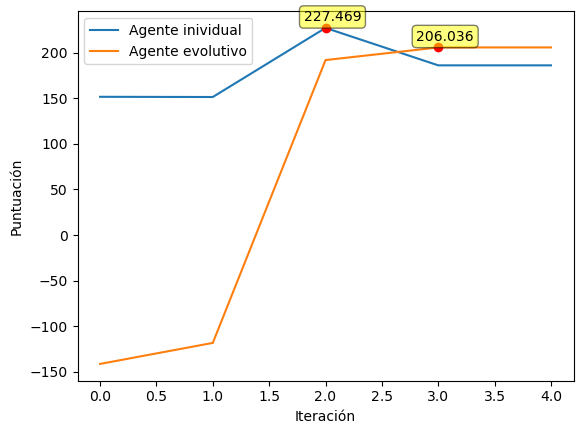

In [10]:
# Generamos el código para mostrar un diagrama con la evolución de la puntuación de los asistentes.
asistente1 = [151.808, 151.58, 227.469, 186.357, 186.357]
asistente2 = [-141.601, -118.51, 192.155, 206.036, 206.036]

# Generamos el plot con los datos.
fig, ax = plt.subplots()
ax.plot(asistente1, label="Agente inividual")
ax.plot(asistente2, label="Agente evolutivo")

# Encontrar el índice y valor de la puntuación más alta para cada agente
max_index1, max_value1 = max(enumerate(asistente1), key=lambda pair: pair[1])
max_index2, max_value2 = max(enumerate(asistente2), key=lambda pair: pair[1])

# Marcar la puntuación más alta para cada agente con un punto rojo
ax.plot(max_index1, max_value1, 'ro')  # Punto rojo para el asistente1
ax.plot(max_index2, max_value2, 'ro')  # Punto rojo para el asistente2

# Añadir anotaciones con el valor numérico
# Ajusta la posición del xytext para evitar solapamientos y asegurar que esté dentro del gráfico
ax.annotate(f'{max_value1}', xy=(max_index1, max_value1), xytext=(5, 5),
            textcoords="offset points", ha='center', 
            bbox=dict(boxstyle="round,pad=0.3", facecolor='yellow', edgecolor='black', alpha=0.5))

ax.annotate(f'{max_value2}', xy=(max_index2, max_value2), xytext=(5, 5),
            textcoords="offset points", ha='center', 
            bbox=dict(boxstyle="round,pad=0.3", facecolor='yellow', edgecolor='black', alpha=0.5))

ax.set_xlabel("Iteración")
ax.set_ylabel("Puntuación")
#ax.set_title("Evolución de la puntuación de los asistentes con mejor puntuación")
ax.legend()